# Peaks Probability Visualisation

In [7]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from dataclasses import dataclass
from typing import List, Tuple
import random

@dataclass
class ColorRampPoint:
    """A single control point in the color ramp"""
    position: float  # 0.0 to 1.0
    value: float     # height multiplier

@dataclass 
class GeometryComposition:
    """Represents a complete geometry node composition"""
    noise_scale: float
    color_ramp_points: List[ColorRampPoint]
    position_strength: float

class Peak3DVisualizer:
    """3D visualization of peak detection for geometry node height fields"""
    
    def __init__(self, grid_size=32, threshold=0.3):
        self.grid_size = grid_size
        self.threshold = threshold
    
    def generate_height_field(self, composition: GeometryComposition) -> np.ndarray:
        """Generate height field from geometry node composition"""
        # Create noise field
        x = np.linspace(0, composition.noise_scale, self.grid_size)
        y = np.linspace(0, composition.noise_scale, self.grid_size)
        X, Y = np.meshgrid(x, y)
        
        # Simple noise (using sine waves for reproducibility)
        noise = (np.sin(X) * np.cos(Y) + 
                np.sin(2*X) * np.cos(3*Y) + 
                np.sin(3*X) * np.cos(2*Y)) / 3.0
        
        # Normalize to 0-1
        noise = (noise - noise.min()) / (noise.max() - noise.min())
        
        # Apply color ramp transformation
        height_field = self.apply_color_ramp(noise, composition.color_ramp_points)
        
        # Apply position strength
        height_field *= composition.position_strength
        
        return height_field
    
    def apply_color_ramp(self, noise_field: np.ndarray, ramp_points: List[ColorRampPoint]) -> np.ndarray:
        """Apply color ramp transformation to noise field"""
        # Sort points by position
        points = sorted(ramp_points, key=lambda p: p.position)
        
        result = np.zeros_like(noise_field)
        
        for i in range(len(noise_field)):
            for j in range(len(noise_field[0])):
                noise_val = noise_field[i, j]
                
                # Find interpolation range
                if noise_val <= points[0].position:
                    result[i, j] = points[0].value
                elif noise_val >= points[-1].position:
                    result[i, j] = points[-1].value
                else:
                    # Linear interpolation between points
                    for k in range(len(points) - 1):
                        if points[k].position <= noise_val <= points[k+1].position:
                            t = (noise_val - points[k].position) / (points[k+1].position - points[k].position)
                            result[i, j] = points[k].value + t * (points[k+1].value - points[k].value)
                            break
        
        return result
    
    def count_peaks(self, height_field: np.ndarray) -> int:
        """Count distinct peaks/islands using simple flood fill"""
        # Threshold the height field
        binary = height_field > self.threshold
        
        # Connected component labeling (simple flood fill)
        visited = np.zeros_like(binary, dtype=bool)
        peak_count = 0
        
        for i in range(binary.shape[0]):
            for j in range(binary.shape[1]):
                if binary[i, j] and not visited[i, j]:
                    # Found a new island, flood fill it
                    self._flood_fill(binary, visited, i, j)
                    peak_count += 1
        
        return peak_count
    
    def _flood_fill(self, binary: np.ndarray, visited: np.ndarray, start_i: int, start_j: int):
        """Flood fill for connected component labeling"""
        stack = [(start_i, start_j)]
        
        while stack:
            i, j = stack.pop()
            if (i < 0 or i >= binary.shape[0] or 
                j < 0 or j >= binary.shape[1] or 
                visited[i, j] or not binary[i, j]):
                continue
            
            visited[i, j] = True
            
            # Add neighbors
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                stack.append((i + di, j + dj))
    
    def create_3d_surface_plot(self, composition: GeometryComposition, title_suffix=""):
        """Create 3D surface plot showing height field and peak detection"""
        
        height_field = self.generate_height_field(composition)
        peak_count = self.count_peaks(height_field)
        
        # Create coordinate meshes
        x = np.arange(self.grid_size)
        y = np.arange(self.grid_size)
        X, Y = np.meshgrid(x, y)
        
        # Create binary threshold for coloring
        binary = height_field > self.threshold
        
        # Create the main 3D surface
        fig = go.Figure()
        
        # Add the height field surface
        fig.add_trace(go.Surface(
            x=X,
            y=Y,
            z=height_field,
            colorscale='Earth',
            name='Height Field',
            showscale=True,
            colorbar=dict(title="Height", x=1.0),
            hovertemplate="X: %{x}<br>Y: %{y}<br>Height: %{z:.3f}<extra></extra>"
        ))
        
        # Add threshold plane
        threshold_z = np.full_like(height_field, self.threshold)
        fig.add_trace(go.Surface(
            x=X,
            y=Y,
            z=threshold_z,
            colorscale=[[0, 'rgba(255,0,0,0.3)'], [1, 'rgba(255,0,0,0.3)']],
            name=f'Threshold = {self.threshold}',
            showscale=False,
            hovertemplate="Threshold Plane<br>Z = %{z}<extra></extra>"
        ))
        
        # Add markers for peak regions
        peak_x, peak_y, peak_z = [], [], []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if binary[i, j]:  # Above threshold
                    peak_x.append(i)
                    peak_y.append(j)
                    peak_z.append(height_field[i, j])
        
        if peak_x:  # Only add if there are peaks
            fig.add_trace(go.Scatter3d(
                x=peak_x,
                y=peak_y,
                z=peak_z,
                mode='markers',
                marker=dict(
                    size=3,
                    color='red',
                    opacity=0.8
                ),
                name='Peak Points',
                hovertemplate="Peak Point<br>X: %{x}<br>Y: %{y}<br>Height: %{z:.3f}<extra></extra>"
            ))
        
        # Update layout
        fig.update_layout(
            title=f"3D Height Field - {peak_count} Peak(s) Detected {title_suffix}",
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Height',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=700
        )
        
        return fig, peak_count
    
    def create_multi_threshold_comparison(self, composition: GeometryComposition):
        """Show how different thresholds affect peak detection"""
        
        height_field = self.generate_height_field(composition)
        
        # Test different thresholds
        thresholds = [0.1, 0.3, 0.5, 0.7]
        
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}],
                   [{'type': 'surface'}, {'type': 'surface'}]],
            subplot_titles=[f'Threshold = {t}' for t in thresholds]
        )
        
        # Create coordinate meshes
        x = np.arange(self.grid_size)
        y = np.arange(self.grid_size)
        X, Y = np.meshgrid(x, y)
        
        positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
        
        for i, (threshold, pos) in enumerate(zip(thresholds, positions)):
            # Count peaks with this threshold
            original_threshold = self.threshold
            self.threshold = threshold
            peak_count = self.count_peaks(height_field)
            self.threshold = original_threshold
            
            # Create binary mask
            binary = height_field > threshold
            
            # Add surface
            fig.add_trace(
                go.Surface(
                    x=X,
                    y=Y,
                    z=height_field,
                    colorscale='Earth',
                    showscale=False,
                    name=f'Threshold {threshold}'
                ),
                row=pos[0], col=pos[1]
            )
            
            # Add threshold plane
            threshold_z = np.full_like(height_field, threshold)
            fig.add_trace(
                go.Surface(
                    x=X,
                    y=Y,
                    z=threshold_z,
                    colorscale=[[0, 'rgba(255,0,0,0.3)'], [1, 'rgba(255,0,0,0.3)']],
                    showscale=False,
                    name=f'Plane {threshold}'
                ),
                row=pos[0], col=pos[1]
            )
            
            # Update subplot title to include peak count
            fig.layout.annotations[i].text = f'Threshold = {threshold}<br>{peak_count} Peaks'
        
        fig.update_layout(
            title="Peak Detection at Different Thresholds",
            height=800,
            showlegend=False
        )
        
        return fig
    
    def visualize_color_ramp_effect(self, base_noise_scale=4.0):
        """Show how different color ramp configurations create different peak patterns"""
        
        # Create different color ramp configurations
        configurations = [
            {
                'name': 'Flat (No Peaks)',
                'points': [ColorRampPoint(0.0, 0.1), ColorRampPoint(1.0, 0.2)]
            },
            {
                'name': 'Single Peak',
                'points': [ColorRampPoint(0.0, 0.1), ColorRampPoint(0.5, 0.8), ColorRampPoint(1.0, 0.1)]
            },
            {
                'name': 'Two Peaks',
                'points': [ColorRampPoint(0.0, 0.1), ColorRampPoint(0.3, 0.8), 
                          ColorRampPoint(0.5, 0.2), ColorRampPoint(0.7, 0.9), ColorRampPoint(1.0, 0.1)]
            },
            {
                'name': 'Many Small Peaks',
                'points': [ColorRampPoint(0.0, 0.4), ColorRampPoint(0.2, 0.8), ColorRampPoint(0.4, 0.3),
                          ColorRampPoint(0.6, 0.9), ColorRampPoint(0.8, 0.2), ColorRampPoint(1.0, 0.7)]
            }
        ]
        
        # Create 2x2 subplot
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}],
                   [{'type': 'surface'}, {'type': 'surface'}]],
            subplot_titles=[config['name'] for config in configurations]
        )
        
        positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
        
        for i, (config, pos) in enumerate(zip(configurations, positions)):
            # Create composition
            composition = GeometryComposition(
                noise_scale=base_noise_scale,
                color_ramp_points=config['points'],
                position_strength=1.0
            )
            
            # Generate height field and count peaks
            height_field = self.generate_height_field(composition)
            peak_count = self.count_peaks(height_field)
            
            # Create coordinate meshes
            x = np.arange(self.grid_size)
            y = np.arange(self.grid_size)
            X, Y = np.meshgrid(x, y)
            
            # Add surface
            fig.add_trace(
                go.Surface(
                    x=X,
                    y=Y,
                    z=height_field,
                    colorscale='Earth',
                    showscale=False,
                    name=config['name']
                ),
                row=pos[0], col=pos[1]
            )
            
            # Add threshold plane
            threshold_z = np.full_like(height_field, self.threshold)
            fig.add_trace(
                go.Surface(
                    x=X,
                    y=Y,
                    z=threshold_z,
                    colorscale=[[0, 'rgba(255,0,0,0.3)'], [1, 'rgba(255,0,0,0.3)']],
                    showscale=False,
                    name=f'Threshold {config["name"]}'
                ),
                row=pos[0], col=pos[1]
            )
            
            # Update subtitle with peak count
            fig.layout.annotations[i].text = f'{config["name"]}<br>{peak_count} Peaks Detected'
        
        fig.update_layout(
            title="How Color Ramp Configuration Affects Peak Formation",
            height=800,
            showlegend=False
        )
        
        return fig

def generate_random_composition() -> GeometryComposition:
    """Generate a random geometry composition"""
    # Random noise scale
    noise_scale = random.uniform(3.0, 6.0)
    
    # Random color ramp points (2-4 points)
    num_points = random.randint(2, 4)
    positions = sorted([random.random() for _ in range(num_points)])
    positions[0] = 0.0  # Ensure start point
    positions[-1] = 1.0  # Ensure end point
    
    ramp_points = [ColorRampPoint(pos, random.uniform(0.0, 1.0)) 
                  for pos in positions]
    
    # Random position strength
    position_strength = random.uniform(0.5, 1.5)
    
    return GeometryComposition(noise_scale, ramp_points, position_strength)

def demo_3d_peak_detection():
    """Demonstrate 3D peak detection visualization"""
    
    print("3D PEAK DETECTION VISUALIZATION")
    print("=" * 40)
    
    visualizer = Peak3DVisualizer(grid_size=32, threshold=0.3)
    
    # Demo 1: Single random composition in detail
    print("\n1. Random Composition - 3D View")
    composition = generate_random_composition()
    fig1, peak_count = visualizer.create_3d_surface_plot(composition, "(Random)")
    fig1.show()
    print(f"   Detected {peak_count} peaks")
    
    # Demo 2: Threshold comparison
    print("\n2. Threshold Sensitivity Analysis")
    fig2 = visualizer.create_multi_threshold_comparison(composition)
    fig2.show()
    print("   See how different thresholds change peak detection")
    
    # Demo 3: Color ramp effect demonstration
    print("\n3. Color Ramp Configuration Effects")
    fig3 = visualizer.visualize_color_ramp_effect()
    fig3.show()
    print("   Compare different color ramp strategies")
    
    # Demo 4: Multiple random compositions
    print("\n4. Multiple Random Compositions")
    for i in range(3):
        comp = generate_random_composition()
        fig, peaks = visualizer.create_3d_surface_plot(comp, f"(Example {i+1})")
        fig.show()
        print(f"   Example {i+1}: {peaks} peaks")
    
    print("\n🎯 Key observations:")
    print("   - Red plane = threshold level")
    print("   - Red dots = points above threshold (peaks)")
    print("   - Connected red regions = single peak")
    print("   - Separate red regions = multiple peaks")



## Run

In [9]:
if __name__ == "__main__":
    demo_3d_peak_detection()

3D PEAK DETECTION VISUALIZATION

1. Random Composition - 3D View


   Detected 1 peaks

2. Threshold Sensitivity Analysis


   See how different thresholds change peak detection

3. Color Ramp Configuration Effects


   Compare different color ramp strategies

4. Multiple Random Compositions


   Example 1: 1 peaks


   Example 2: 6 peaks


   Example 3: 0 peaks

🎯 Key observations:
   - Red plane = threshold level
   - Red dots = points above threshold (peaks)
   - Connected red regions = single peak
   - Separate red regions = multiple peaks


# Blender figures

### blender color ramp setup function

In [ ]:
def test_color_ramp(save_dir, color_ramp_blender_config):
    """
    Test color ramp functionality in Blender.

    Can be run with: pytest -s tests/test_blender.py::test_color_ramp

    Args:
        save_dir: Directory to save the Blender file for visual inspection
    """
    import datetime
    import bpy
    import os
    print("Starting color ramp test...")

    def create_connected_nodes(node_group, node_configs):
        nodes = node_group.nodes
        links = node_group.links
        created_nodes = {}
        print(f"Creating {len(node_configs['nodes'])} nodes...")
        for name, node_type in node_configs["nodes"]:
            created_nodes[name] = nodes.new(node_type)
            print(f"  - Created {node_type} node named '{name}'")

        print(f"Creating {len(node_configs['connections'])} connections...")
        for from_node, from_out, to_node, to_in in node_configs["connections"]:
            links.new(
                created_nodes[from_node].outputs[from_out],
                created_nodes[to_node].inputs[to_in],
            )
            print(f"  - Connected {from_node}.{from_out} → {to_node}.{to_in}")
        return created_nodes

    # Clear existing mesh objects
    print("Clearing existing mesh objects...")
    bpy.ops.object.select_all(action="SELECT")
    bpy.ops.object.delete(use_global=False)

    # Clear existing node groups
    print(f"Clearing {len(bpy.data.node_groups)} existing node groups...")
    for node_group in bpy.data.node_groups:
        print(f"  - Removing node group: {node_group.name}")
        bpy.data.node_groups.remove(node_group)

    # Create geometry node group
    print("Creating new geometry node group: TestColorRampGroup")
    node_group = bpy.data.node_groups.new("TestColorRampGroup", "GeometryNodeTree")
    # Add group input and output nodes
    print("Adding group input and output nodes...")
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    print(f"  - Created {group_input.name}")
    print(f"  - Created {group_output.name}")

    # Set up the interface for the node group (Blender 4.4 specific)
    print("Setting up node group interface for Blender 4.4...")
    try:
        # In Blender 4.4, we use the interface system
        if hasattr(node_group, "interface"):
            # Add input socket for geometry
            in_socket = node_group.interface.new_socket(
                name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
            )
            print(f"  - Added input socket: {in_socket.name}")

            # Add output socket for geometry
            out_socket = node_group.interface.new_socket(
                name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
            )
            print(f"  - Added output socket: {out_socket.name}")
        else:
            print(
                "  - Warning: node_group.interface not found. This is unexpected for Blender 4.4"
            )
    except Exception as e:
        print(f"  - Error setting up node group interface: {e}")
        print("  - This may result in red connections in the node editor")

    # Create node configuration
    print("Setting up node configuration...")
    config = color_ramp_blender_config

    # Create and connect nodes
    print("Creating and connecting nodes according to configuration...")
    created_nodes = create_connected_nodes(node_group, config)

    # Connect to group input/output
    print("Connecting to group input/output...")
    node_group.links.new(
        group_input.outputs[0], created_nodes["set_pos"].inputs["Geometry"]
    )
    print("  - Connected Group Input → Set Position.Geometry")

    node_group.links.new(
        created_nodes["set_pos"].outputs["Geometry"], group_output.inputs[0]
    )
    print("  - Connected Set Position.Geometry → Group Output")

    # Test: Check that we have the expected number of connections
    print(f"Checking connections: found {len(node_group.links)} links")
    assert len(node_group.links) == 7, f"Expected 7 links, got {len(node_group.links)}"

    # Test: Verify specific connections exist
    print("Verifying specific connections...")
    link_pairs = []
    for link in node_group.links:
        link_pair = (link.from_node.name, link.to_node.name)
        link_pairs.append(link_pair)
        print(f"  - Found connection: {link_pair[0]} → {link_pair[1]}")

    expected_connections = [
        ("Group Input", "Set Position"),
        ("Noise Texture", "Combine XYZ"),
        ("Combine XYZ", "ColorRamp"),
        ("ColorRamp", "Set Position"),
        ("Set Position", "Group Output"),
    ]

    # Test: Check color ramp has default color stops
    color_ramp_node = created_nodes["ramp"]
    print(
        f"Checking color ramp: found {len(color_ramp_node.color_ramp.elements)} color stops"
    )
    assert len(color_ramp_node.color_ramp.elements) >= 2, (
        "Color ramp should have at least 2 color stops"
    )

    # Test: Verify we can modify color ramp
    print("Modifying color ramp elements...")
    print(
        f"  - Original first stop color: {color_ramp_node.color_ramp.elements[0].color[:]}"
    )
    print(
        f"  - Original second stop color: {color_ramp_node.color_ramp.elements[1].color[:]}"
    )

    color_ramp_node.color_ramp.elements[0].color = (1, 0, 0, 1)  # Red
    color_ramp_node.color_ramp.elements[1].color = (0, 0, 1, 1)  # Blue

    print(
        f"  - Modified first stop color to red: {color_ramp_node.color_ramp.elements[0].color[:]}"
    )
    print(
        f"  - Modified second stop color to blue: {color_ramp_node.color_ramp.elements[1].color[:]}"
    )

    assert color_ramp_node.color_ramp.elements[0].color[0] == 1.0, (
        "First color stop should be red"
    )
    assert color_ramp_node.color_ramp.elements[1].color[2] == 1.0, (
        "Second color stop should be blue"
    )

    # Create a demonstration object to apply the node group to
    print("\nCreating a demonstration object...")
    bpy.ops.mesh.primitive_uv_sphere_add(radius=1.0, location=(0, 0, 0))
    sphere = bpy.context.active_object

    # Add a geometry nodes modifier to the sphere

    print("Adding geometry nodes modifier to the sphere...")
    geo_mod = sphere.modifiers.new("GeometryNodes", "NODES")

    # Attempt to assign the node group to the modifier
    try:
        geo_mod.node_group = node_group
        print(
            f"  - Successfully added geometry nodes modifier with node group: {node_group.name}"
        )
    except Exception as e:
        print(f"  - Note: Could not assign node group to modifier: {e}")
        print(
            "  - This is expected in some Blender versions and won't affect the test "
            "results"
        )

    # Save the Blender file
    test_name = "color_ramp_test"
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # First save to the current directory (overwriting any existing file)
    current_path = os.path.join(save_dir["current"], f"{test_name}.blend")
    print(f"\nSaving current Blender file to: {current_path}")
    bpy.ops.wm.save_as_mainfile(filepath=current_path)
    print(f"File saved successfully at: {current_path}")

    # Then save to the history directory with timestamp
    history_path = os.path.join(save_dir["history"], f"{test_name}_{timestamp}.blend")
    print(f"Saving history Blender file to: {history_path}")
    bpy.ops.wm.save_as_mainfile(filepath=history_path)
    print(f"History file saved successfully at: {history_path}")

    print("✅ Color ramp test passed!")
    print(f"Created node group with {len(node_group.links)} connections")
    print(f"Color ramp has {len(color_ramp_node.color_ramp.elements)} color stops")

    # Print additional details about node structure
    print("\nFinal Node Group Structure:")
    print(f"Total nodes: {len(node_group.nodes)}")
    for i, node in enumerate(node_group.nodes):
        print(f"  {i + 1}. {node.name} ({node.bl_idname})")
        print(f"     - Inputs: {len(node.inputs)}")
        print(f"     - Outputs: {len(node.outputs)}")

    # Print details about the color ramp configuration
    print("\nColor Ramp Configuration:")
    for i, element in enumerate(color_ramp_node.color_ramp.elements):
        print(f"  Stop {i + 1}: Position={element.position}, Color={element.color[:]}")

    # Print information about the created demonstration object
    print("\nDemonstration Object:")
    print(f"  Name: {sphere.name}")
    print(f"  Type: {sphere.type}")

    print("\nTest completed successfully!")
    # return {
    #     "current_file": current_path,
    #     "history_file": history_path,
    #     "test_name": test_name,
    # }


def save_dir():
    import os
    import datetime
    from pathlib import Path
    """Fixture to provide directories for saving Blender test files.

    Returns a dictionary with:
    - 'current': Directory for the most recent test run (overwritten each time)
    - 'history': Directory for keeping history of all test runs

    Checks for BLENDERTESTSAVEDIR environment variable first, otherwise
    defaults to ./tests directory.
    """
    if "BLENDERTESTSAVEDIR" in os.environ and os.environ["BLENDERTESTSAVEDIR"]:
        base_dir = os.environ["BLENDERTESTSAVEDIR"]
    else:
        base_dir = "./tests"

    # Create the base directory
    Path(base_dir).mkdir(parents=True, exist_ok=True)

    # Create the history directory
    history_dir = os.path.join(base_dir, "run_history")
    Path(history_dir).mkdir(parents=True, exist_ok=True)

    print("Using save directories:")
    print(f"  - Current run: {base_dir}")
    print(f"  - Run history: {history_dir}")

    return {"current": base_dir, "history": history_dir}
# @aerial Color ramp configuration for Blender
def color_ramp_blender_config():
    return {
        "nodes": [
            ("noise", "ShaderNodeTexNoise"),
            ("combine", "ShaderNodeCombineXYZ"),
            ("ramp", "ShaderNodeValToRGB"),
            ("set_pos", "GeometryNodeSetPosition"),
        ],
        "connections": [
            ("noise", "Fac", "combine", "X"),
            ("noise", "Fac", "combine", "Y"),
            ("noise", "Fac", "combine", "Z"),
            ("combine", "Vector", "ramp", "Fac"),
            ("ramp", "Color", "set_pos", "Offset"),
        ],
    }


### run

In [ ]:
test_color_ramp(save_dir(), color_ramp_blender_config())

# Color ramp + nois widget

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d
from opensimplex import OpenSimplex

# Initialize opensimplex generator
opensimplex = OpenSimplex(seed=42)

class ColorRampNoiseExplorer:
    """Interactive widget for exploring how color ramps affect noise functions."""
    
    def __init__(self, width=400, height=400):
        self.width = width
        self.height = height
        self.fig_size = (12, 8)
        
        # Initialize noise parameters
        self.scale = 10.0
        self.octaves = 4
        self.persistence = 0.5
        self.lacunarity = 2.0
        self.time_offset = 0.0
        self.noise_type = 'perlin'
        
        # Initialize color ramp
        self.color_stops = [
            {'position': 0.0, 'color': [0, 0, 0, 1]},      # Black
            {'position': 1.0, 'color': [1, 1, 1, 1]}       # White
        ]
        
        # Generate coordinate grids
        self.x = np.linspace(0, 1, self.width)
        self.y = np.linspace(0, 1, self.height)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        self.setup_widgets()
        self.setup_output()
        
    def setup_widgets(self):
        """Create all the interactive widgets."""
        
        # Noise parameter widgets
        self.scale_slider = widgets.FloatSlider(
            value=self.scale, min=0.1, max=50.0, step=0.5,
            description='Scale:', style={'description_width': 'initial'}
        )
        
        self.octaves_slider = widgets.IntSlider(
            value=self.octaves, min=1, max=8, step=1,
            description='Octaves:', style={'description_width': 'initial'}
        )
        
        self.persistence_slider = widgets.FloatSlider(
            value=self.persistence, min=0.1, max=1.0, step=0.05,
            description='Persistence:', style={'description_width': 'initial'}
        )
        
        self.lacunarity_slider = widgets.FloatSlider(
            value=self.lacunarity, min=1.0, max=4.0, step=0.1,
            description='Lacunarity:', style={'description_width': 'initial'}
        )
        
        self.time_offset_slider = widgets.FloatSlider(
            value=self.time_offset, min=0.0, max=10.0, step=0.1,
            description='Time Offset:', style={'description_width': 'initial'}
        )
        
        self.noise_type_dropdown = widgets.Dropdown(
            options=['perlin', 'simplex', 'ridge', 'cellular'],
            value=self.noise_type,
            description='Noise Type:', style={'description_width': 'initial'}
        )
        
        # Color ramp widgets
        self.color_preset_dropdown = widgets.Dropdown(
            options=[
                ('Black to White', 'bw'),
                ('Fire', 'fire'),
                ('Ocean', 'ocean'),
                ('Rainbow', 'rainbow'),
                ('Terrain', 'terrain'),
                ('Sunset', 'sunset'),
                ('Ice', 'ice'),
                ('Custom', 'custom')
            ],
            value='bw',
            description='Color Preset:', style={'description_width': 'initial'}
        )
        
        # Color stop editing widgets
        self.stop_position_slider = widgets.FloatSlider(
            value=0.0, min=0.0, max=1.0, step=0.01,
            description='Stop Position:', style={'description_width': 'initial'}
        )
        
        self.stop_color_picker = widgets.ColorPicker(
            value='#000000',
            description='Stop Color:', style={'description_width': 'initial'}
        )
        
        self.stop_index_slider = widgets.IntSlider(
            value=0, min=0, max=len(self.color_stops)-1, step=1,
            description='Edit Stop:', style={'description_width': 'initial'}
        )
        
        self.add_stop_button = widgets.Button(
            description='Add Color Stop',
            button_style='success'
        )
        
        self.remove_stop_button = widgets.Button(
            description='Remove Stop',
            button_style='danger'
        )
        
        # Animation widgets
        self.animate_button = widgets.Button(
            description='Start Animation',
            button_style='info'
        )
        
        self.animation_speed_slider = widgets.FloatSlider(
            value=0.1, min=0.01, max=0.5, step=0.01,
            description='Anim Speed:', style={'description_width': 'initial'}
        )
        
        # Analysis widgets
        self.show_histogram = widgets.Checkbox(
            value=False,
            description='Show Histogram'
        )
        
        self.show_stats = widgets.Checkbox(
            value=False,
            description='Show Statistics'
        )
        
        # Set up event handlers
        self.setup_event_handlers()
        
    def setup_event_handlers(self):
        """Connect widget events to update functions."""
        
        # Noise parameter updates
        self.scale_slider.observe(self.update_noise, names='value')
        self.octaves_slider.observe(self.update_noise, names='value')
        self.persistence_slider.observe(self.update_noise, names='value')
        self.lacunarity_slider.observe(self.update_noise, names='value')
        self.time_offset_slider.observe(self.update_noise, names='value')
        self.noise_type_dropdown.observe(self.update_noise, names='value')
        
        # Color ramp updates
        self.color_preset_dropdown.observe(self.update_color_preset, names='value')
        self.stop_position_slider.observe(self.update_color_stop, names='value')
        self.stop_color_picker.observe(self.update_color_stop, names='value')
        self.stop_index_slider.observe(self.select_color_stop, names='value')
        
        # Button events
        self.add_stop_button.on_click(self.add_color_stop)
        self.remove_stop_button.on_click(self.remove_color_stop)
        self.animate_button.on_click(self.toggle_animation)
        
        # Analysis updates
        self.show_histogram.observe(self.update_display, names='value')
        self.show_stats.observe(self.update_display, names='value')
        
    def setup_output(self):
        """Create the output widget for displaying the visualization."""
        self.output = widgets.Output()
        
    def generate_noise(self):
        """Generate noise based on current parameters."""
        
        # Scale coordinates
        scaled_X = self.X * self.scale_slider.value / 10.0
        scaled_Y = self.Y * self.scale_slider.value / 10.0
        
        # Add time offset for animation
        time_offset = self.time_offset_slider.value
        noise_array = np.zeros((self.height, self.width))
        
        if self.noise_type_dropdown.value in ['perlin', 'simplex']:
            # Both use opensimplex but with different parameters
            for i in range(self.height):
                for j in range(self.width):
                    # Combine multiple octaves manually for fractal noise
                    value = 0.0
                    amplitude = 1.0
                    frequency = 1.0
                    max_value = 0.0
                    
                    for octave in range(self.octaves_slider.value):
                        sample_x = scaled_X[i, j] * frequency
                        sample_y = scaled_Y[i, j] * frequency
                        sample_z = time_offset * frequency
                        
                        # Add slight offset for perlin vs simplex difference
                        if self.noise_type_dropdown.value == 'perlin':
                            octave_value = opensimplex.noise3(sample_x, sample_y, sample_z)
                        else:  # simplex
                            octave_value = opensimplex.noise3(sample_x + 100, sample_y + 100, sample_z)
                        
                        value += octave_value * amplitude
                        max_value += amplitude
                        
                        amplitude *= self.persistence_slider.value
                        frequency *= self.lacunarity_slider.value
                    
                    noise_array[i, j] = value / max_value if max_value != 0 else 0
        
        elif self.noise_type_dropdown.value == 'ridge':
            # Ridge noise - absolute value inverted
            for i in range(self.height):
                for j in range(self.width):
                    sample_x = scaled_X[i, j]
                    sample_y = scaled_Y[i, j]
                    sample_z = time_offset
                    
                    # Generate fractal noise first
                    value = 0.0
                    amplitude = 1.0
                    frequency = 1.0
                    max_value = 0.0
                    
                    for octave in range(self.octaves_slider.value):
                        octave_value = opensimplex.noise3(
                            sample_x * frequency, 
                            sample_y * frequency, 
                            sample_z * frequency
                        )
                        value += octave_value * amplitude
                        max_value += amplitude
                        amplitude *= self.persistence_slider.value
                        frequency *= self.lacunarity_slider.value
                    
                    final_value = value / max_value if max_value != 0 else 0
                    noise_array[i, j] = 1.0 - abs(final_value)
        
        elif self.noise_type_dropdown.value == 'cellular':
            # Cellular noise using thresholding
            for i in range(self.height):
                for j in range(self.width):
                    sample_x = scaled_X[i, j] * 2  # Higher frequency for cellular
                    sample_y = scaled_Y[i, j] * 2
                    sample_z = time_offset
                    
                    val = opensimplex.noise3(sample_x, sample_y, sample_z)
                    noise_array[i, j] = 1.0 if val > 0.1 else 0.0
        
        # Normalize to [0, 1]
        noise_array = (noise_array + 1.0) / 2.0
        noise_array = np.clip(noise_array, 0, 1)
        
        return noise_array
    
    def create_colormap(self):
        """Create a matplotlib colormap from color stops."""
        
        # Sort color stops by position
        sorted_stops = sorted(self.color_stops, key=lambda x: x['position'])
        
        # Ensure we have stops at 0.0 and 1.0
        positions = [stop['position'] for stop in sorted_stops]
        colors = [stop['color'][:3] for stop in sorted_stops]  # RGB only
        
        # Add stop at 0.0 if missing
        if positions[0] > 0.0:
            positions.insert(0, 0.0)
            colors.insert(0, colors[0])  # Use first color
        
        # Add stop at 1.0 if missing
        if positions[-1] < 1.0:
            positions.append(1.0)
            colors.append(colors[-1])  # Use last color
        
        # Create colormap
        cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)))
        return cmap
    
    def hex_to_rgb(self, hex_color):
        """Convert hex color to RGB tuple."""
        hex_color = hex_color.lstrip('#')
        return [int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4)]
    
    def calculate_statistics(self, noise_array):
        """Calculate noise statistics."""
        stats = {
            'mean': np.mean(noise_array),
            'std': np.std(noise_array),
            'min': np.min(noise_array),
            'max': np.max(noise_array),
            'range': np.max(noise_array) - np.min(noise_array)
        }
        return stats
    
    def update_noise(self, change=None):
        """Update noise parameters and regenerate visualization."""
        self.update_display()
    
    def update_color_preset(self, change=None):
        """Update color stops based on selected preset."""
        preset = self.color_preset_dropdown.value
        
        presets = {
            'bw': [
                {'position': 0.0, 'color': [0, 0, 0, 1]},
                {'position': 1.0, 'color': [1, 1, 1, 1]}
            ],
            'fire': [
                {'position': 0.0, 'color': [0, 0, 0, 1]},
                {'position': 0.3, 'color': [0.5, 0, 0, 1]},
                {'position': 0.6, 'color': [1, 0.5, 0, 1]},
                {'position': 1.0, 'color': [1, 1, 0, 1]}
            ],
            'ocean': [
                {'position': 0.0, 'color': [0, 0, 0.3, 1]},
                {'position': 0.5, 'color': [0, 0.3, 0.8, 1]},
                {'position': 1.0, 'color': [0.7, 0.9, 1, 1]}
            ],
            'rainbow': [
                {'position': 0.0, 'color': [1, 0, 0, 1]},
                {'position': 0.2, 'color': [1, 0.5, 0, 1]},
                {'position': 0.4, 'color': [1, 1, 0, 1]},
                {'position': 0.6, 'color': [0, 1, 0, 1]},
                {'position': 0.8, 'color': [0, 0, 1, 1]},
                {'position': 1.0, 'color': [0.5, 0, 1, 1]}
            ],
            'terrain': [
                {'position': 0.0, 'color': [0, 0, 0.5, 1]},
                {'position': 0.3, 'color': [0, 0.5, 0, 1]},
                {'position': 0.6, 'color': [0.5, 0.3, 0, 1]},
                {'position': 0.8, 'color': [0.8, 0.8, 0.8, 1]},
                {'position': 1.0, 'color': [1, 1, 1, 1]}
            ],
            'sunset': [
                {'position': 0.0, 'color': [0.1, 0.1, 0.3, 1]},
                {'position': 0.3, 'color': [0.8, 0.3, 0.1, 1]},
                {'position': 0.7, 'color': [1, 0.7, 0.3, 1]},
                {'position': 1.0, 'color': [1, 0.9, 0.7, 1]}
            ],
            'ice': [
                {'position': 0.0, 'color': [0.1, 0.1, 0.3, 1]},
                {'position': 0.5, 'color': [0.3, 0.6, 0.9, 1]},
                {'position': 1.0, 'color': [0.9, 0.95, 1, 1]}
            ]
        }
        
        if preset in presets:
            self.color_stops = presets[preset]
            
            # Update stop index slider range
            self.stop_index_slider.max = len(self.color_stops) - 1
            self.stop_index_slider.value = 0
            
            # Update current stop display
            self.select_color_stop()
        
        self.update_display()
    
    def update_color_stop(self, change=None):
        """Update the currently selected color stop."""
        if len(self.color_stops) == 0:
            return
            
        index = self.stop_index_slider.value
        if 0 <= index < len(self.color_stops):
            self.color_stops[index]['position'] = self.stop_position_slider.value
            rgb = self.hex_to_rgb(self.stop_color_picker.value)
            self.color_stops[index]['color'] = rgb + [1.0]  # Add alpha
            
            # Validate after update
            self.validate_color_stops()
            
        self.update_display()
    
    def select_color_stop(self, change=None):
        """Select a color stop for editing."""
        index = self.stop_index_slider.value
        if 0 <= index < len(self.color_stops):
            stop = self.color_stops[index]
            self.stop_position_slider.value = stop['position']
            
            # Convert RGB to hex
            rgb = stop['color'][:3]
            hex_color = '#{:02x}{:02x}{:02x}'.format(
                int(rgb[0] * 255),
                int(rgb[1] * 255),
                int(rgb[2] * 255)
            )
            self.stop_color_picker.value = hex_color
    
    def add_color_stop(self, button):
        """Add a new color stop."""
        # Find position for new stop
        new_position = 0.5
        if len(self.color_stops) > 0:
            positions = [stop['position'] for stop in self.color_stops]
            positions.sort()
            # Find largest gap
            max_gap = 0
            best_pos = 0.5
            for i in range(len(positions) - 1):
                gap = positions[i + 1] - positions[i]
                if gap > max_gap:
                    max_gap = gap
                    best_pos = (positions[i] + positions[i + 1]) / 2
            new_position = best_pos
        
        # Add new stop
        new_stop = {'position': new_position, 'color': [0.5, 0.5, 0.5, 1]}
        self.color_stops.append(new_stop)
        
        # Update slider range and select new stop
        self.stop_index_slider.max = len(self.color_stops) - 1
        self.stop_index_slider.value = len(self.color_stops) - 1
        self.select_color_stop()
        
        self.update_display()
    
    def remove_color_stop(self, button):
        """Remove the currently selected color stop."""
        if len(self.color_stops) <= 2:
            return  # Keep at least 2 stops
            
        index = self.stop_index_slider.value
        if 0 <= index < len(self.color_stops):
            self.color_stops.pop(index)
            
            # Update slider range
            self.stop_index_slider.max = len(self.color_stops) - 1
            if self.stop_index_slider.value >= len(self.color_stops):
                self.stop_index_slider.value = len(self.color_stops) - 1
            
            # Ensure we still have stops at 0.0 and 1.0
            self.validate_color_stops()
            
            self.select_color_stop()
        
        self.update_display()
    
    def validate_color_stops(self):
        """Ensure color stops are valid (have stops at 0.0 and 1.0)."""
        positions = [stop['position'] for stop in self.color_stops]
        
        # Check if we have a stop at 0.0
        has_zero = any(abs(pos) < 0.001 for pos in positions)
        if not has_zero:
            # Find the stop closest to 0 and set it to 0
            min_idx = min(range(len(positions)), key=lambda i: positions[i])
            self.color_stops[min_idx]['position'] = 0.0
        
        # Check if we have a stop at 1.0
        has_one = any(abs(pos - 1.0) < 0.001 for pos in positions)
        if not has_one:
            # Find the stop closest to 1 and set it to 1
            max_idx = max(range(len(positions)), key=lambda i: positions[i])
            self.color_stops[max_idx]['position'] = 1.0
    
    def toggle_animation(self, button):
        """Toggle noise animation."""
        if button.description == 'Start Animation':
            button.description = 'Stop Animation'
            button.button_style = 'warning'
            # TODO: Implement animation loop
        else:
            button.description = 'Start Animation'
            button.button_style = 'info'
    
    def update_display(self, change=None):
        """Update the main visualization."""
        with self.output:
            clear_output(wait=True)
            
            # Generate noise
            noise_array = self.generate_noise()
            
            # Create colormap
            cmap = self.create_colormap()
            
            # Create figure
            if self.show_histogram.value or self.show_stats.value:
                fig, axes = plt.subplots(2, 2, figsize=self.fig_size)
                ax_main = axes[0, :]
                ax_hist = axes[1, 0] if self.show_histogram.value else None
                ax_stats = axes[1, 1] if self.show_stats.value else None
            else:
                fig, ax_main = plt.subplots(1, 1, figsize=(8, 6))
                axes = None
            
            # Main noise visualization
            if axes is not None:
                im = ax_main[0].imshow(noise_array, cmap=cmap, origin='lower')
                ax_main[0].set_title(f'{self.noise_type_dropdown.value.title()} Noise with Color Ramp')
                ax_main[0].axis('off')
                
                # Color ramp visualization
                gradient = np.linspace(0, 1, 256).reshape(1, -1)
                ax_main[1].imshow(gradient, aspect='auto', cmap=cmap)
                ax_main[1].set_title('Color Ramp')
                ax_main[1].set_xlim(0, 255)
                ax_main[1].set_xticks([0, 64, 128, 192, 255])
                ax_main[1].set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])
                ax_main[1].set_yticks([])
            else:
                im = ax_main.imshow(noise_array, cmap=cmap, origin='lower')
                ax_main.set_title(f'{self.noise_type_dropdown.value.title()} Noise with Color Ramp')
                ax_main.axis('off')
            
            # Histogram
            if self.show_histogram.value and ax_hist is not None:
                ax_hist.hist(noise_array.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                ax_hist.set_title('Noise Value Distribution')
                ax_hist.set_xlabel('Noise Value')
                ax_hist.set_ylabel('Frequency')
                ax_hist.grid(True, alpha=0.3)
            
            # Statistics
            if self.show_stats.value and ax_stats is not None:
                stats = self.calculate_statistics(noise_array)
                stats_text = f"""Statistics:
Mean: {stats['mean']:.3f}
Std: {stats['std']:.3f}
Min: {stats['min']:.3f}
Max: {stats['max']:.3f}
Range: {stats['range']:.3f}

Parameters:
Scale: {self.scale_slider.value}
Octaves: {self.octaves_slider.value}
Persistence: {self.persistence_slider.value:.2f}
Lacunarity: {self.lacunarity_slider.value:.1f}"""
                
                ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, 
                             verticalalignment='top', fontfamily='monospace', fontsize=10)
                ax_stats.set_title('Noise Statistics')
                ax_stats.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    def display(self):
        """Display the complete widget interface."""
        
        # Create widget layout
        noise_controls = widgets.VBox([
            widgets.HTML("<h3>🔊 Noise Parameters</h3>"),
            self.noise_type_dropdown,
            self.scale_slider,
            self.octaves_slider,
            self.persistence_slider,
            self.lacunarity_slider,
            self.time_offset_slider
        ])
        
        color_controls = widgets.VBox([
            widgets.HTML("<h3>🎨 Color Ramp</h3>"),
            self.color_preset_dropdown,
            widgets.HTML("<b>Edit Color Stops:</b>"),
            self.stop_index_slider,
            self.stop_position_slider,
            self.stop_color_picker,
            widgets.HBox([self.add_stop_button, self.remove_stop_button])
        ])
        
        animation_controls = widgets.VBox([
            widgets.HTML("<h3>⚡ Animation & Analysis</h3>"),
            self.animate_button,
            self.animation_speed_slider,
            self.show_histogram,
            self.show_stats
        ])
        
        controls_panel = widgets.HBox([
            noise_controls,
            color_controls,
            animation_controls
        ])
        
        main_interface = widgets.VBox([
            widgets.HTML("<h2>🎨 Color Ramp Noise Function Explorer</h2>"),
            controls_panel,
            self.output
        ])
        
        # Initial display
        self.update_display()
        
        return main_interface

# Usage example:
def create_color_ramp_explorer():
    """Create and return a ColorRampNoiseExplorer widget."""
    explorer = ColorRampNoiseExplorer()
    return explorer.display()

# Installation instructions:
"""
To use this Color Ramp Noise Explorer widget:

REQUIRED packages:
    pip install ipywidgets matplotlib numpy scipy opensimplex

USAGE in Jupyter notebook:
    widget = create_color_ramp_explorer()
    display(widget)

The widget will automatically use opensimplex for high-quality noise generation,
with built-in fallback functions if opensimplex is not available.
"""

'\nTo use this Color Ramp Noise Explorer widget:\n\nREQUIRED packages:\n    pip install ipywidgets matplotlib numpy scipy opensimplex\n\nUSAGE in Jupyter notebook:\n    widget = create_color_ramp_explorer()\n    display(widget)\n\nThe widget will automatically use opensimplex for high-quality noise generation,\nwith built-in fallback functions if opensimplex is not available.\n'

In [18]:
widget = create_color_ramp_explorer()
display(widget)

# Gfow Machinations

In [21]:
class GFlowNet:
    def __init__(self, state_dim, action_dim):
        self.forward_net = MLP(...)  # P_F network
        self.backward_net = MLP(...) # P_B network  
        self.log_Z = nn.Parameter(torch.tensor(0.0))  # Initial flow
        
    def forward_policy(self, state):
        # Return action probabilities
        pass
    def backward_policy(self, state, parent_state):
        # Return backward transition probs
        pass
        
    def sample_trajectory(self):
        # Generate complete trajectory using P_F
        pass
        
    def trajectory_balance_loss(self, trajectories):
        # Implement Equation (1) from paper
        pass
        
    def train_step(self, batch_trajectories):
        # Compute loss and update parameters
        pass

## General Flow Network model (NOT GFN)
This is what the flow network started as that is trying to flow match based on trajectory

In [12]:

def forward_network_validation():
    """
    This is just validating that the Model that I am using will work
    """
    import torch
    import torch.nn as nn
    # Just the network, no class wrapper
    state_dim = 5  # 5 states in our example
    action_dim = 3  # max 3 possible actions from any state
    
    # ======================================================================
    # Flow Based model Definition
    # ======================================================================
    forward_net = nn.Sequential(
        nn.Linear(state_dim, 32),
        nn.ReLU(),
        nn.Linear(32, action_dim),
        nn.Softmax(dim=-1)
    )
    # Test with different states
    states = {
        's0': torch.tensor([1, 0, 0, 0, 0], dtype=torch.float32),  # one-hot for s0
        's1': torch.tensor([0, 1, 0, 0, 0], dtype=torch.float32),  # one-hot for s1  
        's2': torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32),  # one-hot for s2
    }
    print("Forward Network Experiment")
    print("=" * 40)
    
    for state_name, state_vector in states.items():
        action_probs = forward_net(state_vector)
        print(f"\nState {state_name}: {state_vector.tolist()}")
        print(f"Action probabilities: {action_probs.detach().numpy()}")
        print(f"Sum of probs: {action_probs.sum().item():.3f}")  # Should be 1.0
    
    # Sample an action from the probabilities
    print("\n" + "=" * 40)
    print("Sampling actions:")
    for state_name, state_vector in states.items():
        action_probs = forward_net(state_vector)
        action = torch.multinomial(action_probs, 1).item()
        print(f"State {state_name} → Action {action} (prob: {action_probs[action]:.3f})")
    
    print("\nThat's it! Feed in state, get out action probabilities.")

# ======================================================================
# Loss Function for Flow Based model
# ======================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

def flow_conservation_loss(flow_net, visited_states, edges, rewards, encode_state):
    """Flow conservation loss - physics constraint"""
    total_loss = torch.tensor(0.0)
    
    # Collect data for table
    table_data = []
    
    for state in visited_states:
        flow_in = torch.tensor(0.0)
        flow_out = torch.tensor(0.0)
        
        # ======================================================================
        # FLOW IN
        # ======================================================================
        incoming_details = []
        for from_state, to_state in edges:
            if to_state == state:
                from_vec = encode_state(from_state)
                to_vec = encode_state(to_state)
                edge_input = torch.cat([from_vec, to_vec])
                predicted_flow = flow_net(edge_input).squeeze()
                flow_in += predicted_flow
                incoming_details.append(f"{from_state}→{predicted_flow.item():.3f}")
        
        # ======================================================================
        # Flow OUT (rewards + outgoing flows)
        # ======================================================================
        outgoing_details = []
        
        if state in rewards:
            reward_flow = torch.tensor(rewards[state])
            flow_out += reward_flow
            outgoing_details.append(f"R:{reward_flow.item():.1f}")
        
        for from_state, to_state in edges:
            if from_state == state:
                from_vec = encode_state(from_state)
                to_vec = encode_state(to_state)
                edge_input = torch.cat([from_vec, to_vec])
                predicted_flow = flow_net(edge_input).squeeze()
                flow_out += predicted_flow
                outgoing_details.append(f"→{to_state}:{predicted_flow.item():.3f}")
        
        # ======================================================================
        # Conservation Constraint Flow In == Flow out
        # ======================================================================
        conservation_error = (flow_in - flow_out) ** 2
        
        # Format details
        in_detail = ",".join(incoming_details) if incoming_details else "none"
        out_detail = ",".join(outgoing_details) if outgoing_details else "none"
        
        table_data.append({
            'State': state,
            'Flow_IN': flow_in.item(),
            'Flow_OUT': flow_out.item(),
            'Error': conservation_error.item(),
            'IN_Details': in_detail,
            'OUT_Details': out_detail
        })
        
        total_loss += conservation_error
    
    # Create and display pandas table
    df = pd.DataFrame(table_data)
    print("\n=== FLOW CONSERVATION ANALYSIS ===")
    print(df.to_string(index=False, float_format='%.4f'))
    print(f"\nTotal Loss: {total_loss.item():.6f}")
    print("Expected: Flow IN = Flow OUT for all states")
    
    return total_loss

forward_network_validation()

Forward Network Experiment

State s0: [1.0, 0.0, 0.0, 0.0, 0.0]
Action probabilities: [0.34223992 0.3381573  0.31960285]
Sum of probs: 1.000

State s1: [0.0, 1.0, 0.0, 0.0, 0.0]
Action probabilities: [0.2774047  0.35551074 0.3670846 ]
Sum of probs: 1.000

State s2: [0.0, 0.0, 1.0, 0.0, 0.0]
Action probabilities: [0.2984059  0.35374996 0.3478442 ]
Sum of probs: 1.000

Sampling actions:
State s0 → Action 0 (prob: 0.342)
State s1 → Action 1 (prob: 0.356)
State s2 → Action 2 (prob: 0.348)

That's it! Feed in state, get out action probabilities.


## Trajectory Balance Model

In [13]:
import torch
import torch.nn as nn



# ======================================================================
# Trajecory balance Model Definition
# ======================================================================
class TBModel(nn.Module):
    def __init__(self, state_dim, num_hid=128):
        super().__init__()
        
        # ======================================================================
        # Forward polocy model
        # ======================================================================
        
        self.forward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, state_dim)
        )
        
        # ======================================================================
        # Backward polocy model
        # ======================================================================
        
        self.backward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, state_dim)
        )
        
        # ======================================================================
        # partition function
        # ======================================================================
        
        self.logZ = nn.Parameter(torch.tensor(5.0))
    
    def forward(self, state_onehot):
        P_F_logits = self.forward_policy(state_onehot)
        P_B_logits = self.backward_policy(state_onehot)
        return P_F_logits, P_B_logits

# ======================================================================
# Loss Function for Trajecory balance Model
# ======================================================================
def trajectory_balance_loss(forward_logits, backward_logits, logZ, trajectory, reward):
    """
    From paper equation (1):
    L_TB = [log(Z_θ * ∏P_F) - log(R(x) * ∏P_B)]²
    """

    # Forward path: Z_θ * ∏P_F(s_t|s_{t-1})

    log_forward_prob = logZ + sum_of_forward_log_probs_along_trajectory
    

    # Backward path: R(x) * ∏P_B(s_{t-1}|s_t) 

    log_backward_prob = torch.log(reward) + sum_of_backward_log_probs_along_trajectory


    # Trajectory balance loss

    loss = (log_forward_prob - log_backward_prob) ** 2
    
    return loss

### example

In [32]:
import torch
import torch.nn.functional as F

def trajectory_balance_loss(model, trajectories, env):
    """
    Trajectory Balance Loss from paper equation (1):
    L_TB = [log(Z_θ * ∏P_F) - log(R(x) * ∏P_B)]²
    
    Optimized version with early termination for invalid trajectories.
    """
    
    # ===================================================================
    # EARLY CHECK: Filter for rewarded trajectories upfront
    # ===================================================================
    rewarded_trajectories = []
    for traj in trajectories:
        if len(traj) >= 2:  # Valid length
            final_state = traj[-1]
            reward = env.get_reward(final_state)
            if reward > 0:  # Has reward
                rewarded_trajectories.append((traj, reward))
    
    # Early exit if no valid trajectories
    if len(rewarded_trajectories) == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    # ===================================================================
    # MAIN COMPUTATION: Process only rewarded trajectories
    # ===================================================================
    total_loss = torch.tensor(0.0, requires_grad=True)
    
    for traj, reward in rewarded_trajectories:
        
        # ===================================================================
        # STEP 1: Compute FORWARD path probability
        # This is: Z_θ * ∏P_F(s_t|s_{t-1}) for each step in trajectory
        # ===================================================================
        
        # Start with logZ (the partition function)
        log_forward = model.logZ
        
        # For each step in the trajectory: s0 -> s1 -> s2 -> ... -> final
        for step in range(len(traj) - 1):
            current_state = traj[step]      # Where we are
            next_state = traj[step + 1]     # Where we go next
            
            # Encode the current state for the neural network
            current_encoding = torch.tensor(env.encode_state(current_state), dtype=torch.float)
            
            # Get forward policy predictions: "from current state, where should I go?"
            P_F_logits, _ = model(current_encoding)  # Shape: [4] for 4 actions
            
            # Mask out invalid actions explicitly
            action_mask = torch.tensor(env.get_valid_action_mask(current_state))
            masked_logits = P_F_logits.clone()
            
            # Set invalid actions to large negative value (makes probability ≈ 0)
            for action_idx in range(len(masked_logits)):
                if action_mask[action_idx] == 0:  # Invalid action
                    masked_logits[action_idx] = -100.0
            
            # Convert to probabilities
            probs = F.softmax(masked_logits, dim=0)  # Shape: [4]
            
            # Find which action was actually taken in this trajectory
            for action_str in env.get_valid_actions(current_state):
                if env.take_action(current_state, action_str) == next_state:
                    action_idx = env.action_to_index(action_str)
                    # Add log probability of this action to forward path
                    log_forward = log_forward + torch.log(probs[action_idx].clamp(min=1e-8))
                    break
        
        # ===================================================================
        # STEP 2: Compute BACKWARD path probability  
        # This is: R(x) * ∏P_B(s_{t-1}|s_t) for each step BACKWARDS
        # ===================================================================
        
        # Start with the reward at the end
        log_backward = torch.log(torch.tensor(reward, dtype=torch.float, requires_grad=True))
        
        # For each step BACKWARDS: final -> ... -> s2 -> s1 -> s0
        for step in range(len(traj) - 1, 0, -1):
            current_state = traj[step]      # Where we are now
            prev_state = traj[step - 1]     # Where we came from
            
            # Encode current state for neural network
            current_encoding = torch.tensor(env.encode_state(current_state), dtype=torch.float)
            
            # Get backward policy predictions: "to get here, where did I come from?"
            _, P_B_logits = model(current_encoding)  # Shape: [4] for 4 actions
            
            # For backward, valid actions are those that could have led here
            valid_prev_actions = []
            for action_str in env.get_action_list():
                action_idx = env.action_to_index(action_str)
                if env.take_action(prev_state, action_str) == current_state:
                    valid_prev_actions.append(action_idx)
            
            # Create mask for valid previous actions
            prev_action_mask = torch.zeros(4)
            for action_idx in valid_prev_actions:
                prev_action_mask[action_idx] = 1.0
            
            # Mask invalid previous actions explicitly
            masked_logits = P_B_logits.clone()
            for action_idx in range(len(masked_logits)):
                if prev_action_mask[action_idx] == 0:  # Invalid previous action
                    masked_logits[action_idx] = -100.0
            
            # Convert to probabilities
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action led to current state
            for action_str in env.get_action_list():
                if env.take_action(prev_state, action_str) == current_state:
                    action_idx = env.action_to_index(action_str)
                    # Add log probability of this action to backward path
                    log_backward = log_backward + torch.log(probs[action_idx].clamp(min=1e-8))
                    break
        
        # ===================================================================
        # STEP 3: Apply trajectory balance equation
        # L_TB = [log(forward) - log(backward)]²
        # ===================================================================
        trajectory_loss = (log_forward - log_backward) ** 2
        total_loss = total_loss + trajectory_loss
    
    # ===================================================================
    # STEP 4: Return average loss over rewarded trajectories
    # ===================================================================
    return total_loss / len(rewarded_trajectories)


# ===================================================================
# SIMPLE EXAMPLE to show what's happening
# ===================================================================
def simple_example():
    """
    Let's trace through a simple 2-step trajectory: (0,0) -> (1,0) -> (2,0)
    """
    print("🔍 Simple Trajectory Balance Example")
    print("="*50)
    
    # Imagine we have trajectory: (0,0) -> (1,0) -> (2,0)  
    # Actions taken: "right", "right"
    # Final reward: 1.0
    
    print("Trajectory: (0,0) -> (1,0) -> (2,0)")
    print("Actions: right, right") 
    print("Final reward: 1.0")
    print()
    
    # FORWARD PATH COMPUTATION:
    print("🔮 Forward Path: Z_θ * P_F(right|(0,0)) * P_F(right|(1,0))")
    print("   = exp(logZ) * P_F(action1) * P_F(action2)")
    print("   = exp(5.0) * 0.4 * 0.3  (example probabilities)")
    print("   = 148.4 * 0.4 * 0.3 = 17.8")
    print("   log_forward = 5.0 + log(0.4) + log(0.3) = 2.77")
    print()
    
    # BACKWARD PATH COMPUTATION:
    print("🔙 Backward Path: R(x) * P_B(right|(1,0)) * P_B(right|(2,0))")  
    print("   = 1.0 * P_B(action1) * P_B(action2)")
    print("   = 1.0 * 0.5 * 0.6  (example probabilities)")
    print("   = 0.3")
    print("   log_backward = log(1.0) + log(0.5) + log(0.6) = -1.20")
    print()
    
    # LOSS COMPUTATION:
    print("💥 Trajectory Balance Loss:")
    print("   L_TB = [log_forward - log_backward]²")
    print("   = [2.77 - (-1.20)]²")
    print("   = [3.97]²")  
    print("   = 15.76")
    print()
    print("🎯 The model will adjust logZ, P_F, and P_B to minimize this!")


if __name__ == "__main__":
    simple_example()

🔍 Simple Trajectory Balance Example
Trajectory: (0,0) -> (1,0) -> (2,0)
Actions: right, right
Final reward: 1.0

🔮 Forward Path: Z_θ * P_F(right|(0,0)) * P_F(right|(1,0))
   = exp(logZ) * P_F(action1) * P_F(action2)
   = exp(5.0) * 0.4 * 0.3  (example probabilities)
   = 148.4 * 0.4 * 0.3 = 17.8
   log_forward = 5.0 + log(0.4) + log(0.3) = 2.77

🔙 Backward Path: R(x) * P_B(right|(1,0)) * P_B(right|(2,0))
   = 1.0 * P_B(action1) * P_B(action2)
   = 1.0 * 0.5 * 0.6  (example probabilities)
   = 0.3
   log_backward = log(1.0) + log(0.5) + log(0.6) = -1.20

💥 Trajectory Balance Loss:
   L_TB = [log_forward - log_backward]²
   = [2.77 - (-1.20)]²
   = [3.97]²
   = 15.76

🎯 The model will adjust logZ, P_F, and P_B to minimize this!


---

# Environments

## Gridworld 

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set, Dict, Union, Optional

# ====================================================
# Define HyperGrid Environment (Encoded State Only)
# ====================================================
class HyperGrid:
    """8x8 HyperGrid environment for GFlowNet - All methods use encoded states"""
    
    def __init__(self, size: int = 8, reward_region_size: int = 2) -> None:
        self.size = size
        self.reward_region_size = reward_region_size
        
        # Define goal region bounds (computed, not stored)
        self.goal_min_x = size - reward_region_size
        self.goal_min_y = size - reward_region_size
        
        # Start state as encoded
        self.start_state = tuple(self.encode_raw_state((0, 0)))
        
        print(f"Grid size: {size}x{size}")
        print(f"Goal region: x >= {self.goal_min_x}, y >= {self.goal_min_y}")
        print(f"State encoding dimension: {self.get_state_dim()}")
    
    # ====================================================
    # State encoding utilities
    # ====================================================
    
    def encode_raw_state(self, raw_state: Tuple[int, int]) -> List[float]:
        """Convert raw (x,y) state to encoded one-hot vector
        
        Args:
            raw_state: (x, y) tuple
        Returns:
            list: one-hot encoded vector of length size²
        """
        x, y = raw_state
        idx = y * self.size + x
        encoding = [0.0] * (self.size * self.size)
        encoding[idx] = 1.0
        return encoding
    
    def decode_state_to_raw(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> Tuple[int, int]:
        """Convert encoded state back to raw (x,y) tuple
        
        Args:
            encoded_state: one-hot vector or tuple
        Returns:
            tuple: (x, y) coordinates
        """
        if isinstance(encoded_state, tuple):
            encoded_state = list(encoded_state)
        
        idx = encoded_state.index(1.0)
        x = idx % self.size
        y = idx // self.size
        return (x, y)
    
    def get_state_dim(self) -> int:
        """Get the dimension of encoded states"""
        return self.size * self.size
    
    # ====================================================
    # Actions (work with encoded states)
    # ====================================================    
    
    def get_valid_actions(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[str]:
        """Get valid actions from an encoded state
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: valid action strings
        """
        # Convert to raw to check boundaries
        x, y = self.decode_state_to_raw(encoded_state)
        actions = []
        
        if x + 1 < self.size:
            actions.append('right')
        if y + 1 < self.size:
            actions.append('up')
        if x - 1 >= 0:
            actions.append('left')
        if y - 1 >= 0:
            actions.append('down')
            
        return actions
    
    def take_action(self, encoded_state: Union[List[float], Tuple[float, ...]], action: str) -> Tuple[float, ...]:
        """Take action from encoded state to get next encoded state
        
        Args:
            encoded_state: one-hot encoded state
            action: action string
        Returns:
            tuple: next encoded state
        """
        # Convert to raw, take action, convert back
        x, y = self.decode_state_to_raw(encoded_state)
        
        if action == 'right':
            new_raw = (x + 1, y)
        elif action == 'up':
            new_raw = (x, y + 1)
        elif action == 'left':
            new_raw = (x - 1, y)
        elif action == 'down':
            new_raw = (x, y - 1)
        else:
            new_raw = (x, y)
        
        return tuple(self.encode_raw_state(new_raw))
    
    # ====================================================
    # Action encoding
    # ====================================================
    
    def get_action_list(self) -> List[str]:
        """Get list of all possible actions"""
        return ['right', 'up', 'left', 'down']
    
    def action_to_index(self, action: str) -> int:
        """Convert action string to index"""
        action_map = {'right': 0, 'up': 1, 'left': 2, 'down': 3}
        return action_map.get(action, -1)
    
    def index_to_action(self, index: int) -> Optional[str]:
        """Convert action index to string"""
        actions = ['right', 'up', 'left', 'down']
        return actions[index] if 0 <= index < len(actions) else None
    
    def get_action_dim(self) -> int:
        """Get number of possible actions"""
        return 4
    
    # ====================================================
    # Action masking (work with encoded states)
    # ====================================================
    
    def get_valid_action_mask(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[float]:
        """Get binary mask for valid actions
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: [right, up, left, down] with 1.0 for valid, 0.0 for invalid
        """
        valid_actions = self.get_valid_actions(encoded_state)
        mask = [0.0] * 4
        for action in valid_actions:
            idx = self.action_to_index(action)
            if idx >= 0:
                mask[idx] = 1.0
        return mask
    
    def get_valid_parent_states(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[Tuple[float, ...]]:
        """Get all encoded states that can reach this state in one step
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: List of encoded states that can reach this state
        """
        # Convert to raw to find parents
        x, y = self.decode_state_to_raw(encoded_state)
        parent_raws = []
        
        # Check each direction
        if x > 0:  # Could have come from left
            parent_raws.append((x - 1, y))
        if x < self.size - 1:  # Could have come from right
            parent_raws.append((x + 1, y))
        if y > 0:  # Could have come from below
            parent_raws.append((x, y - 1))
        if y < self.size - 1:  # Could have come from above
            parent_raws.append((x, y + 1))
        
        # Convert to encoded and filter valid
        valid_parents = []
        for parent_raw in parent_raws:
            px, py = parent_raw
            if 0 <= px < self.size and 0 <= py < self.size:
                encoded_parent = tuple(self.encode_raw_state(parent_raw))
                valid_parents.append(encoded_parent)
        
        return valid_parents
    
    def get_valid_parent_mask(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[float]:
        """Get binary mask for valid parent states
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: mask of length size² for valid parent states
        """
        valid_parents = self.get_valid_parent_states(encoded_state)
        mask = [0.0] * (self.size * self.size)
        
        for parent_encoded in valid_parents:
            # Find the index of the 1.0 in the parent encoding
            parent_list = list(parent_encoded)
            idx = parent_list.index(1.0)
            mask[idx] = 1.0
        
        return mask
            
    # ====================================================
    # REWARD (work with encoded states)
    # ====================================================
    
    def get_reward(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> float:
        """Get reward for an encoded state using bounds checking
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            float: reward value
        """
        # Convert to raw coordinates for bounds checking
        x, y = self.decode_state_to_raw(encoded_state)
        
        # Check if in goal region using bounds
        if x >= self.goal_min_x and y >= self.goal_min_y:
            return 1.0
        return 0.0
    
    def is_terminal(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> bool:
        """Check if encoded state is terminal
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            bool: True if terminal
        """
        return self.get_reward(encoded_state) > 0.0
    
    # ====================================================
    # Batch processing
    # ====================================================
    
    def compute_trajectory_rewards(self, trajectories: List[List[Union[List[float], Tuple[float, ...]]]]) -> Dict[Tuple[float, ...], float]:
        """Compute rewards for a batch of trajectories with encoded states
        
        Args:
            trajectories: List of trajectories (each trajectory has encoded states)
        Returns:
            dict: mapping encoded states to rewards
        """
        rewards = {}
        for trajectory in trajectories:
            if len(trajectory) > 0:
                final_state = trajectory[-1]
                if self.is_terminal(final_state):
                    state_tuple = tuple(final_state) if not isinstance(final_state, tuple) else final_state
                    rewards[state_tuple] = self.get_reward(final_state)
        return rewards
     
    # ====================================================
    # Visualization (converts to raw for plotting)
    # ====================================================
    
    def visualize_grid(self, trajectories: Optional[List[List[Union[List[float], Tuple[float, ...]]]]] = None, title: str = "HyperGrid") -> None:
        """Visualize the grid (converts encoded trajectories to raw for plotting)
        
        Args:
            trajectories: List of trajectories with encoded states
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Create base grid
        ax.set_xlim(-0.5, self.size - 0.5)
        ax.set_ylim(-0.5, self.size - 0.5)
        
        # Add grid lines
        for i in range(self.size + 1):
            ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
            ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)
        
        # Mark start state (convert to raw for plotting)
        start_raw = self.decode_state_to_raw(self.start_state)
        ax.scatter(start_raw[0], start_raw[1], c='green', s=300, marker='s', label='Start')
        
        # Mark reward region using bounds checking
        for x in range(max(0, self.goal_min_x), self.size):
            for y in range(max(0, self.goal_min_y), self.size):
                ax.add_patch(plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                         facecolor='red', alpha=0.3))
        ax.scatter([], [], c='red', s=200, marker='s', alpha=0.3, label='Reward Region')
        
        # Plot trajectories if provided (convert to raw for plotting)
        if trajectories:
            colors = plt.cm.Set1(np.linspace(0, 1, len(trajectories)))
            for i, (traj, color) in enumerate(zip(trajectories, colors)):
                if len(traj) < 2:
                    continue
                    
                # Convert encoded trajectory to raw coordinates
                raw_traj = [self.decode_state_to_raw(encoded_state) for encoded_state in traj]
                xs, ys = zip(*raw_traj)
                
                success = self.is_terminal(traj[-1])
                linestyle = '-' if success else '--'
                ax.plot(xs, ys, color=color, linewidth=2, linestyle=linestyle, 
                       label=f'Traj {i+1} ({"✓" if success else "✗"})')
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(title)
        ax.legend()
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

# ====================================================
# Trajectory Sampling (work with encoded states)
# ====================================================
class GridTrajectorySampler:
    """Samples trajectories with encoded states"""
    def __init__(self, env: 'HyperGrid') -> None:
        self.env = env
    
    def sample_trajectory(self, max_steps: int = 15) -> List[Tuple[float, ...]]:
        """Sample a single trajectory with encoded states
        
        Returns:
            list: trajectory of encoded states
        """
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            # Random action selection
            action = random.choice(valid_actions)
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size: int, max_steps: int = 15) -> List[List[Tuple[float, ...]]]:
        """Sample a batch of trajectories with encoded states"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# Policy-based sampling (work with encoded states)
# ====================================================
class PolicyTrajectorySampler:
    """Sample trajectories using a policy with encoded states"""
    
    def __init__(self, env: 'HyperGrid', model: Optional[object] = None, epsilon: float = 0.2) -> None:
        self.env = env
        self.model = model
        self.epsilon = epsilon
    
    def sample_trajectory_with_policy(self, max_steps: int = 15) -> List[Tuple[float, ...]]:
        """Sample trajectory using model policy with encoded states"""
        import torch
        import torch.nn.functional as F
        
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            if self.model is None or random.random() < self.epsilon:
                # Random exploration
                action = random.choice(valid_actions)
            else:
                # Use policy - state is already encoded!
                state_tensor = torch.tensor(list(state), dtype=torch.float)
                P_F_logits, _ = self.model(state_tensor)
                
                # Mask invalid actions
                action_mask = torch.tensor(self.env.get_valid_action_mask(state))
                masked_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
                
                # Sample from policy
                probs = F.softmax(masked_logits, dim=0)
                action_idx = torch.multinomial(probs, 1).item()
                action = self.env.index_to_action(action_idx)
            
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch_with_policy(self, batch_size: int, max_steps: int = 15) -> List[List[Tuple[float, ...]]]:
        """Sample batch of trajectories with encoded states"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory_with_policy(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# Grid world configurations
# ====================================================
def HyperGrid_8x8() -> 'HyperGrid':
    return HyperGrid()

# ====================================================
# Test the encoded-only environment
# ====================================================
if __name__ == "__main__":
    print("🧪 Testing Encoded-Only HyperGrid")
    print("=" * 50)
    
    env = HyperGrid(size=4, reward_region_size=1)
    
    # Test raw to encoded conversion
    print("🔍 Testing state encoding utilities:")
    raw_state = (1, 2)
    encoded_state = env.encode_raw_state(raw_state)
    decoded_state = env.decode_state_to_raw(encoded_state)
    print(f"  Raw state: {raw_state}")
    print(f"  Encoded: {encoded_state[:10]}... (length: {len(encoded_state)})")
    print(f"  Decoded back: {decoded_state}")
    
    # Test environment methods with encoded states
    print(f"\n🔍 Testing environment with encoded states:")
    print(f"  Start state (encoded): {env.start_state[:10]}...")
    print(f"  Start state (raw): {env.decode_state_to_raw(env.start_state)}")
    
    valid_actions = env.get_valid_actions(env.start_state)
    print(f"  Valid actions from start: {valid_actions}")
    
    action_mask = env.get_valid_action_mask(env.start_state)
    print(f"  Action mask: {action_mask}")
    
    # Test taking an action
    if valid_actions:
        next_state = env.take_action(env.start_state, valid_actions[0])
        print(f"  After action '{valid_actions[0]}': {env.decode_state_to_raw(next_state)}")
    
    # Test trajectory sampling
    print(f"\n🔍 Testing trajectory sampling:")
    sampler = GridTrajectorySampler(env)
    trajectories = sampler.sample_batch(3, max_steps=8)
    
    for i, traj in enumerate(trajectories):
        # Convert to raw for readable output
        raw_traj = [env.decode_state_to_raw(state) for state in traj]
        success = env.is_terminal(traj[-1])
        reward = env.get_reward(traj[-1])
        print(f"  Traj {i+1}: {raw_traj} -> success: {success}, reward: {reward}")
    
    print(f"\n✅ All encoded-state functions working!")
    print(f"Environment now consistently uses encoded states throughout.")

### v2

In [34]:
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set, Dict, Union, Optional

# ====================================================
# Define HyperGrid Environment (Encoded State Only)
# ====================================================
class HyperGrid:
    """8x8 HyperGrid environment for GFlowNet - All methods use encoded states"""
    
    def __init__(self, size: int = 8, reward_region_size: int = 2) -> None:
        self.size = size
        self.reward_region_size = reward_region_size
        
        # Define goal region bounds (computed, not stored)
        self.goal_min_x = size - reward_region_size
        self.goal_min_y = size - reward_region_size
        
        # Start state as encoded
        self.start_state = tuple(self.encode_raw_state((0, 0)))
        
        print(f"Grid size: {size}x{size}")
        print(f"Goal region: x >= {self.goal_min_x}, y >= {self.goal_min_y}")
        print(f"State encoding dimension: {self.get_state_dim()}")
    
    # ====================================================
    # State encoding utilities
    # ====================================================
    
    def encode_raw_state(self, raw_state: Tuple[int, int]) -> List[float]:
        """Convert raw (x,y) state to encoded one-hot vector
        
        Args:
            raw_state: (x, y) tuple
        Returns:
            list: one-hot encoded vector of length size²
        """
        x, y = raw_state
        idx = y * self.size + x
        encoding = [0.0] * (self.size * self.size)
        encoding[idx] = 1.0
        return encoding
    
    def decode_state_to_raw(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> Tuple[int, int]:
        """Convert encoded state back to raw (x,y) tuple
        
        Args:
            encoded_state: one-hot vector or tuple
        Returns:
            tuple: (x, y) coordinates
        """
        if isinstance(encoded_state, tuple):
            encoded_state = list(encoded_state)
        
        idx = encoded_state.index(1.0)
        x = idx % self.size
        y = idx // self.size
        return (x, y)
    
    def get_state_dim(self) -> int:
        """Get the dimension of encoded states"""
        return self.size * self.size
    
    # ====================================================
    # Actions (work with encoded states)
    # ====================================================    
    
    def get_valid_actions(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[str]:
        """Get valid actions from an encoded state
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: valid action strings
        """
        # Convert to raw to check boundaries
        x, y = self.decode_state_to_raw(encoded_state)
        actions = []
        
        if x + 1 < self.size:
            actions.append('right')
        if y + 1 < self.size:
            actions.append('up')
        if x - 1 >= 0:
            actions.append('left')
        if y - 1 >= 0:
            actions.append('down')
            
        return actions
    
    def take_action(self, encoded_state: Union[List[float], Tuple[float, ...]], action: str) -> Tuple[float, ...]:
        """Take action from encoded state to get next encoded state
        
        Args:
            encoded_state: one-hot encoded state
            action: action string
        Returns:
            tuple: next encoded state
        """
        # Convert to raw, take action, convert back
        x, y = self.decode_state_to_raw(encoded_state)
        
        if action == 'right':
            new_raw = (x + 1, y)
        elif action == 'up':
            new_raw = (x, y + 1)
        elif action == 'left':
            new_raw = (x - 1, y)
        elif action == 'down':
            new_raw = (x, y - 1)
        else:
            new_raw = (x, y)
        
        return tuple(self.encode_raw_state(new_raw))
    
    # ====================================================
    # Action encoding
    # ====================================================
    
    def get_action_list(self) -> List[str]:
        """Get list of all possible actions"""
        return ['right', 'up', 'left', 'down']
    
    def action_to_index(self, action: str) -> int:
        """Convert action string to index"""
        action_map = {'right': 0, 'up': 1, 'left': 2, 'down': 3}
        return action_map.get(action, -1)
    
    def index_to_action(self, index: int) -> Optional[str]:
        """Convert action index to string"""
        actions = ['right', 'up', 'left', 'down']
        return actions[index] if 0 <= index < len(actions) else None
    
    def get_action_dim(self) -> int:
        """Get number of possible actions"""
        return 4
    
    # ====================================================
    # Action masking (work with encoded states)
    # ====================================================
    
    def get_valid_action_mask(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[float]:
        """Get binary mask for valid actions
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: [right, up, left, down] with 1.0 for valid, 0.0 for invalid
        """
        valid_actions = self.get_valid_actions(encoded_state)
        mask = [0.0] * 4
        for action in valid_actions:
            idx = self.action_to_index(action)
            if idx >= 0:
                mask[idx] = 1.0
        return mask
    
    def get_valid_parent_states(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[Tuple[float, ...]]:
        """Get all encoded states that can reach this state in one step
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: List of encoded states that can reach this state
        """
        # Convert to raw to find parents
        x, y = self.decode_state_to_raw(encoded_state)
        parent_raws = []
        
        # Check each direction
        if x > 0:  # Could have come from left
            parent_raws.append((x - 1, y))
        if x < self.size - 1:  # Could have come from right
            parent_raws.append((x + 1, y))
        if y > 0:  # Could have come from below
            parent_raws.append((x, y - 1))
        if y < self.size - 1:  # Could have come from above
            parent_raws.append((x, y + 1))
        
        # Convert to encoded and filter valid
        valid_parents = []
        for parent_raw in parent_raws:
            px, py = parent_raw
            if 0 <= px < self.size and 0 <= py < self.size:
                encoded_parent = tuple(self.encode_raw_state(parent_raw))
                valid_parents.append(encoded_parent)
        
        return valid_parents
    
    def get_valid_parent_mask(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[float]:
        """Get binary mask for valid parent states
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            list: mask of length size² for valid parent states
        """
        valid_parents = self.get_valid_parent_states(encoded_state)
        mask = [0.0] * (self.size * self.size)
        
        for parent_encoded in valid_parents:
            # Find the index of the 1.0 in the parent encoding
            parent_list = list(parent_encoded)
            idx = parent_list.index(1.0)
            mask[idx] = 1.0
        
        return mask
            
    # ====================================================
    # REWARD (work with encoded states)
    # ====================================================
    
    def get_reward(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> float:
        """Get reward for an encoded state using bounds checking
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            float: reward value
        """
        # Convert to raw coordinates for bounds checking
        x, y = self.decode_state_to_raw(encoded_state)
        
        # Check if in goal region using bounds
        if x >= self.goal_min_x and y >= self.goal_min_y:
            return 1.0
        return 0.0
    
    def is_terminal(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> bool:
        """Check if encoded state is terminal
        
        Args:
            encoded_state: one-hot encoded state
        Returns:
            bool: True if terminal
        """
        return self.get_reward(encoded_state) > 0.0
    
    # ====================================================
    # Batch processing
    # ====================================================
    
    def compute_trajectory_rewards(self, trajectories: List[List[Union[List[float], Tuple[float, ...]]]]) -> Dict[Tuple[float, ...], float]:
        """Compute rewards for a batch of trajectories with encoded states
        
        Args:
            trajectories: List of trajectories (each trajectory has encoded states)
        Returns:
            dict: mapping encoded states to rewards
        """
        rewards = {}
        for trajectory in trajectories:
            if len(trajectory) > 0:
                final_state = trajectory[-1]
                if self.is_terminal(final_state):
                    state_tuple = tuple(final_state) if not isinstance(final_state, tuple) else final_state
                    rewards[state_tuple] = self.get_reward(final_state)
        return rewards
     
    # ====================================================
    # Visualization (converts to raw for plotting)
    # ====================================================
    
    def visualize_grid(self, trajectories: Optional[List[List[Union[List[float], Tuple[float, ...]]]]] = None, title: str = "HyperGrid") -> None:
        """Visualize the grid (converts encoded trajectories to raw for plotting)
        
        Args:
            trajectories: List of trajectories with encoded states
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Create base grid
        ax.set_xlim(-0.5, self.size - 0.5)
        ax.set_ylim(-0.5, self.size - 0.5)
        
        # Add grid lines
        for i in range(self.size + 1):
            ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
            ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)
        
        # Mark start state (convert to raw for plotting)
        start_raw = self.decode_state_to_raw(self.start_state)
        ax.scatter(start_raw[0], start_raw[1], c='green', s=300, marker='s', label='Start')
        
        # Mark reward region using bounds checking
        for x in range(max(0, self.goal_min_x), self.size):
            for y in range(max(0, self.goal_min_y), self.size):
                ax.add_patch(plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                         facecolor='red', alpha=0.3))
        ax.scatter([], [], c='red', s=200, marker='s', alpha=0.3, label='Reward Region')
        
        # Plot trajectories if provided (convert to raw for plotting)
        if trajectories:
            colors = plt.cm.Set1(np.linspace(0, 1, len(trajectories)))
            for i, (traj, color) in enumerate(zip(trajectories, colors)):
                if len(traj) < 2:
                    continue
                    
                # Convert encoded trajectory to raw coordinates
                raw_traj = [self.decode_state_to_raw(encoded_state) for encoded_state in traj]
                xs, ys = zip(*raw_traj)
                
                success = self.is_terminal(traj[-1])
                linestyle = '-' if success else '--'
                ax.plot(xs, ys, color=color, linewidth=2, linestyle=linestyle, 
                       label=f'Traj {i+1} ({"✓" if success else "✗"})')
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(title)
        ax.legend()
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

# ====================================================
# Trajectory Sampling (work with encoded states)
# ====================================================
class GridTrajectorySampler:
    """Samples trajectories with encoded states"""
    def __init__(self, env: 'HyperGrid') -> None:
        self.env = env
    
    def sample_trajectory(self, max_steps: int = 15) -> List[Tuple[float, ...]]:
        """Sample a single trajectory with encoded states
        
        Returns:
            list: trajectory of encoded states
        """
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            # Random action selection
            action = random.choice(valid_actions)
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size: int, max_steps: int = 15) -> List[List[Tuple[float, ...]]]:
        """Sample a batch of trajectories with encoded states"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# Policy-based sampling (work with encoded states)
# ====================================================
class PolicyTrajectorySampler:
    """Sample trajectories using a policy with encoded states"""
    
    def __init__(self, env: 'HyperGrid', model: Optional[object] = None, epsilon: float = 0.2) -> None:
        self.env = env
        self.model = model
        self.epsilon = epsilon
    
    def sample_trajectory_with_policy(self, max_steps: int = 15) -> List[Tuple[float, ...]]:
        """Sample trajectory using model policy with encoded states"""
        import torch
        import torch.nn.functional as F
        
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            if self.model is None or random.random() < self.epsilon:
                # Random exploration
                action = random.choice(valid_actions)
            else:
                # Use policy - state is already encoded!
                state_tensor = torch.tensor(list(state), dtype=torch.float)
                P_F_logits, _ = self.model(state_tensor)
                
                # Mask invalid actions
                action_mask = torch.tensor(self.env.get_valid_action_mask(state))
                masked_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
                
                # Sample from policy
                probs = F.softmax(masked_logits, dim=0)
                action_idx = torch.multinomial(probs, 1).item()
                action = self.env.index_to_action(action_idx)
            
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch_with_policy(self, batch_size: int, max_steps: int = 15) -> List[List[Tuple[float, ...]]]:
        """Sample batch of trajectories with encoded states"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory_with_policy(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# Grid world configurations
# ====================================================
def HyperGrid_8x8() -> 'HyperGrid':
    return HyperGrid()

# ====================================================
# Test the encoded-only environment
# ====================================================
if __name__ == "__main__":
    print("🧪 Testing Encoded-Only HyperGrid")
    print("=" * 50)
    
    env = HyperGrid(size=4, reward_region_size=1)
    
    # Test raw to encoded conversion
    print("🔍 Testing state encoding utilities:")
    raw_state = (1, 2)
    encoded_state = env.encode_raw_state(raw_state)
    decoded_state = env.decode_state_to_raw(encoded_state)
    print(f"  Raw state: {raw_state}")
    print(f"  Encoded: {encoded_state[:10]}... (length: {len(encoded_state)})")
    print(f"  Decoded back: {decoded_state}")
    
    # Test environment methods with encoded states
    print(f"\n🔍 Testing environment with encoded states:")
    print(f"  Start state (encoded): {env.start_state[:10]}...")
    print(f"  Start state (raw): {env.decode_state_to_raw(env.start_state)}")
    
    valid_actions = env.get_valid_actions(env.start_state)
    print(f"  Valid actions from start: {valid_actions}")
    
    action_mask = env.get_valid_action_mask(env.start_state)
    print(f"  Action mask: {action_mask}")
    
    # Test taking an action
    if valid_actions:
        next_state = env.take_action(env.start_state, valid_actions[0])
        print(f"  After action '{valid_actions[0]}': {env.decode_state_to_raw(next_state)}")
    
    # Test trajectory sampling
    print(f"\n🔍 Testing trajectory sampling:")
    sampler = GridTrajectorySampler(env)
    trajectories = sampler.sample_batch(3, max_steps=8)
    
    for i, traj in enumerate(trajectories):
        # Convert to raw for readable output
        raw_traj = [env.decode_state_to_raw(state) for state in traj]
        success = env.is_terminal(traj[-1])
        reward = env.get_reward(traj[-1])
        print(f"  Traj {i+1}: {raw_traj} -> success: {success}, reward: {reward}")
    
    print(f"\n✅ All encoded-state functions working!")
    print(f"Environment now consistently uses encoded states throughout.")

🧪 Testing Encoded-Only HyperGrid
Grid size: 4x4
Goal region: x >= 3, y >= 3
State encoding dimension: 16
🔍 Testing state encoding utilities:
  Raw state: (1, 2)
  Encoded: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]... (length: 16)
  Decoded back: (1, 2)

🔍 Testing environment with encoded states:
  Start state (encoded): (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)...
  Start state (raw): (0, 0)
  Valid actions from start: ['right', 'up']
  Action mask: [1.0, 1.0, 0.0, 0.0]
  After action 'right': (1, 0)

🔍 Testing trajectory sampling:
  Traj 1: [(0, 0), (0, 1), (1, 1), (0, 1), (0, 0), (0, 1), (0, 0), (1, 0), (2, 0)] -> success: False, reward: 0.0
  Traj 2: [(0, 0), (0, 1), (1, 1), (1, 0), (1, 1), (1, 2), (1, 3), (1, 2), (2, 2)] -> success: False, reward: 0.0
  Traj 3: [(0, 0), (1, 0), (1, 1), (0, 1), (0, 0), (0, 1), (0, 0), (0, 1), (1, 1)] -> success: False, reward: 0.0

✅ All encoded-state functions working!
Environment now consistently uses encoded states throughout.


## FaceComposition

In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np

# ====================================================
# Define Face Composition Environment
# ====================================================

class FaceComposition:
    """Face composition environment for GFlowNet
    
    State: [hair, eyes, mouth] where each is 0 or 1
    Actions: 'add_hair', 'add_eyes', 'add_mouth'
    Goal: Build complete faces, get rewards based on beauty
    """
    
    def __init__(self):
        # Face has 3 parts: hair, eyes, mouth
        self.num_parts = 3
        self.part_names = ['hair', 'eyes', 'mouth']
        
        # Start with empty face
        self.start_state = (0, 0, 0)
        
        # Define reward structure
        self.reward_map = {
            (1, 1, 1): 10.0,  # Perfect face
            (1, 1, 0): 5.0,   # Good hair + eyes
            (1, 0, 1): 3.0,   # Good hair + mouth
            (0, 1, 1): 1.0,   # Good eyes + mouth
            (0, 0, 1): 0.1,   # Just mouth
            (0, 1, 0): 0.1,   # Just eyes
            (1, 0, 0): 0.1,   # Just hair
        }
        
        print(f"Face parts: {self.part_names}")
        print(f"Start state: {self.start_state}")
        print(f"Reward structure: {self.reward_map}")
        
    # ====================================================
    # Actions
    # ====================================================    
    
    def get_valid_actions(self, state):
        """Get valid actions from a state"""
        hair, eyes, mouth = state
        actions = []
        
        if hair == 0:
            actions.append('add_hair')
        if eyes == 0:
            actions.append('add_eyes')
        if mouth == 0:
            actions.append('add_mouth')
            
        return actions
    
    def take_action(self, state, action):
        """Take action from state to get next state"""
        hair, eyes, mouth = state
        
        if action == 'add_hair':
            return (1, eyes, mouth)
        elif action == 'add_eyes':
            return (hair, 1, mouth)
        elif action == 'add_mouth':
            return (hair, eyes, 1)
        else:
            return state
            
    # ====================================================
    # REWARD
    # ====================================================
    
    def get_reward(self, state):
        """Reward for complete faces"""
        return self.reward_map.get(state, 0.0)
    
    def is_terminal(self, state):
        """Face is terminal when all parts are chosen"""
        return sum(state) == 3
    
    # ====================================================
    # Visualization
    # ====================================================
    
    def visualize_faces(self, trajectories=None, title="Face Composition"):
        """Visualize face trajectories and final results"""
        if not trajectories:
            return
        
        # Count final faces
        face_counts = {}
        for traj in trajectories:
            if len(traj) > 0:
                final_face = traj[-1]
                if self.is_terminal(final_face):
                    face_counts[final_face] = face_counts.get(final_face, 0) + 1
        
        if not face_counts:
            print("No complete faces found in trajectories")
            return
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Left plot: Face distribution
        faces = list(face_counts.keys())
        counts = list(face_counts.values())
        rewards = [self.get_reward(face) for face in faces]
        
        # Sort by reward for better visualization
        sorted_data = sorted(zip(faces, counts, rewards), key=lambda x: x[2], reverse=True)
        faces, counts, rewards = zip(*sorted_data)
        
        face_labels = [f"{face}\nR={reward}" for face, reward in zip(faces, rewards)]
        bars = ax1.bar(range(len(faces)), counts, color=plt.cm.viridis(np.array(rewards)/max(rewards)))
        
        ax1.set_xlabel('Face Type')
        ax1.set_ylabel('Count')
        ax1.set_title('Face Distribution')
        ax1.set_xticks(range(len(faces)))
        ax1.set_xticklabels(face_labels, rotation=45)
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{count}', ha='center', va='bottom')
        
        # Right plot: Reward vs Probability
        total_faces = sum(counts)
        probs = [c/total_faces for c in counts]
        
        ax2.scatter(rewards, probs, s=100, alpha=0.7)
        for i, face in enumerate(faces):
            ax2.annotate(f'{face}', (rewards[i], probs[i]), 
                        xytext=(5, 5), textcoords='offset points')
        
        ax2.set_xlabel('Reward')
        ax2.set_ylabel('Probability')
        ax2.set_title('Reward vs Sampling Probability')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"\nFace Summary ({total_faces} complete faces):")
        for face, count, reward in zip(faces, counts, rewards):
            prob = count/total_faces
            print(f"  {face} -> {count} ({prob:.1%}), reward={reward}")


# ====================================================
# Face Trajectory Sampling
# ====================================================

class FaceTrajectorySampler:
    """Samples random trajectories using face environment"""
    
    def __init__(self, env):
        self.env = env
    
    def sample_trajectory(self, max_steps=3):
        """Sample a single random trajectory"""
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            # Random action selection
            action = random.choice(valid_actions)
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size, max_steps=3):
        """Sample a batch of trajectories"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories


# ====================================================
# Face Environment Configurations
# ====================================================

def FaceComposition_3Parts():
    """Standard 3-part face composition"""
    return FaceComposition()

### example

🎭 Testing Face Composition Environment
Face parts: ['hair', 'eyes', 'mouth']
Start state: (0, 0, 0)
Reward structure: {(1, 1, 1): 10.0, (1, 1, 0): 5.0, (1, 0, 1): 3.0, (0, 1, 1): 1.0, (0, 0, 1): 0.1, (0, 1, 0): 0.1, (1, 0, 0): 0.1}

Start state: (0, 0, 0)
Valid actions from start: ['add_hair', 'add_eyes', 'add_mouth']

Testing actions:
  Current state: (0, 0, 0)
  After add_hair: (1, 0, 0)
  After add_eyes: (1, 1, 0)
  After add_mouth: (1, 1, 1)
  Is terminal: True
  Reward: 10.0

Sampling 10 random trajectories:
  Traj 1: [(0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 1, 1)] -> R=10.0 ✓
  Traj 2: [(0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 1, 1)] -> R=10.0 ✓
  Traj 3: [(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 1, 1)] -> R=10.0 ✓
  Traj 4: [(0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 1, 1)] -> R=10.0 ✓
  Traj 5: [(0, 0, 0), (0, 0, 1), (1, 0, 1), (1, 1, 1)] -> R=10.0 ✓
  Traj 6: [(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 1, 1)] -> R=10.0 ✓
  Traj 7: [(0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 1, 1)] -> R=10.0 ✓
  Traj 8: [(

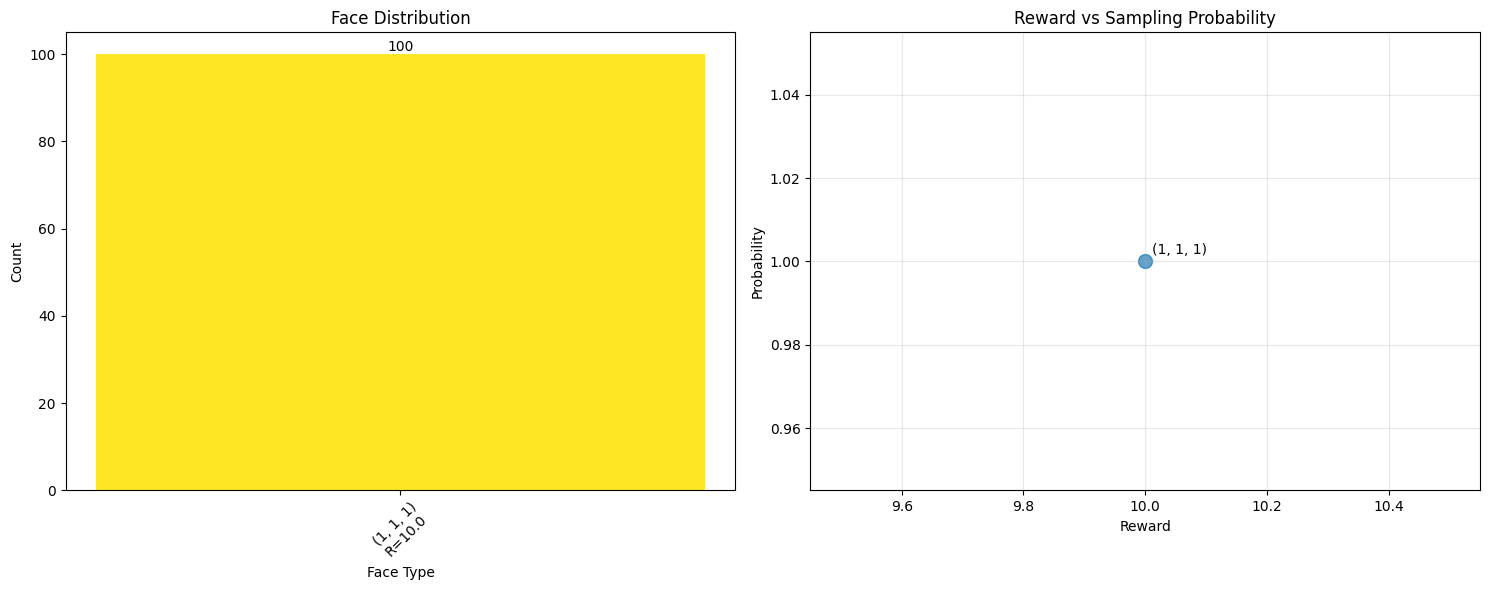


Face Summary (100 complete faces):
  (1, 1, 1) -> 100 (100.0%), reward=10.0


In [19]:
# ====================================================
# Test the environment
# ====================================================
if __name__ == "__main__":
    print("🎭 Testing Face Composition Environment")
    print("=" * 50)
    
    # Create environment
    env = FaceComposition()
    sampler = FaceTrajectorySampler(env)
    
    print(f"\nStart state: {env.start_state}")
    print(f"Valid actions from start: {env.get_valid_actions(env.start_state)}")
    
    # Test action taking
    state = env.start_state
    print(f"\nTesting actions:")
    print(f"  Current state: {state}")
    
    action = 'add_hair'
    next_state = env.take_action(state, action)
    print(f"  After {action}: {next_state}")
    
    action = 'add_eyes'
    final_state = env.take_action(next_state, action)
    print(f"  After {action}: {final_state}")
    
    action = 'add_mouth'
    complete_state = env.take_action(final_state, action)
    print(f"  After {action}: {complete_state}")
    
    print(f"  Is terminal: {env.is_terminal(complete_state)}")
    print(f"  Reward: {env.get_reward(complete_state)}")
    
    # Sample some trajectories
    print(f"\nSampling 10 random trajectories:")
    trajectories = sampler.sample_batch(10)
    
    for i, traj in enumerate(trajectories):
        reward = env.get_reward(traj[-1]) if env.is_terminal(traj[-1]) else 0
        terminal = "✓" if env.is_terminal(traj[-1]) else "✗"
        print(f"  Traj {i+1}: {traj} -> R={reward} {terminal}")
    
    # Visualize results
    print(f"\nTesting with 100 random trajectories...")
    test_trajectories = sampler.sample_batch(100)
    env.visualize_faces(test_trajectories, "Random Face Sampling")

---
# MLflow experiments

## Phisics based flow model

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np

def flow_conservation_loss(flow_net, visited_states, edges, rewards, encode_state, verbose=False):
    """Flow conservation loss - physics constraint"""
    total_loss = torch.tensor(0.0)
    
    for state in visited_states:
        flow_in = torch.tensor(0.0)
        flow_out = torch.tensor(0.0)
        
        # Flow IN
        for from_state, to_state in edges:
            if to_state == state:
                from_vec = encode_state(from_state)
                to_vec = encode_state(to_state)
                edge_input = torch.cat([from_vec, to_vec])
                predicted_flow = flow_net(edge_input).squeeze()
                flow_in += predicted_flow
        
        # Flow OUT (rewards + outgoing flows)
        if state in rewards:
            reward_flow = torch.tensor(rewards[state])
            flow_out += reward_flow
        
        for from_state, to_state in edges:
            if from_state == state:
                from_vec = encode_state(from_state)
                to_vec = encode_state(to_state)
                edge_input = torch.cat([from_vec, to_vec])
                predicted_flow = flow_net(edge_input).squeeze()
                flow_out += predicted_flow
        
        # Conservation constraint
        conservation_error = (flow_in - flow_out) ** 2
        total_loss += conservation_error
    
    return total_loss

def visualize_trajectories(trajectories, env, title="Trajectories", save_path=None):
    """Visualize trajectories on grid as heatmap"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create grid
    grid = np.zeros((env.size, env.size))
    
    # Count visits to each state
    visit_counts = {}
    for traj in trajectories:
        for state in traj:
            visit_counts[state] = visit_counts.get(state, 0) + 1
    
    # Fill grid with visit counts
    for (x, y), count in visit_counts.items():
        grid[env.size-1-y, x] = count  # Flip y for visualization
    
    # Plot heatmap
    im = ax.imshow(grid, cmap='Blues', origin='lower')
    
    # Mark start and reward region
    ax.scatter(env.start_state[0], env.start_state[1], c='green', s=200, marker='s', label='Start')
    
    # Mark entire reward region
    for state in env.reward_states:
        ax.scatter(state[0], state[1], c='red', s=200, marker='*', alpha=0.7)
    ax.scatter([], [], c='red', s=200, marker='*', label='Reward Region')  # For legend
    
    # Add grid lines
    ax.set_xticks(range(env.size))
    ax.set_yticks(range(env.size))
    ax.grid(True, alpha=0.3)
    
    # Labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend()
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Visit Count')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return fig

def visualize_individual_trajectories(trajectories, env, title="Individual Trajectories", save_path=None, max_trajectories=5):
    """Visualize individual trajectory paths on grid"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create base grid
    ax.set_xlim(-0.5, env.size - 0.5)
    ax.set_ylim(-0.5, env.size - 0.5)
    
    # Add grid lines
    for i in range(env.size + 1):
        ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
        ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)
    
    # Mark start and reward region
    ax.scatter(env.start_state[0], env.start_state[1], c='green', s=300, marker='s', label='Start', zorder=5)
    
    for state in env.reward_states:
        ax.add_patch(plt.Rectangle((state[0]-0.4, state[1]-0.4), 0.8, 0.8, 
                                 facecolor='red', alpha=0.3, zorder=1))
    ax.scatter([], [], c='red', s=200, marker='s', alpha=0.3, label='Reward Region')
    
    # Plot trajectories
    colors = plt.cm.Set1(np.linspace(0, 1, min(len(trajectories), max_trajectories)))
    
    for i, (traj, color) in enumerate(zip(trajectories[:max_trajectories], colors)):
        if len(traj) < 2:
            continue
            
        # Extract x, y coordinates
        xs, ys = zip(*traj)
        
        # Determine if successful
        success = traj[-1] in env.reward_states
        linestyle = '-' if success else '--'
        alpha = 0.8 if success else 0.5
        
        # Plot trajectory line
        ax.plot(xs, ys, color=color, linewidth=2, alpha=alpha, 
               linestyle=linestyle, label=f'Traj {i+1} ({"✓" if success else "✗"})')
        
        # Mark trajectory points
        ax.scatter(xs[1:-1], ys[1:-1], color=color, s=30, alpha=0.6, zorder=3)
        
        # Mark end point
        if success:
            ax.scatter(xs[-1], ys[-1], color=color, s=100, marker='o', 
                      edgecolor='black', linewidth=1, zorder=4)
        else:
            ax.scatter(xs[-1], ys[-1], color=color, s=100, marker='x', 
                      linewidth=2, zorder=4)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return fig

def find_best_trajectories(trajectories, env, n_best=3):
    """Find the best trajectories based on success and length"""
    successful = [traj for traj in trajectories if traj[-1] in env.reward_states]
    failed = [traj for traj in trajectories if traj[-1] not in env.reward_states]
    
    # Sort successful by length (shorter is better)
    successful.sort(key=len)
    
    # Sort failed by how close they got to reward region
    def distance_to_reward(traj):
        end_x, end_y = traj[-1]
        min_dist = float('inf')
        for rx, ry in env.reward_states:
            dist = abs(end_x - rx) + abs(end_y - ry)  # Manhattan distance
            min_dist = min(min_dist, dist)
        return min_dist
    
    failed.sort(key=distance_to_reward)
    
    # Return mix of best successful and best failed
    best_trajectories = []
    best_trajectories.extend(successful[:min(n_best, len(successful))])
    
    remaining_slots = n_best - len(best_trajectories)
    if remaining_slots > 0:
        best_trajectories.extend(failed[:remaining_slots])
    
    return best_trajectories

def sample_trajectory_from_flows(flow_net, env, encode_state, start_state, max_steps=20):
    """Sample trajectory using learned flow network"""
    trajectory = [start_state]
    state = start_state
    
    for _ in range(max_steps):
        if env.is_terminal(state):
            break
        
        valid_actions = env.get_valid_actions(state)
        if not valid_actions:
            break
        
        # Get flow predictions for all valid next states
        next_states = [env.take_action(state, action) for action in valid_actions]
        flows = []
        
        for next_state in next_states:
            from_vec = encode_state(state)
            to_vec = encode_state(next_state)
            edge_input = torch.cat([from_vec, to_vec])
            flow = flow_net(edge_input).squeeze()
            flows.append(flow.item())
        
        # Convert flows to probabilities
        flows = torch.tensor(flows)
        probs = torch.softmax(flows, dim=0)
        
        # Sample next state based on flow probabilities
        choice_idx = torch.multinomial(probs, 1).item()
        next_state = next_states[choice_idx]
        
        trajectory.append(next_state)
        state = next_state
    
    return trajectory

def run_hypergrid_experiment(lr=0.001, hidden_dim=128, n_steps=50, batch_size=32):
    """Run single HyperGrid experiment with MLflow tracking"""
    
    # Start MLflow run
    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("hidden_dim", hidden_dim)
        mlflow.log_param("n_steps", n_steps)
        mlflow.log_param("batch_size", batch_size)
        
        # Initialize environment
        env = HyperGrid(size=8)
        
        def encode_state(state):
            """Encode (x,y) state as one-hot vector"""
            x, y = state
            idx = y * env.size + x
            vec = [0.0] * (env.size * env.size)
            vec[idx] = 1.0
            return torch.tensor(vec, dtype=torch.float32)
        
        # Flow network
        state_dim = env.size * env.size
        flow_net = nn.Sequential(
            nn.Linear(state_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(), 
            nn.Linear(hidden_dim//2, 1),
            nn.Softplus()
        )
        
        optimizer = optim.Adam(flow_net.parameters(), lr=lr)
        
        # Set up rewards - all states in reward region get reward
        rewards = {}
        for state in env.reward_states:
            rewards[state] = 1.0
        
        print(f"Reward states: {sorted(rewards.keys())}")
        
        # Training metrics
        losses = []
        success_rates = []
        avg_lengths = []
        all_successful_trajectories = []  # Store ALL successful trajectories found during training
        
        print(f"Starting training: lr={lr}, hidden_dim={hidden_dim}")
        
        # Training loop
        for step in range(n_steps):
            # Sample trajectories
            trajectories = []
            for _ in range(batch_size):
                traj = env.sample_random_trajectory(max_steps=15)
                trajectories.append(traj)
                
                # Collect successful trajectories
                if traj[-1] in env.reward_states:
                    all_successful_trajectories.append(traj)
            
            # Extract edges and states
            edges = set()
            visited_states = set()
            for traj in trajectories:
                visited_states.update(traj)
                for i in range(len(traj) - 1):
                    edges.add((traj[i], traj[i + 1]))
            
            edges = list(edges)
            visited_states = list(visited_states)
            
            # Compute loss and update
            loss = flow_conservation_loss(flow_net, visited_states, edges, rewards, encode_state)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            # Evaluate every 10 steps
            if step % 10 == 0:
                # Generate samples and measure performance
                test_trajectories = []
                success_count = 0
                
                for _ in range(20):
                    traj = sample_trajectory_from_flows(flow_net, env, encode_state, env.start_state)
                    test_trajectories.append(traj)
                    success_count += (traj[-1] in env.reward_states)
                    
                    # Collect successful model trajectories too
                    if traj[-1] in env.reward_states:
                        all_successful_trajectories.append(traj)
                
                success_rate = success_count / 20
                avg_length = sum(len(traj) for traj in test_trajectories) / len(test_trajectories)
                
                success_rates.append(success_rate)
                avg_lengths.append(avg_length)
                
                # Log metrics
                mlflow.log_metric("loss", loss.item(), step=step)
                mlflow.log_metric("success_rate", success_rate, step=step)
                mlflow.log_metric("avg_trajectory_length", avg_length, step=step)
                
                print(f"Step {step}: Loss={loss.item():.4f}, Success={success_rate:.2%}, Avg Length={avg_length:.1f}, Total Successful Found: {len(all_successful_trajectories)}")
        
        # Final evaluation
        final_trajectories = []
        for _ in range(50):
            traj = sample_trajectory_from_flows(flow_net, env, encode_state, env.start_state)
            final_trajectories.append(traj)
            # Add final successful trajectories
            if traj[-1] in env.reward_states:
                all_successful_trajectories.append(traj)
        
        final_success_rate = sum(1 for traj in final_trajectories if traj[-1] in env.reward_states) / len(final_trajectories)
        final_avg_length = sum(len(traj) for traj in final_trajectories) / len(final_trajectories)
        
        # Log final metrics
        mlflow.log_metric("final_success_rate", final_success_rate)
        mlflow.log_metric("final_avg_length", final_avg_length)
        mlflow.log_metric("total_successful_trajectories_found", len(all_successful_trajectories))
        
        print(f"Total successful trajectories found during training: {len(all_successful_trajectories)}")
        
        # Create and log visualizations
        
        # 1. Training curves
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        
        ax1.plot(losses)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Flow Conservation Loss')
        ax1.grid(True)
        
        eval_steps = list(range(0, n_steps, 10))
        ax2.plot(eval_steps, success_rates, 'o-')
        ax2.set_title('Success Rate')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Success Rate')
        ax2.grid(True)
        
        ax3.plot(eval_steps, avg_lengths, 'o-')
        ax3.set_title('Average Trajectory Length')
        ax3.set_xlabel('Step')
        ax3.set_ylabel('Average Length')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.savefig("training_curves.png", dpi=150, bbox_inches='tight')
        mlflow.log_artifact("training_curves.png")
        plt.close()
        
        # 2. Final trajectories heatmap
        fig = visualize_trajectories(final_trajectories, env, 
                                   title=f"Final Trajectories Heatmap (Success: {final_success_rate:.1%})",
                                   save_path="final_trajectories_heatmap.png")
        mlflow.log_artifact("final_trajectories_heatmap.png")
        plt.close()
        
        # 3. ALL successful trajectories found during training
        if all_successful_trajectories:
            # Remove duplicates (same path)
            unique_successful = []
            seen_paths = set()
            for traj in all_successful_trajectories:
                path_tuple = tuple(traj)
                if path_tuple not in seen_paths:
                    unique_successful.append(traj)
                    seen_paths.add(path_tuple)
            
            print(f"Found {len(all_successful_trajectories)} successful trajectories ({len(unique_successful)} unique)")
            
            # Visualize all unique successful trajectories
            fig = visualize_individual_trajectories(
                unique_successful, env,
                title=f"All Unique Successful Trajectories Found During Training ({len(unique_successful)} paths)",
                save_path="all_successful_trajectories.png",
                max_trajectories=min(20, len(unique_successful))  # Limit to 20 for readability
            )
            mlflow.log_artifact("all_successful_trajectories.png")
            plt.close()
            
            # Also create a heatmap of just successful trajectories
            fig = visualize_trajectories(unique_successful, env,
                                       title=f"Successful Trajectories Heatmap ({len(unique_successful)} unique paths)",
                                       save_path="successful_trajectories_heatmap.png")
            mlflow.log_artifact("successful_trajectories_heatmap.png")
            plt.close()
            
            # Log trajectory statistics
            lengths = [len(traj) for traj in unique_successful]
            mlflow.log_metric("min_successful_length", min(lengths))
            mlflow.log_metric("max_successful_length", max(lengths))
            mlflow.log_metric("avg_successful_length", sum(lengths) / len(lengths))
            mlflow.log_metric("unique_successful_paths", len(unique_successful))
        else:
            print("No successful trajectories found during training!")
        
        # 4. Best individual trajectories from final evaluation
        best_trajectories = find_best_trajectories(final_trajectories, env, n_best=5)
        fig = visualize_individual_trajectories(best_trajectories, env,
                                              title="Best Individual Trajectories",
                                              save_path="best_trajectories.png")
        mlflow.log_artifact("best_trajectories.png")
        plt.close()
        
        # 5. Random baseline comparison
        random_trajectories = []
        for _ in range(50):
            traj = env.sample_random_trajectory(max_steps=20)
            random_trajectories.append(traj)
        
        fig = visualize_trajectories(random_trajectories, env, 
                                   title="Random Policy Trajectories",
                                   save_path="random_trajectories.png")
        mlflow.log_artifact("random_trajectories.png")
        plt.close()
        
        # 6. Best random trajectories for comparison
        best_random = find_best_trajectories(random_trajectories, env, n_best=5)
        fig = visualize_individual_trajectories(best_random, env,
                                              title="Best Random Trajectories",
                                              save_path="best_random_trajectories.png")
        mlflow.log_artifact("best_random_trajectories.png")
        plt.close()
        
        # Log model with input example
        example_from_state = encode_state((0, 0))  # Start state
        example_to_state = encode_state((1, 0))    # Adjacent state
        example_input = torch.cat([example_from_state, example_to_state]).unsqueeze(0)  # Add batch dim
        
        mlflow.pytorch.log_model(
            flow_net, 
            "flow_model",
            input_example=example_input.numpy()
        )
        
        print(f"Final Success Rate: {final_success_rate:.1%}")
        print(f"Final Avg Length: {final_avg_length:.1f}")
        
        return final_success_rate, final_avg_length

def run_hyperparameter_sweep():
    """Run hyperparameter sweep"""
    
    # Set up MLflow experiment
    mlflow.set_experiment("HyperGrid_GFlowNet")
    
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_dims = [64, 128, 256]
    
    results = []
    
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            print(f"\n{'='*50}")
            print(f"Running: lr={lr}, hidden_dim={hidden_dim}")
            print(f"{'='*50}")
            
            success_rate, avg_length = run_hypergrid_experiment(
                lr=lr, 
                hidden_dim=hidden_dim, 
                n_steps=100,
                batch_size=32
            )
            
            results.append({
                'lr': lr,
                'hidden_dim': hidden_dim,
                'success_rate': success_rate,
                'avg_length': avg_length
            })
    
    # Summary results
    results_df = pd.DataFrame(results)
    print("\n" + "="*60)
    print("HYPERPARAMETER SWEEP RESULTS")
    print("="*60)
    print(results_df.to_string(index=False))
    
    # Find best configuration
    best_config = results_df.loc[results_df['success_rate'].idxmax()]
    print(f"\nBest configuration:")
    print(f"  Learning Rate: {best_config['lr']}")
    print(f"  Hidden Dim: {best_config['hidden_dim']}")
    print(f"  Success Rate: {best_config['success_rate']:.1%}")
    print(f"  Avg Length: {best_config['avg_length']:.1f}")

if __name__ == "__main__":
    # Run single experiment
    run_hypergrid_experiment(lr=0.001, hidden_dim=128, n_steps=50)
    
    # Or run full hyperparameter sweep
    # run_hyperparameter_sweep()

Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Reward states: [(6, 6), (6, 7), (7, 6), (7, 7)]
Starting training: lr=0.001, hidden_dim=128
Step 0: Loss=6.2808, Success=0.00%, Avg Length=21.0, Total Successful Found: 0
Step 10: Loss=8.0818, Success=0.00%, Avg Length=21.0, Total Successful Found: 0
Step 20: Loss=5.5081, Success=0.00%, Avg Length=21.0, Total Successful Found: 0
Step 30: Loss=3.7721, Success=0.00%, Avg Length=21.0, Total Successful Found: 1
Step 40: Loss=3.3892, Success=0.00%, Avg Length=21.0, Total Successful Found: 1
Total successful trajectories found during training: 1
Found 1 successful trajectories (1 unique)
Final Success Rate: 0.0%
Final Avg Length: 21.0


In [75]:



def experiment_simple():
    """Everything else - network, training, data"""
    import torch
    import torch.nn as nn
    import torch.optim as optim
    # Setup for 8x8 grid
    grid_size = 8
    state_dim = grid_size * grid_size  # 64 states
    
    def encode_state(state):
        """Convert (x,y) state to one-hot vector"""
        x, y = state
        idx = y * grid_size + x
        vec = torch.zeros(state_dim)
        vec[idx] = 1.0
        return vec
    
    # Create flow network 
    flow_network = nn.Sequential(
        nn.Linear(state_dim * 2, 128),  # from_state + to_state
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Softplus()  # Ensure positive flows
    )
    
    optimizer = optim.Adam(flow_network.parameters(), lr=0.001)
    
    # Define example trajectories
    trajectories = [
        [(0, 0), (1, 0), (2, 0), (3, 0)],  # Moving right
        [(0, 0), (0, 1), (0, 2), (1, 2)],  # Moving up then right
        [(0, 0), (1, 0), (1, 1), (2, 1)],  # Mixed path
    ]
    
    # Define rewards (only terminal states)
    rewards = {
        (3, 0): 1.0,
        (1, 2): 0.5,
        (2, 1): 0.8
    }
    
    # Extract edges and states from trajectories
    def extract_edges_from_trajectories(trajectories):
        edges = set()
        for traj in trajectories:
            for i in range(len(traj) - 1):
                edges.add((traj[i], traj[i + 1]))
        return list(edges)
    
    def get_visited_states(trajectories):
        states = set()
        for traj in trajectories:
            states.update(traj)
        return list(states)
    
    edges = extract_edges_from_trajectories(trajectories)
    visited_states = get_visited_states(trajectories)
    
    print("Training GFlowNet...")
    print(f"Grid size: {grid_size}x{grid_size}")
    print(f"State encoding: one-hot vectors of size {state_dim}")
    print(f"Flow network input: concatenated states (size {state_dim * 2})")
    print(f"Trajectories: {len(trajectories)}")
    print(f"Edges: {len(edges)}")
    print(f"Visited states: {len(visited_states)}")
    print(f"Rewards: {rewards}")
    
    # Training loop
    for step in range(100):
        # Compute flow conservation loss
        loss = flow_conservation_loss(flow_network, visited_states, edges, rewards, encode_state)
        
        # Update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 20 == 0:
            print(f"Step {step}: Loss = {loss:.6f}")
    
    # Test predictions after training
    print("\nFlow predictions after training:")
    for from_state, to_state in edges[:5]:  # Show first 5 edges
        from_vec = encode_state(from_state)
        to_vec = encode_state(to_state)
        edge_input = torch.cat([from_vec, to_vec])
        flow = flow_network(edge_input).squeeze()
        print(f"Flow {from_state} → {to_state}: {flow.item():.4f}")
    
    print("\nDone!")

if __name__ == "__main__":
    experiment()

Training GFlowNet...
Grid size: 8x8
State encoding: one-hot vectors of size 64
Flow network input: concatenated states (size 128)
Trajectories: 3
Edges: 8
Visited states: 9
Rewards: {(3, 0): 1.0, (1, 2): 0.5, (2, 1): 0.8}

=== FLOW CONSERVATION ANALYSIS ===
 State  Flow_IN  Flow_OUT  Error   IN_Details                 OUT_Details
(0, 1)   0.7322    0.7277 0.0000 (0, 0)→0.732               →(0, 2):0.728
(1, 2)   0.7385    0.5000 0.0569 (0, 2)→0.738                       R:0.5
(2, 1)   0.7298    0.8000 0.0049 (1, 1)→0.730                       R:0.8
(0, 0)   0.0000    1.4593 2.1297         none →(0, 1):0.732,→(1, 0):0.727
(1, 1)   0.7396    0.7298 0.0001 (1, 0)→0.740               →(2, 1):0.730
(2, 0)   0.7412    0.7280 0.0002 (1, 0)→0.741               →(3, 0):0.728
(3, 0)   0.7280    1.0000 0.0740 (2, 0)→0.728                       R:1.0
(0, 2)   0.7277    0.7385 0.0001 (0, 1)→0.728               →(1, 2):0.738
(1, 0)   0.7271    1.4808 0.5680 (0, 0)→0.727 →(2, 0):0.741,→(1, 1):0.740

T

### Define Experiment

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np
import random

# ======================================================================
# Data Vis utilites
# ======================================================================
def draw_trajectories_on_grid(trajectories, env, title="Trajectories", save_path=None, max_trajectories=10):
    """
    Utility function to draw trajectories on grid
    
    Args:
        trajectories: List of trajectories (each trajectory is list of (x,y) states)
        env: Environment with reward_states and start_state
        title: Plot title
        save_path: If provided, saves plot to this path
        max_trajectories: Maximum number of trajectories to show
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    grid_size = env.size
    
    # Create base grid
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    
    # Add grid lines
    for i in range(grid_size + 1):
        ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
        ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)
    
    # Mark start state
    ax.scatter(env.start_state[0], env.start_state[1], c='green', s=300, 
              marker='s', label='Start', zorder=5, edgecolor='black', linewidth=2)
    
    # Mark reward region
    for state in env.reward_states:
        ax.add_patch(plt.Rectangle((state[0]-0.4, state[1]-0.4), 0.8, 0.8, 
                                 facecolor='red', alpha=0.3, zorder=1))
    ax.scatter([], [], c='red', s=200, marker='s', alpha=0.3, label='Reward Region')
    
    # Plot trajectories
    colors = plt.cm.Set1(np.linspace(0, 1, min(len(trajectories), max_trajectories)))
    
    for i, (traj, color) in enumerate(zip(trajectories[:max_trajectories], colors)):
        if len(traj) < 2:
            continue
            
        # Extract x, y coordinates
        xs, ys = zip(*traj)
        
        # Determine if successful
        success = traj[-1] in env.reward_states
        linestyle = '-' if success else '--'
        alpha = 0.8 if success else 0.5
        linewidth = 3 if success else 2
        
        # Plot trajectory line
        ax.plot(xs, ys, color=color, linewidth=linewidth, alpha=alpha, 
               linestyle=linestyle, label=f'Traj {i+1} ({"✓" if success else "✗"}, len={len(traj)})')
        
        # Mark trajectory points (smaller for intermediate points)
        ax.scatter(xs[1:-1], ys[1:-1], color=color, s=20, alpha=0.6, zorder=3)
        
        # Mark end point
        if success:
            ax.scatter(xs[-1], ys[-1], color=color, s=150, marker='o', 
                      edgecolor='black', linewidth=2, zorder=4)
        else:
            ax.scatter(xs[-1], ys[-1], color=color, s=100, marker='x', 
                      linewidth=3, zorder=4)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('equal')
    
    # Add grid coordinates for reference
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return fig

# ======================================================================
# **Start MLFLOW Experiment**
# ======================================================================

def mlflow_experiment(lr=0.001, hidden_dim=128, n_steps=100, batch_size=32):
    """MLflow tracked experiment"""
    

    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("hidden_dim", hidden_dim)
        mlflow.log_param("n_steps", n_steps)
        mlflow.log_param("batch_size", batch_size)
        
        # Setup for 8x8 grid
        grid_size = 8
        state_dim = grid_size * grid_size  # 64 states
        
        mlflow.log_param("grid_size", grid_size)
        mlflow.log_param("state_dim", state_dim)
        
        def encode_state(state):
            """Convert (x,y) state to one-hot vector"""
            x, y = state
            idx = y * grid_size + x
            vec = torch.zeros(state_dim)
            vec[idx] = 1.0
            return vec
        
        # ======================================================================
        # Initialize Grid World
        # ======================================================================
        
        env = HyperGrid(size=grid_size, reward_region_size=2)
        trajectory_sampler = GridTrajectorySampler(env)
        
        # Get rewards from environment
        rewards = {}
        for state in env.reward_states:
            rewards[state] = env.get_reward(state)
        
        # ======================================================================
        # Create flow forward network 
        # ======================================================================
        flow_network = nn.Sequential(
            nn.Linear(state_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Softplus()
        )
        
        optimizer = optim.Adam(flow_network.parameters(), lr=lr)
        
        mlflow.log_param("num_reward_states", len(rewards))
        
        # Extract edges and states from trajectories helper functions
        def extract_edges_from_trajectories(trajectories):
            edges = set()
            for traj in trajectories:
                for i in range(len(traj) - 1):
                    edges.add((traj[i], traj[i + 1]))
            return list(edges)
        
        def get_visited_states(trajectories):
            states = set()
            for traj in trajectories:
                states.update(traj)
            return list(states)
        
        print(f"Training GFlowNet with lr={lr}, hidden_dim={hidden_dim}")
        print(f"Grid: {grid_size}x{grid_size}, Reward region: {sorted(env.reward_states)}")
        
        # Training loop with logging
        losses = []
        all_trajectories = []
        successful_trajectories = []  # Track successful trajectories separately
        
        # ======================================================================
        # Start Training
        # ======================================================================
        for step in range(n_steps):
            step_trajectories = []
            
            # ======================================================================
            # Sample grid world
            # ======================================================================
            step_trajectories = trajectory_sampler.sample_batch(batch_size, max_steps=15)
            all_trajectories.extend(step_trajectories)
            
            # Collect successful trajectories
            for traj in step_trajectories:
                if env.is_terminal(traj[-1]):
                    successful_trajectories.append(traj)
            
            edges = extract_edges_from_trajectories(step_trajectories)
            visited_states = get_visited_states(step_trajectories)
            
            if not edges:  # Skip if no edges (shouldn't happen)
                continue
            
            # ======================================================================
            # Compute Loss
            # ======================================================================
            loss = flow_conservation_loss(flow_network, visited_states, edges, rewards, encode_state)
            
            # Update network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_value = loss.item()
            losses.append(loss_value)
            
            # ======================================================================
            # Log metrics
            # ======================================================================
            if step % 10 == 0:
                mlflow.log_metric("loss", loss_value, step=step)
                
                # Calculate success rate from recent trajectories
                success_count = sum(1 for traj in step_trajectories if traj[-1] in rewards)
                success_rate = success_count / len(step_trajectories)
                mlflow.log_metric("success_rate", success_rate, step=step)
                
                avg_length = sum(len(traj) for traj in step_trajectories) / len(step_trajectories)
                mlflow.log_metric("avg_trajectory_length", avg_length, step=step)
                
                print(f"Step {step}: Loss={loss_value:.6f}, Success={success_rate:.2%}, Avg Length={avg_length:.1f}")
        
        # ======================================================================
        # End Experiment
        # ======================================================================
        final_loss = losses[-1]
        avg_loss = sum(losses) / len(losses)
        min_loss = min(losses)
        
        mlflow.log_metric("final_loss", final_loss)
        mlflow.log_metric("avg_loss", avg_loss)
        mlflow.log_metric("min_loss", min_loss)
        
        # Calculate overall success rate
        total_successful = sum(1 for traj in all_trajectories if traj[-1] in rewards)
        overall_success_rate = total_successful / len(all_trajectories)
        mlflow.log_metric("overall_success_rate", overall_success_rate)
        mlflow.log_metric("total_trajectories_sampled", len(all_trajectories))
        
        # Create and log loss plot
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.title('Training Loss Over Time')
        plt.xlabel('Step')
        plt.ylabel('Flow Conservation Loss')
        plt.grid(True)
        plt.savefig("loss_curve.png", dpi=150, bbox_inches='tight')
        mlflow.log_artifact("loss_curve.png")
        plt.close()
        
        # Test final flow predictions on a sample of edges
        final_edges = extract_edges_from_trajectories(all_trajectories[-100:])  # Last 100 trajectories
        print(f"\nFlow predictions after training (sample of {min(10, len(final_edges))} edges):")
        
        for i, (from_state, to_state) in enumerate(final_edges[:10]):
            from_vec = encode_state(from_state)
            to_vec = encode_state(to_state)
            edge_input = torch.cat([from_vec, to_vec])
            flow = flow_network(edge_input).squeeze()
            flow_value = flow.item()
            print(f"Flow {from_state} → {to_state}: {flow_value:.4f}")
        
        # ======================================================================
        # Log successful trajectories as artifact
        # ======================================================================
        if successful_trajectories:
            # Remove duplicates
            unique_successful = []
            seen_paths = set()
            for traj in successful_trajectories:
                path_tuple = tuple(traj)
                if path_tuple not in seen_paths:
                    unique_successful.append(traj)
                    seen_paths.add(path_tuple)
            
            # Create trajectories text file
            with open("successful_trajectories.txt", "w") as f:
                f.write(f"Successful Trajectories Found During Training\n")
                f.write(f"="*50 + "\n")
                f.write(f"Total successful: {len(successful_trajectories)}\n")
                f.write(f"Unique successful: {len(unique_successful)}\n")
                f.write(f"Success rate: {len(successful_trajectories)/len(all_trajectories)*100:.1f}%\n\n")
                
                for i, traj in enumerate(unique_successful[:20]):  # Show top 20
                    f.write(f"Trajectory {i+1}: {traj}\n")
                    f.write(f"  Length: {len(traj)} steps\n")
                    f.write(f"  End state: {traj[-1]} (reward: {env.get_reward(traj[-1])})\n\n")
            
            mlflow.log_artifact("successful_trajectories.txt")
            mlflow.log_metric("unique_successful_trajectories", len(unique_successful))
            
            # ======================================================================
            # Visualize successful trajectories
            # ======================================================================
            if len(unique_successful) > 0:
                # Draw successful trajectories
                draw_trajectories_on_grid(
                    unique_successful[:10],  # Show top 10 successful trajectories
                    env,
                    title=f"Successful Trajectories (showing {min(10, len(unique_successful))} of {len(unique_successful)})",
                    save_path="successful_trajectories_viz.png",
                    max_trajectories=10
                )
                mlflow.log_artifact("successful_trajectories_viz.png")
                
                # Also draw a comparison with some failed trajectories
                failed_trajectories = [traj for traj in all_trajectories[-50:] if traj[-1] not in env.reward_states]
                if failed_trajectories:
                    mixed_trajectories = unique_successful[:5] + failed_trajectories[:5]
                    draw_trajectories_on_grid(
                        mixed_trajectories,
                        env,
                        title="Successful vs Failed Trajectories",
                        save_path="success_vs_failed_trajectories.png",
                        max_trajectories=10
                    )
                    mlflow.log_artifact("success_vs_failed_trajectories.png")
            
            print(f"Found {len(successful_trajectories)} successful trajectories ({len(unique_successful)} unique)")
        else:
            print("No successful trajectories found!")
            
            # Still draw some failed trajectories to see what's happening
            recent_trajectories = all_trajectories[-10:]
            draw_trajectories_on_grid(
                recent_trajectories,
                env,
                title="Recent Trajectories (No Successful Found)",
                save_path="recent_trajectories.png",
                max_trajectories=10
            )
            mlflow.log_artifact("recent_trajectories.png")
        
        # Create example input for model logging
        example_from_state = encode_state((0, 0))
        example_to_state = encode_state((1, 0))
        example_input = torch.cat([example_from_state, example_to_state]).unsqueeze(0)
        
        # Log the model
        mlflow.pytorch.log_model(
            flow_network,
            "flow_model",
            input_example=example_input.numpy()
        )
        
        print(f"\nFinal Loss: {final_loss:.6f}")
        print(f"Overall Success Rate: {overall_success_rate:.2%}")
        print(f"Total Trajectories: {len(all_trajectories)}")
        
        return final_loss

### Run Sweep

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np
import random

def run_hyperparameter_sweep():
    """Run hyperparameter sweep with MLflow - ALL RUNS IN ONE EXPERIMENT"""
    
    # NOTE: Experiment should already be set before calling this function
    
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_dims = [64, 128, 256]
    
    results = []
    
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            print(f"\n{'='*50}")
            print(f"Running: lr={lr}, hidden_dim={hidden_dim}")
            print(f"{'='*50}")
            
            final_loss = mlflow_experiment(lr=lr, hidden_dim=hidden_dim, n_steps=50000)
            
            results.append({
                'lr': lr,
                'hidden_dim': hidden_dim,
                'final_loss': final_loss
            })
    
    # Print summary
    print(f"\n{'='*60}")
    print("HYPERPARAMETER SWEEP RESULTS")
    print(f"{'='*60}")
    for result in results:
        print(f"lr={result['lr']}, hidden_dim={result['hidden_dim']}, final_loss={result['final_loss']:.6f}")
    
    # Find best configuration
    best_result = min(results, key=lambda x: x['final_loss'])
    print(f"\nBest configuration:")
    print(f"  Learning Rate: {best_result['lr']}")
    print(f"  Hidden Dim: {best_result['hidden_dim']}")
    print(f"  Final Loss: {best_result['final_loss']:.6f}")
    
    # Log summary as artifact (will go to last run, which is fine)
    with open("sweep_summary.txt", "w") as f:
        f.write("Hyperparameter Sweep Summary\n")
        f.write("="*40 + "\n\n")
        
        f.write("All Results:\n")
        for result in results:
            f.write(f"lr={result['lr']}, hidden_dim={result['hidden_dim']}, final_loss={result['final_loss']:.6f}\n")
        
        f.write(f"\nBest Configuration:\n")
        f.write(f"Learning Rate: {best_result['lr']}\n")
        f.write(f"Hidden Dim: {best_result['hidden_dim']}\n")
        f.write(f"Final Loss: {best_result['final_loss']:.6f}\n")
    
    print("Sweep completed! Check MLflow UI for detailed results.")

if __name__ == "__main__":
    # ======================================================================
    # Jupyter Notebook Safe MLflow Setup
    # ======================================================================
    
    # End any existing runs (important for Jupyter notebooks)
    try:
        mlflow.end_run()
    except:
        pass  # No active run to end
    
    # Set experiment ONCE before running anything
    mlflow.set_experiment("GFlowNet_Flow_Conservation")
    
    # Run single experiment
    # mlflow_experiment(lr=0.001, hidden_dim=128, n_steps=100)
    
    # Or run hyperparameter sweep
    run_hyperparameter_sweep()
    
    # Clean up after sweep (good practice for notebooks)
    try:
        mlflow.end_run()
    except:
        pass

## Trajectory Based Model

### Experiment Definition

In [ ]:
from hypergrid_trajectory_balance_experiment import trajectory_balance_experiment

# ====================================================
# Main Execution
# ====================================================

if __name__ == "__main__":
    # MLflow setup
    try:
        mlflow.end_run()
    except:
        pass
    
    mlflow.set_experiment("Trajectory_Balance_GFlowNet")
    
    # Run single experiment
    trajectory_balance_experiment(lr=0.001, hidden_dim=128, n_steps=1000)
    
    # Or run hyperparameter sweep
    # run_trajectory_balance_sweep()
    
    # Clean up
    try:
        mlflow.end_run()
    except:
        pass


# sandbox

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import sys

def draw_trajectories_on_grid(trajectories, env, title="Trajectories", save_path=None, max_trajectories=10):
    """
    Utility function to draw trajectories on grid
    
    Args:
        trajectories: List of trajectories (each trajectory is list of (x,y) states)
        env: Environment with reward_states and start_state
        title: Plot title
        save_path: If provided, saves plot to this path
        max_trajectories: Maximum number of trajectories to show
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    grid_size = env.size
    
    # Create base grid
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    
    # Add grid lines
    for i in range(grid_size + 1):
        ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
        ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)
    
    # Mark start state
    ax.scatter(env.start_state[0], env.start_state[1], c='green', s=300, 
              marker='s', label='Start', zorder=5, edgecolor='black', linewidth=2)
    
    # Mark reward region
    for state in env.reward_states:
        ax.add_patch(plt.Rectangle((state[0]-0.4, state[1]-0.4), 0.8, 0.8, 
                                 facecolor='red', alpha=0.3, zorder=1))
    ax.scatter([], [], c='red', s=200, marker='s', alpha=0.3, label='Reward Region')
    
    # Plot trajectories
    colors = plt.cm.Set1(np.linspace(0, 1, min(len(trajectories), max_trajectories)))
    
    for i, (traj, color) in enumerate(zip(trajectories[:max_trajectories], colors)):
        if len(traj) < 2:
            continue
            
        # Extract x, y coordinates
        xs, ys = zip(*traj)
        
        # Determine if successful
        success = traj[-1] in env.reward_states
        linestyle = '-' if success else '--'
        alpha = 0.8 if success else 0.5
        linewidth = 3 if success else 2
        
        # Plot trajectory line
        ax.plot(xs, ys, color=color, linewidth=linewidth, alpha=alpha, 
               linestyle=linestyle, label=f'Traj {i+1} ({"✓" if success else "✗"}, len={len(traj)})')
        
        # Mark trajectory points (smaller for intermediate points)
        ax.scatter(xs[1:-1], ys[1:-1], color=color, s=20, alpha=0.6, zorder=3)
        
        # Mark end point
        if success:
            ax.scatter(xs[-1], ys[-1], color=color, s=150, marker='o', 
                      edgecolor='black', linewidth=2, zorder=4)
        else:
            ax.scatter(xs[-1], ys[-1], color=color, s=100, marker='x', 
                      linewidth=3, zorder=4)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('equal')
    
    # Add grid coordinates for reference
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return fig

def flow_conservation_loss(flow_network, visited_states, edges, rewards, encode_state_fn):
    """Flow conservation loss - physics constraint"""
    total_loss = torch.tensor(0.0)
    
    for state in visited_states:
        flow_in = torch.tensor(0.0)
        flow_out = torch.tensor(0.0)
        
        # Flow IN - sum all flows coming into this state
        for from_state, to_state in edges:
            if to_state == state:
                from_vec = encode_state_fn(from_state)
                to_vec = encode_state_fn(to_state)
                edge_input = torch.cat([from_vec, to_vec])
                flow_in += flow_network(edge_input).squeeze()
        
        # Flow OUT - rewards + outgoing flows
        if state in rewards:
            flow_out += torch.tensor(rewards[state])
        
        for from_state, to_state in edges:
            if from_state == state:
                from_vec = encode_state_fn(from_state)
                to_vec = encode_state_fn(to_state)
                edge_input = torch.cat([from_vec, to_vec])
                flow_out += flow_network(edge_input).squeeze()
        
        # Conservation constraint: Flow IN = Flow OUT
        conservation_error = (flow_in - flow_out) ** 2
        total_loss += conservation_error
    
    return total_loss

class GridTrajectorySampler:
    """Samples random trajectories using environment API"""
    
    def __init__(self, env):
        self.env = env
    
    def sample_trajectory(self, max_steps=15):
        """Sample a single random trajectory using environment"""
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            # Random action selection
            action = random.choice(valid_actions)
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size, max_steps=15):
        """Sample a batch of trajectories"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories

def mlflow_experiment(lr=0.001, hidden_dim=128, n_steps=100, batch_size=32):
    """MLflow tracked experiment - NOTE: Experiment must be set before calling this"""
    
    # ======================================================================
    # Start MLFLOW Run (not experiment - that should be set already)
    # ======================================================================
    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("hidden_dim", hidden_dim)
        mlflow.log_param("n_steps", n_steps)
        mlflow.log_param("batch_size", batch_size)
        
        # Setup for 8x8 grid
        grid_size = 8
        state_dim = grid_size * grid_size  # 64 states
        
        mlflow.log_param("grid_size", grid_size)
        mlflow.log_param("state_dim", state_dim)
        
        def encode_state(state):
            """Convert (x,y) state to one-hot vector"""
            x, y = state
            idx = y * grid_size + x
            vec = torch.zeros(state_dim)
            vec[idx] = 1.0
            return vec
        
        # ======================================================================
        # Experiment's Sampling methodology for gridworld env
        # ======================================================================
        
        # Import environment and create trajectory sampler
        env = HyperGrid(size=grid_size, reward_region_size=2)
        trajectory_sampler = GridTrajectorySampler(env)
        
        # Get rewards from environment
        rewards = {}
        for state in env.reward_states:
            rewards[state] = env.get_reward(state)
        
        # ======================================================================
        # Create flow network 
        # ======================================================================
        flow_network = nn.Sequential(
            nn.Linear(state_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Softplus()
        )
        
        optimizer = optim.Adam(flow_network.parameters(), lr=lr)
        
        mlflow.log_param("num_reward_states", len(rewards))
        
        # Extract edges and states from trajectories helper functions
        def extract_edges_from_trajectories(trajectories):
            edges = set()
            for traj in trajectories:
                for i in range(len(traj) - 1):
                    edges.add((traj[i], traj[i + 1]))
            return list(edges)
        
        def get_visited_states(trajectories):
            states = set()
            for traj in trajectories:
                states.update(traj)
            return list(states)
        
        print(f"Training GFlowNet with lr={lr}, hidden_dim={hidden_dim}, n_steps={n_steps}")
        print(f"Grid: {grid_size}x{grid_size}, Reward region: {sorted(env.reward_states)}")
        
        # Training loop with logging
        losses = []
        all_trajectories = []
        successful_trajectories = []  # Track successful trajectories separately
        
        # ======================================================================
        # Start Training with Progress Bar
        # ======================================================================
        
        # Create progress bar
        pbar = tqdm(range(n_steps), desc=f"Training (lr={lr}, hid={hidden_dim})")
        
        for step in pbar:
            step_trajectories = []
            
            # ======================================================================
            # Sample grid world
            # ======================================================================
            step_trajectories = trajectory_sampler.sample_batch(batch_size, max_steps=15)
            all_trajectories.extend(step_trajectories)
            
            # Collect successful trajectories
            for traj in step_trajectories:
                if env.is_terminal(traj[-1]):
                    successful_trajectories.append(traj)
            
            edges = extract_edges_from_trajectories(step_trajectories)
            visited_states = get_visited_states(step_trajectories)
            
            if not edges:  # Skip if no edges (shouldn't happen)
                continue
            
            # ======================================================================
            # Compute Loss
            # ======================================================================
            loss = flow_conservation_loss(flow_network, visited_states, edges, rewards, encode_state)
            
            # Update network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_value = loss.item()
            losses.append(loss_value)
            
            # Update progress bar with current stats
            success_count = sum(1 for traj in step_trajectories if env.is_terminal(traj[-1]))
            success_rate = success_count / len(step_trajectories)
            avg_length = sum(len(traj) for traj in step_trajectories) / len(step_trajectories)
            
            # Update progress bar description with current metrics
            pbar.set_postfix({
                'Loss': f'{loss_value:.4f}',
                'Success': f'{success_rate:.1%}',
                'AvgLen': f'{avg_length:.1f}',
                'TotalSucc': len(successful_trajectories)
            })
            
            # ======================================================================
            # Log metrics (less frequently for long runs)
            # ======================================================================
            log_interval = max(1, n_steps // 50)  # Log ~50 times total, minimum every step
            if step % log_interval == 0:
                mlflow.log_metric("loss", loss_value, step=step)
                mlflow.log_metric("success_rate", success_rate, step=step)
                mlflow.log_metric("avg_trajectory_length", avg_length, step=step)
        
        pbar.close()
        print(f"✓ Training completed!")
        
        # ======================================================================
        # End Experiment
        # ======================================================================
        final_loss = losses[-1]
        avg_loss = sum(losses) / len(losses)
        min_loss = min(losses)
        
        mlflow.log_metric("final_loss", final_loss)
        mlflow.log_metric("avg_loss", avg_loss)
        mlflow.log_metric("min_loss", min_loss)
        
        # Calculate overall success rate
        total_successful = sum(1 for traj in all_trajectories if traj[-1] in rewards)
        overall_success_rate = total_successful / len(all_trajectories)
        mlflow.log_metric("overall_success_rate", overall_success_rate)
        mlflow.log_metric("total_trajectories_sampled", len(all_trajectories))
        
        # Create and log loss plot
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.title('Training Loss Over Time')
        plt.xlabel('Step')
        plt.ylabel('Flow Conservation Loss')
        plt.grid(True)
        plt.savefig("loss_curve.png", dpi=150, bbox_inches='tight')
        mlflow.log_artifact("loss_curve.png")
        plt.close()
        
        # Test final flow predictions on a sample of edges
        final_edges = extract_edges_from_trajectories(all_trajectories[-100:])  # Last 100 trajectories
        print(f"\nFlow predictions after training (sample of {min(10, len(final_edges))} edges):")
        
        for i, (from_state, to_state) in enumerate(final_edges[:10]):
            from_vec = encode_state(from_state)
            to_vec = encode_state(to_state)
            edge_input = torch.cat([from_vec, to_vec])
            flow = flow_network(edge_input).squeeze()
            flow_value = flow.item()
            print(f"Flow {from_state} → {to_state}: {flow_value:.4f}")
        
        # ======================================================================
        # Log successful trajectories as artifact
        # ======================================================================
        if successful_trajectories:
            # Remove duplicates
            unique_successful = []
            seen_paths = set()
            for traj in successful_trajectories:
                path_tuple = tuple(traj)
                if path_tuple not in seen_paths:
                    unique_successful.append(traj)
                    seen_paths.add(path_tuple)
            
            # Create trajectories text file
            with open("successful_trajectories.txt", "w") as f:
                f.write(f"Successful Trajectories Found During Training\n")
                f.write(f"="*50 + "\n")
                f.write(f"Total successful: {len(successful_trajectories)}\n")
                f.write(f"Unique successful: {len(unique_successful)}\n")
                f.write(f"Success rate: {len(successful_trajectories)/len(all_trajectories)*100:.1f}%\n\n")
                
                for i, traj in enumerate(unique_successful[:20]):  # Show top 20
                    f.write(f"Trajectory {i+1}: {traj}\n")
                    f.write(f"  Length: {len(traj)} steps\n")
                    f.write(f"  End state: {traj[-1]} (reward: {env.get_reward(traj[-1])})\n\n")
            
            mlflow.log_artifact("successful_trajectories.txt")
            mlflow.log_metric("unique_successful_trajectories", len(unique_successful))
            
            # ======================================================================
            # Visualize successful trajectories
            # ======================================================================
            if len(unique_successful) > 0:
                # Draw successful trajectories
                draw_trajectories_on_grid(
                    unique_successful[:10],  # Show top 10 successful trajectories
                    env,
                    title=f"Successful Trajectories (showing {min(10, len(unique_successful))} of {len(unique_successful)})",
                    save_path="successful_trajectories_viz.png",
                    max_trajectories=10
                )
                mlflow.log_artifact("successful_trajectories_viz.png")
                
                # Also draw a comparison with some failed trajectories
                failed_trajectories = [traj for traj in all_trajectories[-50:] if traj[-1] not in env.reward_states]
                if failed_trajectories:
                    mixed_trajectories = unique_successful[:5] + failed_trajectories[:5]
                    draw_trajectories_on_grid(
                        mixed_trajectories,
                        env,
                        title="Successful vs Failed Trajectories",
                        save_path="success_vs_failed_trajectories.png",
                        max_trajectories=10
                    )
                    mlflow.log_artifact("success_vs_failed_trajectories.png")
            
            print(f"Found {len(successful_trajectories)} successful trajectories ({len(unique_successful)} unique)")
        else:
            print("No successful trajectories found!")
            
            # Still draw some failed trajectories to see what's happening
            recent_trajectories = all_trajectories[-10:]
            draw_trajectories_on_grid(
                recent_trajectories,
                env,
                title="Recent Trajectories (No Successful Found)",
                save_path="recent_trajectories.png",
                max_trajectories=10
            )
            mlflow.log_artifact("recent_trajectories.png")
        
        # Create example input for model logging
        example_from_state = encode_state((0, 0))
        example_to_state = encode_state((1, 0))
        example_input = torch.cat([example_from_state, example_to_state]).unsqueeze(0)
        
        # Log the model
        mlflow.pytorch.log_model(
            flow_network,
            "flow_model",
            input_example=example_input.numpy()
        )
        
        print(f"\nFinal Loss: {final_loss:.6f}")
        print(f"Overall Success Rate: {overall_success_rate:.2%}")
        print(f"Total Trajectories: {len(all_trajectories)}")
        
        return final_loss

def run_hyperparameter_sweep():
    """Run hyperparameter sweep with MLflow - ALL RUNS IN ONE EXPERIMENT"""
    
    # NOTE: Experiment should already be set before calling this function
    
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_dims = [64, 128, 256]
    
    results = []
    
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            print(f"\n{'='*50}")
            print(f"Running: lr={lr}, hidden_dim={hidden_dim}")
            print(f"{'='*50}")
            
            final_loss = mlflow_experiment(lr=lr, hidden_dim=hidden_dim, n_steps=10000)
            
            results.append({
                'lr': lr,
                'hidden_dim': hidden_dim,
                'final_loss': final_loss
            })
    
    # Print summary
    print(f"\n{'='*60}")
    print("HYPERPARAMETER SWEEP RESULTS")
    print(f"{'='*60}")
    for result in results:
        print(f"lr={result['lr']}, hidden_dim={result['hidden_dim']}, final_loss={result['final_loss']:.6f}")
    
    # Find best configuration
    best_result = min(results, key=lambda x: x['final_loss'])
    print(f"\nBest configuration:")
    print(f"  Learning Rate: {best_result['lr']}")
    print(f"  Hidden Dim: {best_result['hidden_dim']}")
    print(f"  Final Loss: {best_result['final_loss']:.6f}")
    
    # Log summary as artifact (will go to last run, which is fine)
    with open("sweep_summary.txt", "w") as f:
        f.write("Hyperparameter Sweep Summary\n")
        f.write("="*40 + "\n\n")
        
        f.write("All Results:\n")
        for result in results:
            f.write(f"lr={result['lr']}, hidden_dim={result['hidden_dim']}, final_loss={result['final_loss']:.6f}\n")
        
        f.write(f"\nBest Configuration:\n")
        f.write(f"Learning Rate: {best_result['lr']}\n")
        f.write(f"Hidden Dim: {best_result['hidden_dim']}\n")
        f.write(f"Final Loss: {best_result['final_loss']:.6f}\n")
    
    print("Sweep completed! Check MLflow UI for detailed results.")

if __name__ == "__main__":
    # ======================================================================
    # Jupyter Notebook Safe MLflow Setup
    # ======================================================================
    
    # End any existing runs (important for Jupyter notebooks)
    try:
        mlflow.end_run()
    except:
        pass  # No active run to end
    
    # Set experiment ONCE before running anything
    mlflow.set_experiment("GFlowNet_Flow_Conservation")
    
    # Run single experiment
    # mlflow_experiment(lr=0.001, hidden_dim=128, n_steps=100)
    
    # Or run hyperparameter sweep
    run_hyperparameter_sweep()
    
    # Clean up after sweep (good practice for notebooks)
    try:
        mlflow.end_run()
    except:
        pass


Running: lr=0.01, hidden_dim=64
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.01, hidden_dim=64, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.01, hid=64): 100%|██████████| 10000/10000 [02:30<00:00, 66.33it/s, Loss=0.0000, Success=0.0%, AvgLen=16.0, TotalSucc=467]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0000
Flow (0, 5) → (0, 6): 0.0000
Flow (6, 0) → (6, 1): 0.0000
Flow (2, 6) → (1, 6): 0.0000
Flow (2, 2) → (3, 2): 0.0000
Flow (2, 7) → (3, 7): 0.0000
Flow (3, 2) → (4, 2): 0.0000
Flow (3, 4) → (2, 4): 0.0000
Flow (1, 0) → (2, 0): 0.0000
Flow (5, 5) → (6, 5): 0.0000
Found 467 successful trajectories (463 unique)

Final Loss: 0.000000
Overall Success Rate: 0.15%
Total Trajectories: 320000

Running: lr=0.01, hidden_dim=128
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.01, hidden_dim=128, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.01, hid=128): 100%|██████████| 10000/10000 [02:35<00:00, 64.43it/s, Loss=0.0000, Success=0.0%, AvgLen=16.0, TotalSucc=459]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0000
Flow (0, 5) → (0, 6): 0.0000
Flow (6, 0) → (6, 1): 0.0000
Flow (2, 2) → (3, 2): 0.0000
Flow (2, 4) → (1, 4): 0.0000
Flow (2, 7) → (3, 7): 0.0000
Flow (3, 2) → (4, 2): 0.0000
Flow (3, 4) → (2, 4): 0.0000
Flow (1, 0) → (2, 0): 0.0000
Flow (3, 1) → (4, 1): 0.0000
Found 459 successful trajectories (456 unique)

Final Loss: 0.000000
Overall Success Rate: 0.14%
Total Trajectories: 320000

Running: lr=0.01, hidden_dim=256
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.01, hidden_dim=256, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.01, hid=256): 100%|██████████| 10000/10000 [02:52<00:00, 58.00it/s, Loss=0.0000, Success=0.0%, AvgLen=16.0, TotalSucc=417]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0000
Flow (0, 5) → (0, 6): 0.0000
Flow (2, 6) → (1, 6): 0.0000
Flow (2, 2) → (3, 2): 0.0000
Flow (2, 4) → (1, 4): 0.0000
Flow (3, 2) → (4, 2): 0.0000
Flow (1, 0) → (2, 0): 0.0000
Flow (3, 1) → (4, 1): 0.0000
Flow (0, 2) → (0, 3): 0.0000
Flow (4, 1) → (4, 2): 0.0000
Found 417 successful trajectories (414 unique)

Final Loss: 0.000000
Overall Success Rate: 0.13%
Total Trajectories: 320000

Running: lr=0.001, hidden_dim=64
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.001, hidden_dim=64, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.001, hid=64): 100%|██████████| 10000/10000 [02:33<00:00, 65.15it/s, Loss=0.0000, Success=0.0%, AvgLen=16.0, TotalSucc=462]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0001
Flow (0, 5) → (0, 6): 0.0002
Flow (6, 0) → (6, 1): 0.0001
Flow (2, 6) → (1, 6): 0.0003
Flow (2, 2) → (3, 2): 0.0003
Flow (2, 4) → (1, 4): 0.0002
Flow (3, 4) → (2, 4): 0.0002
Flow (3, 2) → (4, 2): 0.0001
Flow (2, 7) → (3, 7): 0.0012
Flow (1, 0) → (2, 0): 0.0070
Found 462 successful trajectories (456 unique)

Final Loss: 0.000005
Overall Success Rate: 0.14%
Total Trajectories: 320000

Running: lr=0.001, hidden_dim=128
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.001, hidden_dim=128, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.001, hid=128): 100%|██████████| 10000/10000 [02:35<00:00, 64.31it/s, Loss=0.0000, Success=0.0%, AvgLen=16.0, TotalSucc=409]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0000
Flow (6, 0) → (6, 1): 0.0000
Flow (2, 6) → (1, 6): 0.0001
Flow (2, 2) → (3, 2): 0.0001
Flow (2, 4) → (1, 4): 0.0000
Flow (3, 2) → (4, 2): 0.0000
Flow (1, 0) → (2, 0): 0.0040
Flow (3, 1) → (4, 1): 0.0000
Flow (0, 2) → (0, 3): 0.0004
Flow (4, 1) → (4, 2): 0.0000
Found 409 successful trajectories (403 unique)

Final Loss: 0.000001
Overall Success Rate: 0.13%
Total Trajectories: 320000

Running: lr=0.001, hidden_dim=256
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.001, hidden_dim=256, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.001, hid=256): 100%|██████████| 10000/10000 [02:51<00:00, 58.19it/s, Loss=0.0003, Success=0.0%, AvgLen=16.0, TotalSucc=414]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0001
Flow (0, 5) → (0, 6): 0.0001
Flow (6, 0) → (6, 1): 0.0001
Flow (2, 6) → (1, 6): 0.0002
Flow (2, 2) → (3, 2): 0.0001
Flow (2, 4) → (1, 4): 0.0001
Flow (2, 7) → (3, 7): 0.0020
Flow (3, 2) → (4, 2): 0.0001
Flow (1, 0) → (2, 0): 0.0111
Flow (3, 1) → (4, 1): 0.0001
Found 414 successful trajectories (410 unique)

Final Loss: 0.000254
Overall Success Rate: 0.13%
Total Trajectories: 320000

Running: lr=0.0001, hidden_dim=64
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.0001, hidden_dim=64, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.0001, hid=64): 100%|██████████| 10000/10000 [02:31<00:00, 65.89it/s, Loss=0.3963, Success=3.1%, AvgLen=15.9, TotalSucc=433]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0038
Flow (0, 5) → (0, 6): 0.0041
Flow (6, 0) → (6, 1): 0.0039
Flow (2, 6) → (1, 6): 0.0040
Flow (2, 4) → (1, 4): 0.0033
Flow (2, 2) → (3, 2): 0.0076
Flow (3, 4) → (2, 4): 0.0035
Flow (3, 2) → (4, 2): 0.0045
Flow (1, 0) → (2, 0): 0.0266
Flow (3, 1) → (4, 1): 0.0050
Found 433 successful trajectories (431 unique)

Final Loss: 0.396338
Overall Success Rate: 0.14%
Total Trajectories: 320000

Running: lr=0.0001, hidden_dim=128
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.0001, hidden_dim=128, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.0001, hid=128): 100%|██████████| 10000/10000 [02:36<00:00, 63.87it/s, Loss=0.0001, Success=0.0%, AvgLen=16.0, TotalSucc=421]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0018
Flow (0, 5) → (0, 6): 0.0023
Flow (6, 0) → (6, 1): 0.0017
Flow (2, 6) → (1, 6): 0.0022
Flow (2, 4) → (1, 4): 0.0019
Flow (2, 2) → (3, 2): 0.0035
Flow (3, 4) → (2, 4): 0.0020
Flow (3, 2) → (4, 2): 0.0024
Flow (1, 0) → (2, 0): 0.0192
Flow (3, 1) → (4, 1): 0.0027
Found 421 successful trajectories (416 unique)

Final Loss: 0.000088
Overall Success Rate: 0.13%
Total Trajectories: 320000

Running: lr=0.0001, hidden_dim=256
Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]
Training GFlowNet with lr=0.0001, hidden_dim=256, n_steps=10000
Grid: 8x8, Reward region: [(6, 6), (6, 7), (7, 6), (7, 7)]


Training (lr=0.0001, hid=256): 100%|██████████| 10000/10000 [02:50<00:00, 58.52it/s, Loss=0.0005, Success=0.0%, AvgLen=16.0, TotalSucc=426]


✓ Training completed!

Flow predictions after training (sample of 10 edges):
Flow (5, 0) → (4, 0): 0.0019
Flow (0, 5) → (0, 6): 0.0025
Flow (6, 0) → (6, 1): 0.0022
Flow (2, 2) → (3, 2): 0.0037
Flow (2, 4) → (1, 4): 0.0021
Flow (3, 4) → (2, 4): 0.0021
Flow (3, 2) → (4, 2): 0.0027
Flow (1, 0) → (2, 0): 0.0244
Flow (3, 1) → (4, 1): 0.0026
Flow (0, 2) → (0, 3): 0.0095
Found 426 successful trajectories (420 unique)

Final Loss: 0.000522
Overall Success Rate: 0.13%
Total Trajectories: 320000

HYPERPARAMETER SWEEP RESULTS
lr=0.01, hidden_dim=64, final_loss=0.000000
lr=0.01, hidden_dim=128, final_loss=0.000000
lr=0.01, hidden_dim=256, final_loss=0.000000
lr=0.001, hidden_dim=64, final_loss=0.000005
lr=0.001, hidden_dim=128, final_loss=0.000001
lr=0.001, hidden_dim=256, final_loss=0.000254
lr=0.0001, hidden_dim=64, final_loss=0.396338
lr=0.0001, hidden_dim=128, final_loss=0.000088
lr=0.0001, hidden_dim=256, final_loss=0.000522

Best configuration:
  Learning Rate: 0.01
  Hidden Dim: 64
  Final 

## v2

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import math

# ====================================================
# Trajectory Balance Model
# ====================================================
class TBModel(nn.Module):
    def __init__(self, state_dim, num_hid=128):
        super().__init__()
        
        # Forward policy: current state -> next action probabilities
        self.forward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, 4)  # 4 actions: right, up, left, down
        )
        
        # Backward policy: current state -> previous action probabilities
        self.backward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, 4)  # 4 actions
        )
        
        # Log partition function
        self.logZ = nn.Parameter(torch.tensor(5.0))

    def forward(self, state):
        P_F_logits = self.forward_policy(state)
        P_B_logits = self.backward_policy(state)
        return P_F_logits, P_B_logits

# ====================================================
# Trajectory Balance Loss
# ====================================================
def trajectory_balance_loss(model, trajectories, env):
    """
    Trajectory Balance Loss from paper equation (1):
    L_TB = [log(Z_θ * ∏P_F) - log(R(x) * ∏P_B)]²
    """
    total_loss = torch.tensor(0.0, requires_grad=True)
    count = 0
    
    for traj in trajectories:
        if len(traj) < 2:
            continue
            
        final_state = traj[-1]
        reward = env.get_reward(final_state)
        if reward <= 0:
            continue
        
        # Forward path: Z_θ * ∏P_F(s_t|s_{t-1})
        log_forward = model.logZ
        for i in range(len(traj) - 1):
            current_state = traj[i]
            next_state = traj[i + 1]
            
            # Encode current state
            current_encoding = torch.tensor(env.encode_state(current_state), dtype=torch.float)
            
            # Get forward policy logits
            P_F_logits, _ = model(current_encoding)
            
            # Mask invalid actions
            action_mask = torch.tensor(env.get_valid_action_mask(current_state))
            masked_logits = P_F_logits + (action_mask - 1) * 100
            
            # Get probabilities
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action was taken
            for action_str in env.get_valid_actions(current_state):
                if env.take_action(current_state, action_str) == next_state:
                    action_idx = env.action_to_index(action_str)
                    log_forward = log_forward + torch.log(probs[action_idx] + 1e-8)
                    break
        
        # Backward path: R(x) * ∏P_B(s_{t-1}|s_t)
        log_backward = torch.log(torch.tensor(reward, dtype=torch.float, requires_grad=True))
        for i in range(len(traj) - 1, 0, -1):
            current_state = traj[i]
            prev_state = traj[i - 1]
            
            # Encode current state
            current_encoding = torch.tensor(env.encode_state(current_state), dtype=torch.float)
            
            # Get backward policy logits
            _, P_B_logits = model(current_encoding)
            
            # For backward policy, valid actions are those that could have led here
            # This is trickier - we need to check which actions from neighboring states lead here
            valid_prev_actions = []
            for action_str in env.get_action_list():
                action_idx = env.action_to_index(action_str)
                if env.take_action(prev_state, action_str) == current_state:
                    valid_prev_actions.append(action_idx)
            
            # Create mask for valid previous actions
            prev_action_mask = torch.zeros(4)
            for action_idx in valid_prev_actions:
                prev_action_mask[action_idx] = 1.0
            
            masked_logits = P_B_logits + (prev_action_mask - 1) * 100
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action led to current state
            for action_str in env.get_action_list():
                if env.take_action(prev_state, action_str) == current_state:
                    action_idx = env.action_to_index(action_str)
                    log_backward = log_backward + torch.log(probs[action_idx] + 1e-8)
                    break
        
        # Trajectory balance loss
        loss = (log_forward - log_backward) ** 2
        total_loss = total_loss + loss
        count += 1
    
    if count == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    return total_loss / count

# ====================================================
# Policy-based Trajectory Sampler
# ====================================================
class PolicyTrajectorySampler:
    """Sample trajectories using learned policy"""
    
    def __init__(self, env, model=None, epsilon=0.2):
        self.env = env
        self.model = model
        self.epsilon = epsilon
    
    def sample_trajectory(self, max_steps=15):
        """Sample trajectory using policy with epsilon-greedy exploration"""
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            if self.model is None or random.random() < self.epsilon:
                # Random exploration
                action = random.choice(valid_actions)
            else:
                # Use learned policy
                state_encoding = torch.tensor(self.env.encode_state(state), dtype=torch.float)
                P_F_logits, _ = self.model(state_encoding)
                
                # Mask invalid actions
                action_mask = torch.tensor(self.env.get_valid_action_mask(state))
                masked_logits = P_F_logits + (action_mask - 1) * 100
                
                # Sample from policy
                probs = F.softmax(masked_logits, dim=0)
                action_idx = torch.multinomial(probs, 1).item()
                action = self.env.index_to_action(action_idx)
            
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size, max_steps=15):
        """Sample batch of trajectories"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# Trajectory Balance Experiment
# ====================================================
def trajectory_balance_experiment(lr=0.001, hidden_dim=128, n_steps=500, batch_size=32):
    """Trajectory Balance GFlowNet experiment with MLflow tracking"""
    
    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("hidden_dim", hidden_dim)
        mlflow.log_param("n_steps", n_steps)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("method", "trajectory_balance")
        
        # Setup environment
        grid_size = 8
        state_dim = grid_size * grid_size
        
        mlflow.log_param("grid_size", grid_size)
        mlflow.log_param("state_dim", state_dim)
        
        # Import your environment
        from hypergrid_env_only import HyperGrid  # Your updated environment
        env = HyperGrid(size=grid_size, reward_region_size=2)
        
        # Create trajectory balance model
        model = TBModel(state_dim, hidden_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Create policy-based sampler
        sampler = PolicyTrajectorySampler(env, model, epsilon=0.3)
        
        mlflow.log_param("epsilon", sampler.epsilon)
        mlflow.log_param("initial_logZ", model.logZ.item())
        
        print(f"Training Trajectory Balance GFlowNet with lr={lr}, hidden_dim={hidden_dim}")
        print(f"Grid: {grid_size}x{grid_size}")
        print(f"Initial logZ: {model.logZ.item():.4f}")
        
        # Training loop
        losses = []
        log_z_values = []
        all_trajectories = []
        successful_trajectories = []
        
        # Progress bar
        pbar = tqdm(range(n_steps), desc=f"TB Training (lr={lr}, hid={hidden_dim})")
        
        for step in pbar:
            # Sample trajectories using current policy
            step_trajectories = sampler.sample_batch(batch_size, max_steps=20)
            all_trajectories.extend(step_trajectories)
            
            # Collect successful trajectories
            for traj in step_trajectories:
                if env.is_terminal(traj[-1]):
                    successful_trajectories.append(traj)
            
            # Compute trajectory balance loss
            loss = trajectory_balance_loss(model, step_trajectories, env)
            
            # Update model
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            optimizer.step()
            
            loss_value = loss.item()
            losses.append(loss_value)
            log_z_values.append(model.logZ.item())
            
            # Update progress bar
            success_count = sum(1 for traj in step_trajectories if env.is_terminal(traj[-1]))
            success_rate = success_count / len(step_trajectories)
            avg_length = sum(len(traj) for traj in step_trajectories) / len(step_trajectories)
            
            pbar.set_postfix({
                'Loss': f'{loss_value:.4f}',
                'LogZ': f'{model.logZ.item():.3f}',
                'Success': f'{success_rate:.1%}',
                'AvgLen': f'{avg_length:.1f}',
                'TotalSucc': len(successful_trajectories)
            })
            
            # Log metrics
            log_interval = max(1, n_steps // 50)
            if step % log_interval == 0:
                mlflow.log_metric("loss", loss_value, step=step)
                mlflow.log_metric("logZ", model.logZ.item(), step=step)
                mlflow.log_metric("success_rate", success_rate, step=step)
                mlflow.log_metric("avg_trajectory_length", avg_length, step=step)
        
        pbar.close()
        
        # Final metrics
        final_loss = losses[-1]
        final_logZ = log_z_values[-1]
        final_Z = math.exp(final_logZ)
        
        mlflow.log_metric("final_loss", final_loss)
        mlflow.log_metric("final_logZ", final_logZ)
        mlflow.log_metric("final_Z", final_Z)
        
        # Overall success rate
        total_successful = sum(1 for traj in all_trajectories if env.is_terminal(traj[-1]))
        overall_success_rate = total_successful / len(all_trajectories)
        mlflow.log_metric("overall_success_rate", overall_success_rate)
        mlflow.log_metric("total_trajectories_sampled", len(all_trajectories))
        
        # Create training plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss plot
        ax1.plot(losses)
        ax1.set_title('Trajectory Balance Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # LogZ evolution
        ax2.plot(log_z_values)
        ax2.set_title('Log Partition Function Evolution')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Log Z')
        ax2.grid(True)
        
        # Success rate over time
        window_size = max(1, len(all_trajectories) // 20)
        success_rates = []
        for i in range(0, len(all_trajectories), window_size):
            window_trajs = all_trajectories[i:i+window_size]
            window_success = sum(1 for traj in window_trajs if env.is_terminal(traj[-1])) / len(window_trajs)
            success_rates.append(window_success)
        
        ax3.plot(success_rates)
        ax3.set_title('Success Rate Over Training')
        ax3.set_xlabel('Window')
        ax3.set_ylabel('Success Rate')
        ax3.grid(True)
        
        # Trajectory length distribution
        lengths = [len(traj) for traj in all_trajectories[-200:]]
        ax4.hist(lengths, bins=15, alpha=0.7)
        ax4.set_title('Trajectory Length Distribution (Recent)')
        ax4.set_xlabel('Length')
        ax4.set_ylabel('Count')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig("tb_training_summary.png", dpi=150, bbox_inches='tight')
        mlflow.log_artifact("tb_training_summary.png")
        plt.close()
        
        # Test final policy
        print(f"\n🎯 Testing final policy...")
        model.eval()
        
        # Sample with learned policy (no exploration)
        test_sampler = PolicyTrajectorySampler(env, model, epsilon=0.0)
        test_trajectories = test_sampler.sample_batch(100, max_steps=20)
        
        test_successful = sum(1 for traj in test_trajectories if env.is_terminal(traj[-1]))
        test_success_rate = test_successful / len(test_trajectories)
        
        mlflow.log_metric("test_success_rate", test_success_rate)
        
        # Log results
        if successful_trajectories:
            unique_successful = []
            seen_paths = set()
            for traj in successful_trajectories:
                path_tuple = tuple(traj)
                if path_tuple not in seen_paths:
                    unique_successful.append(traj)
                    seen_paths.add(path_tuple)
            
            mlflow.log_metric("unique_successful_trajectories", len(unique_successful))
            
            # Save trajectory analysis
            with open("tb_trajectory_analysis.txt", "w") as f:
                f.write("Trajectory Balance GFlowNet Results\n")
                f.write("="*50 + "\n\n")
                f.write(f"Final Loss: {final_loss:.6f}\n")
                f.write(f"Final LogZ: {final_logZ:.4f}\n")
                f.write(f"Final Z: {final_Z:.4f}\n")
                f.write(f"Training Success Rate: {overall_success_rate:.2%}\n")
                f.write(f"Test Success Rate: {test_success_rate:.2%}\n")
                f.write(f"Total Successful: {len(successful_trajectories)}\n")
                f.write(f"Unique Successful: {len(unique_successful)}\n\n")
                
                f.write("Sample successful trajectories:\n")
                for i, traj in enumerate(unique_successful[:10]):
                    f.write(f"  {i+1}: {traj} (length: {len(traj)})\n")
            
            mlflow.log_artifact("tb_trajectory_analysis.txt")
            
            print(f"Found {len(successful_trajectories)} successful trajectories ({len(unique_successful)} unique)")
        else:
            print("No successful trajectories found!")
        
        # Save model weights
        torch.save(model.state_dict(), "tb_model_weights.pth")
        mlflow.log_artifact("tb_model_weights.pth")
        
        print(f"\n📊 Final Results:")
        print(f"   Loss: {final_loss:.6f}")
        print(f"   LogZ: {final_logZ:.4f} (Z = {final_Z:.4f})")
        print(f"   Training Success: {overall_success_rate:.2%}")
        print(f"   Test Success: {test_success_rate:.2%}")
        
        return final_loss

# ====================================================
# Hyperparameter Sweep
# ====================================================
def run_tb_hyperparameter_sweep():
    """Run trajectory balance hyperparameter sweep"""
    
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_dims = [64, 128, 256]
    
    results = []
    
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            print(f"\n{'='*50}")
            print(f"Running TB: lr={lr}, hidden_dim={hidden_dim}")
            print(f"{'='*50}")
            
            final_loss = trajectory_balance_experiment(
                lr=lr, 
                hidden_dim=hidden_dim, 
                n_steps=1000,
                batch_size=32
            )
            
            results.append({
                'lr': lr,
                'hidden_dim': hidden_dim,
                'final_loss': final_loss
            })
    
    # Print summary
    print(f"\n{'='*60}")
    print("TRAJECTORY BALANCE HYPERPARAMETER SWEEP RESULTS")
    print(f"{'='*60}")
    for result in results:
        print(f"lr={result['lr']}, hidden_dim={result['hidden_dim']}, final_loss={result['final_loss']:.6f}")
    
    # Find best configuration
    best_result = min(results, key=lambda x: x['final_loss'])
    print(f"\nBest configuration:")
    print(f"  Learning Rate: {best_result['lr']}")
    print(f"  Hidden Dim: {best_result['hidden_dim']}")
    print(f"  Final Loss: {best_result['final_loss']:.6f}")

if __name__ == "__main__":
    # MLflow setup
    try:
        mlflow.end_run()
    except:
        pass
    
    mlflow.set_experiment("GFlowNet_Trajectory_Balance")
    
    # Run single experiment
    # trajectory_balance_experiment(lr=0.001, hidden_dim=128, n_steps=500)
    
    # Or run hyperparameter sweep
    run_tb_hyperparameter_sweep()
    
    # Clean up
    try:
        mlflow.end_run()
    except:
        pass


Running TB: lr=0.01, hidden_dim=64


ModuleNotFoundError: No module named 'hypergrid_env_only'

## v3

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import math
from typing import List, Tuple, Dict, Union

# ====================================================
# Enhanced HyperGrid Environment (with bounds checking)
# ====================================================
class HyperGrid:
    """8x8 HyperGrid environment for GFlowNet - All methods use encoded states"""
    
    def __init__(self, size: int = 8, reward_region_size: int = 2) -> None:
        self.size = size
        self.reward_region_size = reward_region_size
        
        # Define goal region bounds (computed, not stored)
        self.goal_min_x = size - reward_region_size
        self.goal_min_y = size - reward_region_size
        
        # Start state as encoded
        self.start_state = tuple(self.encode_raw_state((0, 0)))
        
        print(f"Grid size: {size}x{size}")
        print(f"Goal region: x >= {self.goal_min_x}, y >= {self.goal_min_y}")
        print(f"State encoding dimension: {self.get_state_dim()}")
    
    # ====================================================
    # State encoding utilities
    # ====================================================
    
    def encode_raw_state(self, raw_state: Tuple[int, int]) -> List[float]:
        """Convert raw (x,y) state to encoded one-hot vector"""
        x, y = raw_state
        idx = y * self.size + x
        encoding = [0.0] * (self.size * self.size)
        encoding[idx] = 1.0
        return encoding
    
    def decode_state_to_raw(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> Tuple[int, int]:
        """Convert encoded state back to raw (x,y) tuple"""
        if isinstance(encoded_state, tuple):
            encoded_state = list(encoded_state)
        
        idx = encoded_state.index(1.0)
        x = idx % self.size
        y = idx // self.size
        return (x, y)
    
    def get_state_dim(self) -> int:
        """Get the dimension of encoded states"""
        return self.size * self.size
    
    # ====================================================
    # Actions (work with encoded states + bounds checking)
    # ====================================================    
    
    def get_valid_actions(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[str]:
        """Get valid actions from an encoded state"""
        # Convert to raw to check boundaries
        x, y = self.decode_state_to_raw(encoded_state)
        actions = []
        
        if x + 1 < self.size:
            actions.append('right')
        if y + 1 < self.size:
            actions.append('up')
        if x - 1 >= 0:
            actions.append('left')
        if y - 1 >= 0:
            actions.append('down')
            
        return actions
    
    def take_action(self, encoded_state: Union[List[float], Tuple[float, ...]], action: str) -> Tuple[float, ...]:
        """Take action from encoded state to get next encoded state (with bounds checking)"""
        # Convert to raw, take action with bounds checking, convert back
        x, y = self.decode_state_to_raw(encoded_state)
        
        if action == 'right' and x + 1 < self.size:
            new_raw = (x + 1, y)
        elif action == 'up' and y + 1 < self.size:
            new_raw = (x, y + 1)
        elif action == 'left' and x - 1 >= 0:
            new_raw = (x - 1, y)
        elif action == 'down' and y - 1 >= 0:
            new_raw = (x, y - 1)
        else:
            # Invalid action - stay in same state
            new_raw = (x, y)
        
        return tuple(self.encode_raw_state(new_raw))
    
    # ====================================================
    # Action encoding
    # ====================================================
    
    def get_action_list(self) -> List[str]:
        """Get list of all possible actions"""
        return ['right', 'up', 'left', 'down']
    
    def action_to_index(self, action: str) -> int:
        """Convert action string to index"""
        action_map = {'right': 0, 'up': 1, 'left': 2, 'down': 3}
        return action_map.get(action, -1)
    
    def index_to_action(self, index: int) -> str:
        """Convert action index to string"""
        actions = ['right', 'up', 'left', 'down']
        return actions[index] if 0 <= index < len(actions) else 'right'
    
    def get_action_dim(self) -> int:
        """Get number of possible actions"""
        return 4
    
    # ====================================================
    # Action masking (work with encoded states)
    # ====================================================
    
    def get_valid_action_mask(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[float]:
        """Get binary mask for valid actions"""
        valid_actions = self.get_valid_actions(encoded_state)
        mask = [0.0] * 4
        for action in valid_actions:
            idx = self.action_to_index(action)
            if idx >= 0:
                mask[idx] = 1.0
        return mask
    
    # ====================================================
    # REWARD (work with encoded states using bounds checking)
    # ====================================================
    
    def get_reward(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> float:
        """Get reward for an encoded state using bounds checking"""
        # Convert to raw coordinates for bounds checking
        x, y = self.decode_state_to_raw(encoded_state)
        
        # Check if in goal region using bounds
        if x >= self.goal_min_x and y >= self.goal_min_y:
            return 1.0
        return 0.0
    
    def is_terminal(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> bool:
        """Check if encoded state is terminal"""
        return self.get_reward(encoded_state) > 0.0

# ====================================================
# Trajectory Balance Model
# ====================================================
class TBModel(nn.Module):
    """Trajectory Balance GFlowNet Model"""
    
    def __init__(self, state_dim: int, num_hid: int = 128):
        super().__init__()
        
        # Forward policy: current state -> next action probabilities
        self.forward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, 4)  # 4 actions: right, up, left, down
        )
        
        # Backward policy: current state -> previous action probabilities
        self.backward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, 4)  # 4 actions
        )
        
        # Log partition function
        self.logZ = nn.Parameter(torch.tensor(5.0))

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        P_F_logits = self.forward_policy(state)
        P_B_logits = self.backward_policy(state)
        return P_F_logits, P_B_logits

# ====================================================
# Trajectory Balance Loss Function
# ====================================================
def trajectory_balance_loss(model: TBModel, trajectories: List[List[Tuple[float, ...]]], env: HyperGrid) -> torch.Tensor:
    """
    Optimized Trajectory Balance Loss with early filtering
    """
    # Early check: Filter for rewarded trajectories upfront
    rewarded_trajectories = []
    for traj in trajectories:
        if len(traj) >= 2:  # Valid length
            final_state = traj[-1]
            reward = env.get_reward(final_state)
            if reward > 0:  # Has reward
                rewarded_trajectories.append((traj, reward))
    
    # Early exit if no valid trajectories
    if len(rewarded_trajectories) == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    # Process only rewarded trajectories
    total_loss = torch.tensor(0.0, requires_grad=True)
    
    for traj, reward in rewarded_trajectories:
        
        # FORWARD path: Z_θ * ∏P_F(s_t|s_{t-1})
        log_forward = model.logZ
        
        for step in range(len(traj) - 1):
            current_state = traj[step]
            next_state = traj[step + 1]
            
            # Encode current state for neural network
            current_tensor = torch.tensor(list(current_state), dtype=torch.float)
            
            # Get forward policy logits
            P_F_logits, _ = model(current_tensor)
            
            # Mask invalid actions using vectorized operation
            action_mask = torch.tensor(env.get_valid_action_mask(current_state))
            masked_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
            
            # Get probabilities
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action was taken
            for action_str in env.get_valid_actions(current_state):
                if env.take_action(current_state, action_str) == next_state:
                    action_idx = env.action_to_index(action_str)
                    log_forward = log_forward + torch.log(probs[action_idx].clamp(min=1e-8))
                    break
        
        # BACKWARD path: R(x) * ∏P_B(s_{t-1}|s_t)
        log_backward = torch.log(torch.tensor(reward, dtype=torch.float, requires_grad=True))
        
        for step in range(len(traj) - 1, 0, -1):
            current_state = traj[step]
            prev_state = traj[step - 1]
            
            # Encode current state
            current_tensor = torch.tensor(list(current_state), dtype=torch.float)
            
            # Get backward policy logits
            _, P_B_logits = model(current_tensor)
            
            # Find valid previous actions (safely with bounds checking)
            valid_prev_actions = []
            for action_str in env.get_action_list():
                # Check if taking this action from prev_state leads to current_state
                test_next_state = env.take_action(prev_state, action_str)
                if test_next_state == current_state:
                    action_idx = env.action_to_index(action_str)
                    valid_prev_actions.append(action_idx)
            
            # Create mask and apply vectorized masking
            prev_action_mask = torch.zeros(4)
            for action_idx in valid_prev_actions:
                prev_action_mask[action_idx] = 1.0
            
            masked_logits = P_B_logits.where(prev_action_mask.bool(), torch.tensor(-100.0))
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action led to current state
            for action_str in env.get_action_list():
                test_next_state = env.take_action(prev_state, action_str)
                if test_next_state == current_state:
                    action_idx = env.action_to_index(action_str)
                    log_backward = log_backward + torch.log(probs[action_idx].clamp(min=1e-8))
                    break
        
        # Apply trajectory balance equation
        trajectory_loss = (log_forward - log_backward) ** 2
        total_loss = total_loss + trajectory_loss
    
    return total_loss / len(rewarded_trajectories)

# ====================================================
# Policy-based Trajectory Sampler
# ====================================================
class PolicyTrajectorySampler:
    """Sample trajectories using learned policy with encoded states"""
    
    def __init__(self, env: HyperGrid, model: TBModel = None, epsilon: float = 0.2):
        self.env = env
        self.model = model
        self.epsilon = epsilon
    
    def sample_trajectory(self, max_steps: int = 20) -> List[Tuple[float, ...]]:
        """Sample trajectory using policy with epsilon-greedy exploration"""
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            if self.model is None or random.random() < self.epsilon:
                # Random exploration
                action = random.choice(valid_actions)
            else:
                # Use learned policy
                state_tensor = torch.tensor(list(state), dtype=torch.float)
                P_F_logits, _ = self.model(state_tensor)
                
                # Mask invalid actions
                action_mask = torch.tensor(self.env.get_valid_action_mask(state))
                masked_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
                
                # Sample from policy
                probs = F.softmax(masked_logits, dim=0)
                action_idx = torch.multinomial(probs, 1).item()
                action = self.env.index_to_action(action_idx)
            
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size: int, max_steps: int = 20) -> List[List[Tuple[float, ...]]]:
        """Sample batch of trajectories"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# MLflow Trajectory Balance Experiment
# ====================================================
def trajectory_balance_experiment(
    lr: float = 0.001, 
    hidden_dim: int = 128, 
    n_steps: int = 1000, 
    batch_size: int = 32,
    grid_size: int = 8,
    reward_region_size: int = 2,
    epsilon: float = 0.3,
    max_trajectory_steps: int = 20
) -> float:
    """
    Complete trajectory balance experiment with MLflow tracking
    """
    
    with mlflow.start_run():
        # ====================================================
        # Log Hyperparameters
        # ====================================================
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("hidden_dim", hidden_dim)
        mlflow.log_param("n_steps", n_steps)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("grid_size", grid_size)
        mlflow.log_param("reward_region_size", reward_region_size)
        mlflow.log_param("epsilon", epsilon)
        mlflow.log_param("max_trajectory_steps", max_trajectory_steps)
        mlflow.log_param("method", "trajectory_balance")
        
        # ====================================================
        # Setup Environment and Model
        # ====================================================
        env = HyperGrid(size=grid_size, reward_region_size=reward_region_size)
        state_dim = env.get_state_dim()
        
        mlflow.log_param("state_dim", state_dim)
        
        # Create model and optimizer
        model = TBModel(state_dim, hidden_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Create policy-based sampler
        sampler = PolicyTrajectorySampler(env, model, epsilon)
        
        mlflow.log_param("initial_logZ", model.logZ.item())
        
        print(f"🚀 Training Trajectory Balance GFlowNet")
        print(f"   Grid: {grid_size}x{grid_size}")
        print(f"   State dim: {state_dim}")
        print(f"   Hidden dim: {hidden_dim}")
        print(f"   Learning rate: {lr}")
        print(f"   Initial logZ: {model.logZ.item():.4f}")
        
        # ====================================================
        # Training Loop
        # ====================================================
        losses = []
        log_z_values = []
        all_trajectories = []
        successful_trajectories = []
        
        # Progress bar
        pbar = tqdm(range(n_steps), desc=f"TB Training")
        
        for step in pbar:
            # Sample trajectories using current policy
            step_trajectories = sampler.sample_batch(batch_size, max_trajectory_steps)
            all_trajectories.extend(step_trajectories)
            
            # Collect successful trajectories
            for traj in step_trajectories:
                if env.is_terminal(traj[-1]):
                    successful_trajectories.append(traj)
            
            # Compute trajectory balance loss
            loss = trajectory_balance_loss(model, step_trajectories, env)
            
            # Update model
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            optimizer.step()
            
            loss_value = loss.item()
            losses.append(loss_value)
            log_z_values.append(model.logZ.item())
            
            # Update progress bar
            success_count = sum(1 for traj in step_trajectories if env.is_terminal(traj[-1]))
            success_rate = success_count / len(step_trajectories)
            avg_length = sum(len(traj) for traj in step_trajectories) / len(step_trajectories)
            
            pbar.set_postfix({
                'Loss': f'{loss_value:.4f}',
                'LogZ': f'{model.logZ.item():.3f}',
                'Success': f'{success_rate:.1%}',
                'AvgLen': f'{avg_length:.1f}',
                'TotalSucc': len(successful_trajectories)
            })
            
            # Log metrics periodically
            log_interval = max(1, n_steps // 50)
            if step % log_interval == 0:
                mlflow.log_metric("loss", loss_value, step=step)
                mlflow.log_metric("logZ", model.logZ.item(), step=step)
                mlflow.log_metric("success_rate", success_rate, step=step)
                mlflow.log_metric("avg_trajectory_length", avg_length, step=step)
        
        pbar.close()
        
        # ====================================================
        # Final Evaluation
        # ====================================================
        print(f"🎯 Final evaluation...")
        
        # Test final policy (no exploration)
        model.eval()
        test_sampler = PolicyTrajectorySampler(env, model, epsilon=0.0)
        test_trajectories = test_sampler.sample_batch(100, max_trajectory_steps)
        
        test_successful = sum(1 for traj in test_trajectories if env.is_terminal(traj[-1]))
        test_success_rate = test_successful / len(test_trajectories)
        
        # Final metrics
        final_loss = losses[-1]
        final_logZ = log_z_values[-1]
        final_Z = math.exp(final_logZ)
        
        # Overall training success rate
        total_successful = sum(1 for traj in all_trajectories if env.is_terminal(traj[-1]))
        overall_success_rate = total_successful / len(all_trajectories)
        
        # Log final metrics
        mlflow.log_metric("final_loss", final_loss)
        mlflow.log_metric("final_logZ", final_logZ)
        mlflow.log_metric("final_Z", final_Z)
        mlflow.log_metric("training_success_rate", overall_success_rate)
        mlflow.log_metric("test_success_rate", test_success_rate)
        mlflow.log_metric("total_trajectories_sampled", len(all_trajectories))
        
        # ====================================================
        # Create Visualizations
        # ====================================================
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curve
        ax1.plot(losses)
        ax1.set_title('Trajectory Balance Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # LogZ evolution
        ax2.plot(log_z_values)
        ax2.set_title('Log Partition Function Evolution')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Log Z')
        ax2.grid(True)
        
        # Success rate over time
        window_size = max(1, len(all_trajectories) // 20)
        success_rates = []
        for i in range(0, len(all_trajectories), window_size):
            window_trajs = all_trajectories[i:i+window_size]
            window_success = sum(1 for traj in window_trajs if env.is_terminal(traj[-1])) / len(window_trajs)
            success_rates.append(window_success)
        
        ax3.plot(success_rates)
        ax3.set_title('Success Rate Over Training')
        ax3.set_xlabel('Window')
        ax3.set_ylabel('Success Rate')
        ax3.grid(True)
        
        # Trajectory length distribution
        lengths = [len(traj) for traj in all_trajectories[-200:]]
        ax4.hist(lengths, bins=15, alpha=0.7)
        ax4.set_title('Trajectory Length Distribution (Recent)')
        ax4.set_xlabel('Length')
        ax4.set_ylabel('Count')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig("tb_training_summary.png", dpi=150, bbox_inches='tight')
        mlflow.log_artifact("tb_training_summary.png")
        plt.close()
        
        # ====================================================
        # Log Results Summary
        # ====================================================
        if successful_trajectories:
            unique_successful = []
            seen_paths = set()
            for traj in successful_trajectories:
                # Convert to raw coordinates for deduplication
                raw_path = tuple(env.decode_state_to_raw(state) for state in traj)
                if raw_path not in seen_paths:
                    unique_successful.append(traj)
                    seen_paths.add(raw_path)
            
            mlflow.log_metric("unique_successful_trajectories", len(unique_successful))
            
            # Save analysis
            with open("tb_results.txt", "w") as f:
                f.write("Trajectory Balance GFlowNet Results\n")
                f.write("="*50 + "\n\n")
                f.write(f"Hyperparameters:\n")
                f.write(f"  Learning Rate: {lr}\n")
                f.write(f"  Hidden Dim: {hidden_dim}\n")
                f.write(f"  Grid Size: {grid_size}x{grid_size}\n")
                f.write(f"  Training Steps: {n_steps}\n")
                f.write(f"  Batch Size: {batch_size}\n\n")
                f.write(f"Results:\n")
                f.write(f"  Final Loss: {final_loss:.6f}\n")
                f.write(f"  Final LogZ: {final_logZ:.4f} (Z = {final_Z:.4f})\n")
                f.write(f"  Training Success Rate: {overall_success_rate:.2%}\n")
                f.write(f"  Test Success Rate: {test_success_rate:.2%}\n")
                f.write(f"  Total Trajectories: {len(all_trajectories)}\n")
                f.write(f"  Successful Trajectories: {len(successful_trajectories)}\n")
                f.write(f"  Unique Successful: {len(unique_successful)}\n\n")
                
                f.write("Sample successful paths (raw coordinates):\n")
                for i, traj in enumerate(unique_successful[:10]):
                    raw_path = [env.decode_state_to_raw(state) for state in traj]
                    f.write(f"  {i+1}: {raw_path} (length: {len(traj)})\n")
            
            mlflow.log_artifact("tb_results.txt")
            
            print(f"✅ Found {len(successful_trajectories)} successful trajectories ({len(unique_successful)} unique)")
        else:
            print("❌ No successful trajectories found!")
        
        # Save model weights
        torch.save(model.state_dict(), "tb_model_weights.pth")
        mlflow.log_artifact("tb_model_weights.pth")
        
        print(f"\n📊 Final Results:")
        print(f"   Loss: {final_loss:.6f}")
        print(f"   LogZ: {final_logZ:.4f} (Z = {final_Z:.4f})")
        print(f"   Training Success: {overall_success_rate:.2%}")
        print(f"   Test Success: {test_success_rate:.2%}")
        print(f"   Total Trajectories: {len(all_trajectories)}")
        
        return final_loss

# ====================================================
# Hyperparameter Sweep
# ====================================================
def run_trajectory_balance_sweep():
    """Run systematic hyperparameter sweep"""
    
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_dims = [64, 128, 256]
    grid_sizes = [6, 8]
    
    results = []
    
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for grid_size in grid_sizes:
                print(f"\n{'='*60}")
                print(f"🧪 Running: lr={lr}, hidden_dim={hidden_dim}, grid_size={grid_size}")
                print(f"{'='*60}")
                
                final_loss = trajectory_balance_experiment(
                    lr=lr,
                    hidden_dim=hidden_dim,
                    grid_size=grid_size,
                    n_steps=500,  # Shorter for sweep
                    batch_size=32
                )
                
                results.append({
                    'lr': lr,
                    'hidden_dim': hidden_dim,
                    'grid_size': grid_size,
                    'final_loss': final_loss
                })
    
    # Print sweep summary
    print(f"\n{'='*80}")
    print("🏆 TRAJECTORY BALANCE HYPERPARAMETER SWEEP RESULTS")
    print(f"{'='*80}")
    
    # Sort by final loss
    results.sort(key=lambda x: x['final_loss'])
    
    for i, result in enumerate(results):
        print(f"{i+1:2d}. lr={result['lr']:6.4f}, hidden_dim={result['hidden_dim']:3d}, "
              f"grid_size={result['grid_size']:2d} -> loss={result['final_loss']:8.6f}")
    
    # Best configuration
    best = results[0]
    print(f"\n🥇 Best Configuration:")
    print(f"   Learning Rate: {best['lr']}")
    print(f"   Hidden Dim: {best['hidden_dim']}")
    print(f"   Grid Size: {best['grid_size']}")
    print(f"   Final Loss: {best['final_loss']:.6f}")

# ====================================================
# Main Execution
# ====================================================
if __name__ == "__main__":
    # MLflow setup
    try:
        mlflow.end_run()
    except:
        pass
    
    mlflow.set_experiment("Trajectory_Balance_GFlowNet")
    
    # Run single experiment
    trajectory_balance_experiment(lr=0.001, hidden_dim=128, n_steps=1000)
    
    # Or run hyperparameter sweep
    # run_trajectory_balance_sweep()
    
    # Clean up
    try:
        mlflow.end_run()
    except:
        pass

Grid size: 8x8
Goal region: x >= 6, y >= 6
State encoding dimension: 64
🚀 Training Trajectory Balance GFlowNet
   Grid: 8x8
   State dim: 64
   Hidden dim: 128
   Learning rate: 0.001
   Initial logZ: 5.0000


TB Training: 100%|██████████| 1000/1000 [01:01<00:00, 16.38it/s, Loss=148.7403, LogZ=6.007, Success=46.9%, AvgLen=19.7, TotalSucc=10786]


🎯 Final evaluation...
✅ Found 10786 successful trajectories (10596 unique)

📊 Final Results:
   Loss: 148.740280
   LogZ: 6.0068 (Z = 406.1627)
   Training Success: 33.71%
   Test Success: 81.00%
   Total Trajectories: 32000


## v4

In [40]:
from hypergrid_trajectory_balance_experiment import trajectory_balance_experiment

# ====================================================
# Main Execution
# ====================================================

if __name__ == "__main__":
    # MLflow setup
    try:
        mlflow.end_run()
    except:
        pass
    
    mlflow.set_experiment("Trajectory_Balance_GFlowNet")
    
    # Run single experiment
    trajectory_balance_experiment(lr=0.001, hidden_dim=128, n_steps=1000)
    
    # Or run hyperparameter sweep
    # run_trajectory_balance_sweep()
    
    # Clean up
    try:
        mlflow.end_run()
    except:
        pass


Grid size: 8x8
Goal region: x >= 6, y >= 6
State encoding dimension: 64
🚀 Training Trajectory Balance GFlowNet
   Grid: 8x8
   State dim: 64
   Hidden dim: 128
   Learning rate: 0.001
   Initial logZ: 5.0000


TB Training: 100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s, Loss=118.8017, LogZ=5.998, Success=40.6%, AvgLen=19.6, TotalSucc=10969]


🎯 Final evaluation...
✅ Found 10969 successful trajectories (10737 unique)

📊 Final Results:
   Loss: 118.801743
   LogZ: 5.9979 (Z = 402.5785)
   Training Success: 34.28%
   Test Success: 74.00%
   Total Trajectories: 32000


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import math
from typing import List, Tuple, Dict, Union
from collections import Counter, defaultdict
import seaborn as sns

# ====================================================
# Enhanced HyperGrid Environment (with bounds checking)
# ====================================================
class HyperGrid:
    """8x8 HyperGrid environment for GFlowNet - All methods use encoded states"""
    
    def __init__(self, size: int = 8, reward_region_size: int = 2) -> None:
        self.size = size
        self.reward_region_size = reward_region_size
        
        # Define goal region bounds (computed, not stored)
        self.goal_min_x = size - reward_region_size
        self.goal_min_y = size - reward_region_size
        
        # Start state as encoded
        self.start_state = tuple(self.encode_raw_state((0, 0)))
        
        print(f"Grid size: {size}x{size}")
        print(f"Goal region: x >= {self.goal_min_x}, y >= {self.goal_min_y}")
        print(f"State encoding dimension: {self.get_state_dim()}")
    
    # ====================================================
    # State encoding utilities
    # ====================================================
    
    def encode_raw_state(self, raw_state: Tuple[int, int]) -> List[float]:
        """Convert raw (x,y) state to encoded one-hot vector"""
        x, y = raw_state
        idx = y * self.size + x
        encoding = [0.0] * (self.size * self.size)
        encoding[idx] = 1.0
        return encoding
    
    def decode_state_to_raw(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> Tuple[int, int]:
        """Convert encoded state back to raw (x,y) tuple"""
        if isinstance(encoded_state, tuple):
            encoded_state = list(encoded_state)
        
        idx = encoded_state.index(1.0)
        x = idx % self.size
        y = idx // self.size
        return (x, y)
    
    def get_state_dim(self) -> int:
        """Get the dimension of encoded states"""
        return self.size * self.size
    
    # ====================================================
    # Actions (work with encoded states + bounds checking)
    # ====================================================    
    
    def get_valid_actions(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[str]:
        """Get valid actions from an encoded state"""
        # Convert to raw to check boundaries
        x, y = self.decode_state_to_raw(encoded_state)
        actions = []
        
        if x + 1 < self.size:
            actions.append('right')
        if y + 1 < self.size:
            actions.append('up')
        if x - 1 >= 0:
            actions.append('left')
        if y - 1 >= 0:
            actions.append('down')
            
        return actions
    
    def take_action(self, encoded_state: Union[List[float], Tuple[float, ...]], action: str) -> Tuple[float, ...]:
        """Take action from encoded state to get next encoded state (with bounds checking)"""
        # Convert to raw, take action with bounds checking, convert back
        x, y = self.decode_state_to_raw(encoded_state)
        
        if action == 'right' and x + 1 < self.size:
            new_raw = (x + 1, y)
        elif action == 'up' and y + 1 < self.size:
            new_raw = (x, y + 1)
        elif action == 'left' and x - 1 >= 0:
            new_raw = (x - 1, y)
        elif action == 'down' and y - 1 >= 0:
            new_raw = (x, y - 1)
        else:
            # Invalid action - stay in same state
            new_raw = (x, y)
        
        return tuple(self.encode_raw_state(new_raw))
    
    # ====================================================
    # Action encoding
    # ====================================================
    
    def get_action_list(self) -> List[str]:
        """Get list of all possible actions"""
        return ['right', 'up', 'left', 'down']
    
    def action_to_index(self, action: str) -> int:
        """Convert action string to index"""
        action_map = {'right': 0, 'up': 1, 'left': 2, 'down': 3}
        return action_map.get(action, -1)
    
    def index_to_action(self, index: int) -> str:
        """Convert action index to string"""
        actions = ['right', 'up', 'left', 'down']
        return actions[index] if 0 <= index < len(actions) else 'right'
    
    def get_action_dim(self) -> int:
        """Get number of possible actions"""
        return 4
    
    # ====================================================
    # Action masking (work with encoded states)
    # ====================================================
    
    def get_valid_action_mask(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> List[float]:
        """Get binary mask for valid actions"""
        valid_actions = self.get_valid_actions(encoded_state)
        mask = [0.0] * 4
        for action in valid_actions:
            idx = self.action_to_index(action)
            if idx >= 0:
                mask[idx] = 1.0
        return mask
    
    # ====================================================
    # REWARD (work with encoded states using bounds checking)
    # ====================================================
    
    def get_reward(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> float:
        """Get reward for an encoded state using bounds checking"""
        # Convert to raw coordinates for bounds checking
        x, y = self.decode_state_to_raw(encoded_state)
        
        # Check if in goal region using bounds
        if x >= self.goal_min_x and y >= self.goal_min_y:
            return 1.0
        return 0.0
    
    def is_terminal(self, encoded_state: Union[List[float], Tuple[float, ...]]) -> bool:
        """Check if encoded state is terminal"""
        return self.get_reward(encoded_state) > 0.0

# ====================================================
# Trajectory Balance Model
# ====================================================
class TBModel(nn.Module):
    """Trajectory Balance GFlowNet Model"""
    
    def __init__(self, state_dim: int, num_hid: int = 128):
        super().__init__()
        
        # Forward policy: current state -> next action probabilities
        self.forward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, 4)  # 4 actions: right, up, left, down
        )
        
        # Backward policy: current state -> previous action probabilities
        self.backward_policy = nn.Sequential(
            nn.Linear(state_dim, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, 4)  # 4 actions
        )
        
        # Log partition function
        self.logZ = nn.Parameter(torch.tensor(5.0))

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        P_F_logits = self.forward_policy(state)
        P_B_logits = self.backward_policy(state)
        return P_F_logits, P_B_logits

# ====================================================
# Trajectory Balance Loss Function
# ====================================================
def trajectory_balance_loss(model: TBModel, trajectories: List[List[Tuple[float, ...]]], env: HyperGrid) -> torch.Tensor:
    """
    Optimized Trajectory Balance Loss with early filtering
    """
    # Early check: Filter for rewarded trajectories upfront
    rewarded_trajectories = []
    for traj in trajectories:
        if len(traj) >= 2:  # Valid length
            final_state = traj[-1]
            reward = env.get_reward(final_state)
            if reward > 0:  # Has reward
                rewarded_trajectories.append((traj, reward))
    
    # Early exit if no valid trajectories
    if len(rewarded_trajectories) == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    # Process only rewarded trajectories
    total_loss = torch.tensor(0.0, requires_grad=True)
    
    for traj, reward in rewarded_trajectories:
        
        # FORWARD path: Z_θ * ∏P_F(s_t|s_{t-1})
        log_forward = model.logZ
        
        for step in range(len(traj) - 1):
            current_state = traj[step]
            next_state = traj[step + 1]
            
            # Encode current state for neural network
            current_tensor = torch.tensor(list(current_state), dtype=torch.float)
            
            # Get forward policy logits
            P_F_logits, _ = model(current_tensor)
            
            # Mask invalid actions using vectorized operation
            action_mask = torch.tensor(env.get_valid_action_mask(current_state))
            masked_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
            
            # Get probabilities
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action was taken
            for action_str in env.get_valid_actions(current_state):
                if env.take_action(current_state, action_str) == next_state:
                    action_idx = env.action_to_index(action_str)
                    log_forward = log_forward + torch.log(probs[action_idx].clamp(min=1e-8))
                    break
        
        # BACKWARD path: R(x) * ∏P_B(s_{t-1}|s_t)
        log_backward = torch.log(torch.tensor(reward, dtype=torch.float, requires_grad=True))
        
        for step in range(len(traj) - 1, 0, -1):
            current_state = traj[step]
            prev_state = traj[step - 1]
            
            # Encode current state
            current_tensor = torch.tensor(list(current_state), dtype=torch.float)
            
            # Get backward policy logits
            _, P_B_logits = model(current_tensor)
            
            # Find valid previous actions (safely with bounds checking)
            valid_prev_actions = []
            for action_str in env.get_action_list():
                # Check if taking this action from prev_state leads to current_state
                test_next_state = env.take_action(prev_state, action_str)
                if test_next_state == current_state:
                    action_idx = env.action_to_index(action_str)
                    valid_prev_actions.append(action_idx)
            
            # Create mask and apply vectorized masking
            prev_action_mask = torch.zeros(4)
            for action_idx in valid_prev_actions:
                prev_action_mask[action_idx] = 1.0
            
            masked_logits = P_B_logits.where(prev_action_mask.bool(), torch.tensor(-100.0))
            probs = F.softmax(masked_logits, dim=0)
            
            # Find which action led to current state
            for action_str in env.get_action_list():
                test_next_state = env.take_action(prev_state, action_str)
                if test_next_state == current_state:
                    action_idx = env.action_to_index(action_str)
                    log_backward = log_backward + torch.log(probs[action_idx].clamp(min=1e-8))
                    break
        
        # Apply trajectory balance equation
        trajectory_loss = (log_forward - log_backward) ** 2
        total_loss = total_loss + trajectory_loss
    
    return total_loss / len(rewarded_trajectories)

# ====================================================
# Visualization Functions
# ====================================================
def visualize_trajectory_grid(trajectories: List[List[Tuple]], env, title: str = "Trajectories", 
                             max_trajectories: int = 10, save_path: str = None):
    """Visualize trajectories on the grid with success/failure distinction"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create base grid
    ax.set_xlim(-0.5, env.size - 0.5)
    ax.set_ylim(-0.5, env.size - 0.5)
    
    # Add grid lines
    for i in range(env.size + 1):
        ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
        ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)
    
    # Mark start state
    start_raw = env.decode_state_to_raw(env.start_state)
    ax.scatter(start_raw[0], start_raw[1], c='green', s=400, 
              marker='s', label='Start', zorder=5, edgecolor='black', linewidth=2)
    
    # Mark goal region
    for x in range(max(0, env.goal_min_x), env.size):
        for y in range(max(0, env.goal_min_y), env.size):
            ax.add_patch(plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                     facecolor='red', alpha=0.3, zorder=1))
    ax.scatter([], [], c='red', s=200, marker='s', alpha=0.3, label='Goal Region')
    
    # Separate successful and failed trajectories
    successful_trajs = []
    failed_trajs = []
    
    for traj in trajectories[:max_trajectories]:
        if len(traj) < 2:
            continue
        raw_traj = [env.decode_state_to_raw(state) for state in traj]
        if env.is_terminal(traj[-1]):
            successful_trajs.append(raw_traj)
        else:
            failed_trajs.append(raw_traj)
    
    # Plot failed trajectories first
    for i, raw_traj in enumerate(failed_trajs):
        xs, ys = zip(*raw_traj)
        ax.plot(xs, ys, color='red', linewidth=2, alpha=0.6, linestyle='--',
               label='Failed' if i == 0 else '')
        ax.scatter(xs[-1], ys[-1], color='red', s=100, marker='x', 
                  linewidth=3, zorder=4)
    
    # Plot successful trajectories
    colors = plt.cm.viridis(np.linspace(0, 1, len(successful_trajs)))
    for i, (raw_traj, color) in enumerate(zip(successful_trajs, colors)):
        xs, ys = zip(*raw_traj)
        ax.plot(xs, ys, color=color, linewidth=3, alpha=0.8,
               label=f'Success {i+1} (len={len(raw_traj)})')
        
        ax.scatter(xs[1:-1], ys[1:-1], color=color, s=30, alpha=0.7, zorder=3)
        ax.scatter(xs[-1], ys[-1], color=color, s=150, marker='o', 
                  edgecolor='black', linewidth=2, zorder=4)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'{title}\nSuccessful: {len(successful_trajs)}, Failed: {len(failed_trajs)}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('equal')
    ax.set_xticks(range(env.size))
    ax.set_yticks(range(env.size))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return fig

def analyze_trajectory_patterns(trajectories: List[List[Tuple]], env, save_path: str = None):
    """Analyze and visualize trajectory patterns and behaviors"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Convert all trajectories to raw coordinates
    raw_trajectories = []
    successful_indices = []
    for i, traj in enumerate(trajectories):
        raw_traj = [env.decode_state_to_raw(state) for state in traj]
        raw_trajectories.append(raw_traj)
        if env.is_terminal(traj[-1]):
            successful_indices.append(i)
    
    # 1. Trajectory Length Distribution
    lengths = [len(traj) for traj in raw_trajectories]
    successful_lengths = [len(raw_trajectories[i]) for i in successful_indices]
    failed_lengths = [len(traj) for i, traj in enumerate(raw_trajectories) if i not in successful_indices]
    
    ax1.hist(failed_lengths, bins=20, alpha=0.6, label=f'Failed ({len(failed_lengths)})', color='red')
    ax1.hist(successful_lengths, bins=20, alpha=0.6, label=f'Successful ({len(successful_lengths)})', color='green')
    ax1.set_xlabel('Trajectory Length')
    ax1.set_ylabel('Count')
    ax1.set_title('Trajectory Length Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. State Visit Heatmap
    visit_counts = np.zeros((env.size, env.size))
    for raw_traj in raw_trajectories:
        for x, y in raw_traj:
            visit_counts[y, x] += 1
    
    im = ax2.imshow(visit_counts, cmap='YlOrRd', origin='lower')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.set_title('State Visitation Heatmap')
    
    for i in range(env.size):
        for j in range(env.size):
            text = ax2.text(j, i, int(visit_counts[i, j]), ha="center", va="center", 
                           color="black" if visit_counts[i, j] < visit_counts.max()/2 else "white")
    
    plt.colorbar(im, ax=ax2, label='Visit Count')
    
    # 3. Final State Distribution
    final_states = [traj[-1] for traj in raw_trajectories]
    final_state_counts = Counter(final_states)
    
    final_grid = np.zeros((env.size, env.size))
    for (x, y), count in final_state_counts.items():
        final_grid[y, x] = count
    
    im3 = ax3.imshow(final_grid, cmap='Blues', origin='lower')
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.set_title('Final State Distribution')
    
    # Mark goal region
    for x in range(max(0, env.goal_min_x), env.size):
        for y in range(max(0, env.goal_min_y), env.size):
            rect = plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, 
                               edgecolor='red', linewidth=3)
            ax3.add_patch(rect)
    
    for i in range(env.size):
        for j in range(env.size):
            if final_grid[i, j] > 0:
                text = ax3.text(j, i, int(final_grid[i, j]), ha="center", va="center",
                               color="black" if final_grid[i, j] < final_grid.max()/2 else "white")
    
    plt.colorbar(im3, ax=ax3, label='Final State Count')
    
    # 4. Action Frequency Analysis
    action_counts = defaultdict(int)
    
    for traj in trajectories:
        for i in range(len(traj) - 1):
            current_state = traj[i]
            next_state = traj[i + 1]
            
            for action_str in env.get_valid_actions(current_state):
                if env.take_action(current_state, action_str) == next_state:
                    action_counts[action_str] += 1
                    break
    
    actions = list(action_counts.keys())
    counts = list(action_counts.values())
    
    bars = ax4.bar(actions, counts, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
    ax4.set_xlabel('Action')
    ax4.set_ylabel('Count')
    ax4.set_title('Action Frequency')
    ax4.grid(True, alpha=0.3)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return fig

def visualize_policy_heatmaps(model, env, save_path: str = None):
    """Visualize learned forward and backward policies as heatmaps"""
    model.eval()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    action_names = ['Right', 'Up', 'Left', 'Down']
    forward_policies = []
    backward_policies = []
    
    with torch.no_grad():
        for x in range(env.size):
            for y in range(env.size):
                raw_state = (x, y)
                encoded_state = env.encode_raw_state(raw_state)
                state_tensor = torch.tensor(encoded_state, dtype=torch.float)
                
                P_F_logits, P_B_logits = model(state_tensor)
                
                action_mask = torch.tensor(env.get_valid_action_mask(tuple(encoded_state)))
                masked_F_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
                masked_B_logits = P_B_logits.where(action_mask.bool(), torch.tensor(-100.0))
                
                F_probs = F.softmax(masked_F_logits, dim=0).numpy()
                B_probs = F.softmax(masked_B_logits, dim=0).numpy()
                
                forward_policies.append(F_probs)
                backward_policies.append(B_probs)
    
    forward_policies = np.array(forward_policies).reshape(env.size, env.size, 4)
    backward_policies = np.array(backward_policies).reshape(env.size, env.size, 4)
    
    # Forward policy dominant action
    dominant_forward_action = np.argmax(forward_policies, axis=2)
    im1 = ax1.imshow(dominant_forward_action, cmap='viridis', origin='lower')
    ax1.set_title('Forward Policy - Dominant Action')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    
    for i in range(env.size):
        for j in range(env.size):
            action_idx = dominant_forward_action[i, j]
            ax1.text(j, i, action_names[action_idx][:1], ha="center", va="center", 
                    color="white", fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_ticks([0, 1, 2, 3])
    cbar1.set_ticklabels(action_names)
    
    # Backward policy dominant action
    dominant_backward_action = np.argmax(backward_policies, axis=2)
    im2 = ax2.imshow(dominant_backward_action, cmap='plasma', origin='lower')
    ax2.set_title('Backward Policy - Dominant Action')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    
    for i in range(env.size):
        for j in range(env.size):
            action_idx = dominant_backward_action[i, j]
            ax2.text(j, i, action_names[action_idx][:1], ha="center", va="center", 
                    color="white", fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_ticks([0, 1, 2, 3])
    cbar2.set_ticklabels(action_names)
    
    # Policy uncertainty (entropy)
    forward_entropy = -np.sum(forward_policies * np.log(forward_policies + 1e-8), axis=2)
    backward_entropy = -np.sum(backward_policies * np.log(backward_policies + 1e-8), axis=2)
    
    im3 = ax3.imshow(forward_entropy, cmap='RdYlBu_r', origin='lower')
    ax3.set_title('Forward Policy Uncertainty (Entropy)')
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    plt.colorbar(im3, ax=ax3, label='Entropy (High = Uncertain)')
    
    im4 = ax4.imshow(backward_entropy, cmap='RdYlBu_r', origin='lower')
    ax4.set_title('Backward Policy Uncertainty (Entropy)')
    ax4.set_xlabel('X Position')
    ax4.set_ylabel('Y Position')
    plt.colorbar(im4, ax=ax4, label='Entropy (High = Uncertain)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return fig
class PolicyTrajectorySampler:
    """Sample trajectories using learned policy with encoded states"""
    
    def __init__(self, env: HyperGrid, model: TBModel = None, epsilon: float = 0.2):
        self.env = env
        self.model = model
        self.epsilon = epsilon
    
    def sample_trajectory(self, max_steps: int = 20) -> List[Tuple[float, ...]]:
        """Sample trajectory using policy with epsilon-greedy exploration"""
        trajectory = [self.env.start_state]
        state = self.env.start_state
        
        for _ in range(max_steps):
            if self.env.is_terminal(state):
                break
            
            valid_actions = self.env.get_valid_actions(state)
            if not valid_actions:
                break
            
            if self.model is None or random.random() < self.epsilon:
                # Random exploration
                action = random.choice(valid_actions)
            else:
                # Use learned policy
                state_tensor = torch.tensor(list(state), dtype=torch.float)
                P_F_logits, _ = self.model(state_tensor)
                
                # Mask invalid actions
                action_mask = torch.tensor(self.env.get_valid_action_mask(state))
                masked_logits = P_F_logits.where(action_mask.bool(), torch.tensor(-100.0))
                
                # Sample from policy
                probs = F.softmax(masked_logits, dim=0)
                action_idx = torch.multinomial(probs, 1).item()
                action = self.env.index_to_action(action_idx)
            
            next_state = self.env.take_action(state, action)
            trajectory.append(next_state)
            state = next_state
        
        return trajectory
    
    def sample_batch(self, batch_size: int, max_steps: int = 20) -> List[List[Tuple[float, ...]]]:
        """Sample batch of trajectories"""
        trajectories = []
        for _ in range(batch_size):
            traj = self.sample_trajectory(max_steps)
            trajectories.append(traj)
        return trajectories

# ====================================================
# MLflow Trajectory Balance Experiment
# ====================================================
def trajectory_balance_experiment(
    lr: float = 0.001, 
    hidden_dim: int = 128, 
    n_steps: int = 1000, 
    batch_size: int = 32,
    grid_size: int = 8,
    reward_region_size: int = 2,
    epsilon: float = 0.3,
    max_trajectory_steps: int = 20
) -> float:
    """
    Complete trajectory balance experiment with MLflow tracking
    """
    
    with mlflow.start_run():
        # ====================================================
        # Log Hyperparameters
        # ====================================================
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("hidden_dim", hidden_dim)
        mlflow.log_param("n_steps", n_steps)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("grid_size", grid_size)
        mlflow.log_param("reward_region_size", reward_region_size)
        mlflow.log_param("epsilon", epsilon)
        mlflow.log_param("max_trajectory_steps", max_trajectory_steps)
        mlflow.log_param("method", "trajectory_balance")
        
        # ====================================================
        # Setup Environment and Model
        # ====================================================
        env = HyperGrid(size=grid_size, reward_region_size=reward_region_size)
        state_dim = env.get_state_dim()
        
        mlflow.log_param("state_dim", state_dim)
        
        # Create model and optimizer
        model = TBModel(state_dim, hidden_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Create policy-based sampler
        sampler = PolicyTrajectorySampler(env, model, epsilon)
        
        mlflow.log_param("initial_logZ", model.logZ.item())
        
        print(f"🚀 Training Trajectory Balance GFlowNet")
        print(f"   Grid: {grid_size}x{grid_size}")
        print(f"   State dim: {state_dim}")
        print(f"   Hidden dim: {hidden_dim}")
        print(f"   Learning rate: {lr}")
        print(f"   Initial logZ: {model.logZ.item():.4f}")
        
        # ====================================================
        # Training Loop
        # ====================================================
        losses = []
        log_z_values = []
        all_trajectories = []
        successful_trajectories = []
        
        # Progress bar
        pbar = tqdm(range(n_steps), desc=f"TB Training")
        
        for step in pbar:
            # Sample trajectories using current policy
            step_trajectories = sampler.sample_batch(batch_size, max_trajectory_steps)
            all_trajectories.extend(step_trajectories)
            
            # Collect successful trajectories
            for traj in step_trajectories:
                if env.is_terminal(traj[-1]):
                    successful_trajectories.append(traj)
            
            # Compute trajectory balance loss
            loss = trajectory_balance_loss(model, step_trajectories, env)
            
            # Update model
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            optimizer.step()
            
            loss_value = loss.item()
            losses.append(loss_value)
            log_z_values.append(model.logZ.item())
            
            # Update progress bar
            success_count = sum(1 for traj in step_trajectories if env.is_terminal(traj[-1]))
            success_rate = success_count / len(step_trajectories)
            avg_length = sum(len(traj) for traj in step_trajectories) / len(step_trajectories)
            
            pbar.set_postfix({
                'Loss': f'{loss_value:.4f}',
                'LogZ': f'{model.logZ.item():.3f}',
                'Success': f'{success_rate:.1%}',
                'AvgLen': f'{avg_length:.1f}',
                'TotalSucc': len(successful_trajectories)
            })
            
            # Log metrics periodically
            log_interval = max(1, n_steps // 50)
            if step % log_interval == 0:
                mlflow.log_metric("loss", loss_value, step=step)
                mlflow.log_metric("logZ", model.logZ.item(), step=step)
                mlflow.log_metric("success_rate", success_rate, step=step)
                mlflow.log_metric("avg_trajectory_length", avg_length, step=step)
        
        pbar.close()
        
        # ====================================================
        # Final Evaluation
        # ====================================================
        print(f"🎯 Final evaluation...")
        
        # Test final policy (no exploration)
        model.eval()
        test_sampler = PolicyTrajectorySampler(env, model, epsilon=0.0)
        test_trajectories = test_sampler.sample_batch(100, max_trajectory_steps)
        
        test_successful = sum(1 for traj in test_trajectories if env.is_terminal(traj[-1]))
        test_success_rate = test_successful / len(test_trajectories)
        
        # Final metrics
        final_loss = losses[-1]
        final_logZ = log_z_values[-1]
        final_Z = math.exp(final_logZ)
        
        # Overall training success rate
        total_successful = sum(1 for traj in all_trajectories if env.is_terminal(traj[-1]))
        overall_success_rate = total_successful / len(all_trajectories)
        
        # Log final metrics
        mlflow.log_metric("final_loss", final_loss)
        mlflow.log_metric("final_logZ", final_logZ)
        mlflow.log_metric("final_Z", final_Z)
        mlflow.log_metric("training_success_rate", overall_success_rate)
        mlflow.log_metric("test_success_rate", test_success_rate)
        mlflow.log_metric("total_trajectories_sampled", len(all_trajectories))
        
        # ====================================================
        # Generate Comprehensive Visualizations
        # ====================================================
        print(f"🎨 Generating comprehensive visualizations...")
        
        # 1. Unique successful trajectories
        unique_successful = []
        seen_paths = set()
        for traj in successful_trajectories:
            raw_path = tuple(env.decode_state_to_raw(state) for state in traj)
            if raw_path not in seen_paths:
                unique_successful.append(traj)
                seen_paths.add(raw_path)
        
        # 2. Generate visualizations
        if unique_successful:
            visualize_trajectory_grid(unique_successful[:10], env, 
                                     "Unique Successful Trajectories", 
                                     max_trajectories=10,
                                     save_path="successful_trajectories.png")
            mlflow.log_artifact("successful_trajectories.png")
        
        # 3. Pattern analysis of recent trajectories
        recent_trajectories = all_trajectories[-500:] if len(all_trajectories) > 500 else all_trajectories
        analyze_trajectory_patterns(recent_trajectories, env,
                                   save_path="trajectory_patterns.png")
        mlflow.log_artifact("trajectory_patterns.png")
        
        # 4. Policy heatmaps
        visualize_policy_heatmaps(model, env, 
                                 save_path="policy_heatmaps.png")
        mlflow.log_artifact("policy_heatmaps.png")
        
        # 5. Recent trajectory sample (what model is currently generating)
        very_recent = all_trajectories[-50:] if len(all_trajectories) > 50 else all_trajectories
        visualize_trajectory_grid(very_recent, env,
                                 "Recent Trajectory Sample (Last 50)",
                                 max_trajectories=15,
                                 save_path="recent_trajectories.png")
        mlflow.log_artifact("recent_trajectories.png")
        
        # 6. Basic training metrics plot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curve
        ax1.plot(losses)
        ax1.set_title('Trajectory Balance Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # LogZ evolution
        ax2.plot(log_z_values)
        ax2.set_title('Log Partition Function Evolution')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Log Z')
        ax2.grid(True)
        
        # Success rate over time
        window_size = max(1, len(all_trajectories) // 20)
        success_rates = []
        for i in range(0, len(all_trajectories), window_size):
            window_trajs = all_trajectories[i:i+window_size]
            window_success = sum(1 for traj in window_trajs if env.is_terminal(traj[-1])) / len(window_trajs)
            success_rates.append(window_success)
        
        ax3.plot(success_rates)
        ax3.set_title('Success Rate Over Training')
        ax3.set_xlabel('Window')
        ax3.set_ylabel('Success Rate')
        ax3.grid(True)
        
        # Trajectory length distribution
        lengths = [len(traj) for traj in all_trajectories[-200:]]
        ax4.hist(lengths, bins=15, alpha=0.7)
        ax4.set_title('Trajectory Length Distribution (Recent)')
        ax4.set_xlabel('Length')
        ax4.set_ylabel('Count')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig("tb_training_summary.png", dpi=150, bbox_inches='tight')
        mlflow.log_artifact("tb_training_summary.png")
        plt.close()
        
        # Log additional metrics
        mlflow.log_metric("unique_successful_paths", len(unique_successful))
        recent_success_rate = sum(1 for traj in very_recent if env.is_terminal(traj[-1])) / len(very_recent) if very_recent else 0
        mlflow.log_metric("recent_success_rate", recent_success_rate)
        
        # ====================================================
        # Log Results Summary
        # ====================================================
        if successful_trajectories:
            unique_successful = []
            seen_paths = set()
            for traj in successful_trajectories:
                # Convert to raw coordinates for deduplication
                raw_path = tuple(env.decode_state_to_raw(state) for state in traj)
                if raw_path not in seen_paths:
                    unique_successful.append(traj)
                    seen_paths.add(raw_path)
            
            mlflow.log_metric("unique_successful_trajectories", len(unique_successful))
            
            # Save analysis
            with open("tb_results.txt", "w") as f:
                f.write("Trajectory Balance GFlowNet Results\n")
                f.write("="*50 + "\n\n")
                f.write(f"Hyperparameters:\n")
                f.write(f"  Learning Rate: {lr}\n")
                f.write(f"  Hidden Dim: {hidden_dim}\n")
                f.write(f"  Grid Size: {grid_size}x{grid_size}\n")
                f.write(f"  Training Steps: {n_steps}\n")
                f.write(f"  Batch Size: {batch_size}\n\n")
                f.write(f"Results:\n")
                f.write(f"  Final Loss: {final_loss:.6f}\n")
                f.write(f"  Final LogZ: {final_logZ:.4f} (Z = {final_Z:.4f})\n")
                f.write(f"  Training Success Rate: {overall_success_rate:.2%}\n")
                f.write(f"  Test Success Rate: {test_success_rate:.2%}\n")
                f.write(f"  Total Trajectories: {len(all_trajectories)}\n")
                f.write(f"  Successful Trajectories: {len(successful_trajectories)}\n")
                f.write(f"  Unique Successful: {len(unique_successful)}\n\n")
                
                f.write("Sample successful paths (raw coordinates):\n")
                for i, traj in enumerate(unique_successful[:10]):
                    raw_path = [env.decode_state_to_raw(state) for state in traj]
                    f.write(f"  {i+1}: {raw_path} (length: {len(traj)})\n")
            
            mlflow.log_artifact("tb_results.txt")
            
            print(f"✅ Found {len(successful_trajectories)} successful trajectories ({len(unique_successful)} unique)")
        else:
            print("❌ No successful trajectories found!")
        
        # Save model weights
        torch.save(model.state_dict(), "tb_model_weights.pth")
        mlflow.log_artifact("tb_model_weights.pth")
        
        print(f"\n📊 Final Results:")
        print(f"   Loss: {final_loss:.6f}")
        print(f"   LogZ: {final_logZ:.4f} (Z = {final_Z:.4f})")
        print(f"   Training Success: {overall_success_rate:.2%}")
        print(f"   Test Success: {test_success_rate:.2%}")
        print(f"   Total Trajectories: {len(all_trajectories)}")
        
        return final_loss

# ====================================================
# Hyperparameter Sweep
# ====================================================
def run_trajectory_balance_sweep():
    """Run systematic hyperparameter sweep"""
    
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_dims = [64, 128, 256]
    grid_sizes = [6, 8]
    
    results = []
    
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for grid_size in grid_sizes:
                print(f"\n{'='*60}")
                print(f"🧪 Running: lr={lr}, hidden_dim={hidden_dim}, grid_size={grid_size}")
                print(f"{'='*60}")
                
                final_loss = trajectory_balance_experiment(
                    lr=lr,
                    hidden_dim=hidden_dim,
                    grid_size=grid_size,
                    n_steps=500,  # Shorter for sweep
                    batch_size=32
                )
                
                results.append({
                    'lr': lr,
                    'hidden_dim': hidden_dim,
                    'grid_size': grid_size,
                    'final_loss': final_loss
                })
    
    # Print sweep summary
    print(f"\n{'='*80}")
    print("🏆 TRAJECTORY BALANCE HYPERPARAMETER SWEEP RESULTS")
    print(f"{'='*80}")
    
    # Sort by final loss
    results.sort(key=lambda x: x['final_loss'])
    
    for i, result in enumerate(results):
        print(f"{i+1:2d}. lr={result['lr']:6.4f}, hidden_dim={result['hidden_dim']:3d}, "
              f"grid_size={result['grid_size']:2d} -> loss={result['final_loss']:8.6f}")
    
    # Best configuration
    best = results[0]
    print(f"\n🥇 Best Configuration:")
    print(f"   Learning Rate: {best['lr']}")
    print(f"   Hidden Dim: {best['hidden_dim']}")
    print(f"   Grid Size: {best['grid_size']}")
    print(f"   Final Loss: {best['final_loss']:.6f}")

# ====================================================
# Main Execution
# ====================================================
if __name__ == "__main__":
    # MLflow setup
    try:
        mlflow.end_run()
    except:
        pass
    
    mlflow.set_experiment("Trajectory_Balance_GFlowNet")
    
    # Run single experiment
    trajectory_balance_experiment(lr=0.001, hidden_dim=128, n_steps=1000)
    
    # Or run hyperparameter sweep
    # run_trajectory_balance_sweep()
    
    # Clean up
    try:
        mlflow.end_run()
    except:
        pass

Grid size: 8x8
Goal region: x >= 6, y >= 6
State encoding dimension: 64
🚀 Training Trajectory Balance GFlowNet
   Grid: 8x8
   State dim: 64
   Hidden dim: 128
   Learning rate: 0.001
   Initial logZ: 5.0000


TB Training: 100%|██████████| 1000/1000 [01:06<00:00, 14.97it/s, Loss=139.2724, LogZ=6.012, Success=34.4%, AvgLen=20.0, TotalSucc=10749]


🎯 Final evaluation...
🎨 Generating comprehensive visualizations...
✅ Found 10749 successful trajectories (10524 unique)

📊 Final Results:
   Loss: 139.272446
   LogZ: 6.0118 (Z = 408.2217)
   Training Success: 33.59%
   Test Success: 85.00%
   Total Trajectories: 32000


## v5

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import mlflow
from hypergrid_trajectory_balance_experiment import trajectory_balance_experiment, run_trajectory_balance_sweep

# ====================================================
# Interactive Experiment Widget
# ====================================================

class TrajectoryBalanceWidget:
    def __init__(self):
        self.setup_widgets()
        self.setup_mlflow()
    
    def setup_mlflow(self):
        """Setup MLflow experiment"""
        try:
            mlflow.end_run()
        except:
            pass
        mlflow.set_experiment("Trajectory_Balance_GFlowNet")
    
    def setup_widgets(self):
        """Create interactive widgets"""
        
        # Hyperparameter controls
        self.lr_slider = widgets.FloatLogSlider(
            value=0.001,
            base=10,
            min=-5,
            max=-1,
            step=0.1,
            description='Learning Rate:',
            style={'description_width': 'initial'}
        )
        
        self.hidden_dim_slider = widgets.IntSlider(
            value=128,
            min=32,
            max=512,
            step=32,
            description='Hidden Dim:',
            style={'description_width': 'initial'}
        )
        
        self.n_steps_slider = widgets.IntSlider(
            value=1000,
            min=100,
            max=5000,
            step=100,
            description='Training Steps:',
            style={'description_width': 'initial'}
        )
        
        self.batch_size_slider = widgets.IntSlider(
            value=32,
            min=8,
            max=128,
            step=8,
            description='Batch Size:',
            style={'description_width': 'initial'}
        )
        
        self.grid_size_dropdown = widgets.Dropdown(
            options=[6, 8, 10, 12],
            value=8,
            description='Grid Size:',
            style={'description_width': 'initial'}
        )
        
        self.epsilon_slider = widgets.FloatSlider(
            value=0.3,
            min=0.0,
            max=1.0,
            step=0.1,
            description='Epsilon (ε-greedy):',
            style={'description_width': 'initial'}
        )
        
        # Experiment type
        self.experiment_type = widgets.RadioButtons(
            options=['Single Experiment', 'Quick Test (100 steps)', 'Hyperparameter Sweep'],
            value='Single Experiment',
            description='Experiment Type:',
            style={'description_width': 'initial'}
        )
        
        # Run button
        self.run_button = widgets.Button(
            description='🚀 Run Experiment',
            button_style='success',
            layout=widgets.Layout(width='200px', height='40px')
        )
        
        # Stop button
        self.stop_button = widgets.Button(
            description='⏹️ Stop',
            button_style='danger',
            layout=widgets.Layout(width='100px', height='40px'),
            disabled=True
        )
        
        # Progress and output
        self.progress_bar = widgets.IntProgress(
            value=0,
            min=0,
            max=100,
            description='Progress:',
            bar_style='info',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='100%')
        )
        
        self.output_area = widgets.Output(layout={'border': '1px solid black', 'height': '300px'})
        
        # Results display
        self.results_text = widgets.HTML(value="<b>Results will appear here after experiment</b>")
        
        # Event handlers
        self.run_button.on_click(self.run_experiment)
        self.stop_button.on_click(self.stop_experiment)
        
        # Layout
        self.setup_layout()
    
    def setup_layout(self):
        """Organize widget layout"""
        
        # Hyperparameter group
        hp_box = widgets.VBox([
            widgets.HTML("<h3>🔧 Hyperparameters</h3>"),
            self.lr_slider,
            self.hidden_dim_slider,
            self.n_steps_slider,
            self.batch_size_slider,
            self.grid_size_dropdown,  # Fixed: use dropdown instead of slider
            self.epsilon_slider
        ])
        
        # Experiment control group
        control_box = widgets.VBox([
            widgets.HTML("<h3>⚙️ Experiment Control</h3>"),
            self.experiment_type,
            widgets.HBox([self.run_button, self.stop_button])
        ])
        
        # Progress group
        progress_box = widgets.VBox([
            widgets.HTML("<h3>📊 Progress</h3>"),
            self.progress_bar,
            self.output_area
        ])
        
        # Results group
        results_box = widgets.VBox([
            widgets.HTML("<h3>📈 Results</h3>"),
            self.results_text
        ])
        
        # Main layout
        self.main_widget = widgets.VBox([
            widgets.HTML("<h2>🧪 Trajectory Balance GFlowNet Experiment</h2>"),
            widgets.HBox([hp_box, control_box]),
            progress_box,
            results_box
        ])
    
    def run_experiment(self, button):
        """Run the selected experiment"""
        # Disable run button, enable stop button
        self.run_button.disabled = True
        self.stop_button.disabled = False
        
        # Clear previous output
        self.output_area.clear_output()
        self.progress_bar.value = 0
        
        # Get parameters
        params = {
            'lr': self.lr_slider.value,
            'hidden_dim': self.hidden_dim_slider.value,
            'n_steps': self.n_steps_slider.value,
            'batch_size': self.batch_size_slider.value,
            'grid_size': self.grid_size_dropdown.value,
            'epsilon': self.epsilon_slider.value
        }
        
        experiment_type = self.experiment_type.value
        
        try:
            with self.output_area:
                print(f"🚀 Starting {experiment_type}")
                print(f"Parameters: {params}")
                print("-" * 50)
                
                if experiment_type == 'Quick Test (100 steps)':
                    params['n_steps'] = 100
                    final_loss = trajectory_balance_experiment(**params)
                    
                elif experiment_type == 'Single Experiment':
                    final_loss = trajectory_balance_experiment(**params)
                    
                elif experiment_type == 'Hyperparameter Sweep':
                    print("Running hyperparameter sweep...")
                    run_trajectory_balance_sweep()
                    final_loss = "Sweep completed"
                
                # Update results
                self.update_results(final_loss, params)
                
        except Exception as e:
            with self.output_area:
                print(f"❌ Error: {str(e)}")
            self.results_text.value = f"<b style='color: red;'>❌ Experiment failed: {str(e)}</b>"
        
        finally:
            # Re-enable run button, disable stop button
            self.run_button.disabled = False
            self.stop_button.disabled = True
            self.progress_bar.value = 100
            
            # Clean up MLflow
            try:
                mlflow.end_run()
            except:
                pass
    
    def stop_experiment(self, button):
        """Stop the current experiment"""
        with self.output_area:
            print("⏹️ Stopping experiment...")
        
        # Note: This is a simplified stop - in practice you'd need more complex interruption
        self.run_button.disabled = False
        self.stop_button.disabled = True
        
        try:
            mlflow.end_run()
        except:
            pass
    
    def update_results(self, final_loss, params):
        """Update results display"""
        if isinstance(final_loss, str):
            results_html = f"""
            <div style='padding: 10px; background-color: #f0f0f0; border-radius: 5px;'>
                <h4>✅ {final_loss}</h4>
                <p><b>Grid Size:</b> {params['grid_size']}x{params['grid_size']}</p>
                <p><b>Learning Rate:</b> {params['lr']}</p>
                <p><b>Hidden Dim:</b> {params['hidden_dim']}</p>
                <p><b>Training Steps:</b> {params['n_steps']}</p>
                <p>📊 Check MLflow UI for detailed results and visualizations</p>
            </div>
            """
        else:
            results_html = f"""
            <div style='padding: 10px; background-color: #f0f0f0; border-radius: 5px;'>
                <h4>✅ Experiment Completed!</h4>
                <p><b>Final Loss:</b> {final_loss:.6f}</p>
                <p><b>Grid Size:</b> {params['grid_size']}x{params['grid_size']}</p>
                <p><b>Learning Rate:</b> {params['lr']}</p>
                <p><b>Hidden Dim:</b> {params['hidden_dim']}</p>
                <p><b>Training Steps:</b> {params['n_steps']}</p>
                <p><b>Batch Size:</b> {params['batch_size']}</p>
                <p><b>Epsilon:</b> {params['epsilon']}</p>
                <p>📊 Check MLflow UI for detailed results and visualizations</p>
            </div>
            """
        
        self.results_text.value = results_html
    
    def display(self):
        """Display the widget"""
        display(self.main_widget)

# ====================================================
# Create and Display Widget
# ====================================================

# Create the widget
experiment_widget = TrajectoryBalanceWidget()

# Display it
experiment_widget.display()

# Show MLflow info
display(widgets.HTML("""
<div style='padding: 10px; background-color: #e3f2fd; border-radius: 5px; margin-top: 10px;'>
    <h4>📊 MLflow Tracking</h4>
    <p>Experiments are logged to MLflow. View results at: <a href="http://localhost:5000" target="_blank">http://localhost:5000</a></p>
    <p>All visualizations and metrics will be automatically saved and logged.</p>
</div>
"""))

HTML(value='\n<div style=\'padding: 10px; background-color: #e3f2fd; border-radius: 5px; margin-top: 10px;\'>\…